In [1]:
import numpy as np
from sklearn import datasets

import torch
import torch.nn as nn
import torch.optim as optim

import torchbnn as bnn
import thermo
import scipy.stats as st

import matplotlib.pyplot as plt
from functools import partial
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern
from modAL.models import BayesianOptimizer
from modAL.acquisition import optimizer_EI, max_EI

%matplotlib inline


In [14]:
X, y = np.load("dataset/mass_batch.npy"), np.load("dataset/res_v.npy")
initial_X, initial_y = np.load("initial_data/initial_X.npy"), np.load("initial_data/initial_y.npy")

In [45]:
#run this code block when exclusively working with BNN as BNN uses tensors
X, y = torch.tensor(X, dtype = torch.float), torch.tensor(y, dtype = torch.float)
initial_X, initial_y = torch.tensor(initial_X, dtype = torch.float), torch.tensor(initial_y, dtype = torch.float)

In [3]:
# Expected Improvement-based active learning function
def EI_learning(candidates, y_pred, pred_std):
    """Active learning function based on expected improvement
       
       This function selects a new sample from candidate pool to enrich the current training dataset.
       The sample gets selected if it has the maximum expected improvement value.
       
       Input: 
       - candidates: pool of candidates to select sample from
       - y_pred: GP predictions on candidate samples
       - pred_std: Standard deviation of the GP predictions on candidate samples
       
       Output:
       - new_sample: the selected sample with the maximum expected improvement value
       - EI: EI values of the candidate samples
    """
    
    # 1-Find the current maxima
    current_objective = y_pred[np.argmax(y_pred)]
    
    # 2-Calculate the EI values of the candidate samples
    #pred_std = pred_std.reshape(pred_std.shape[0], 1)
    EI = (current_objective-y_pred)*st.norm.cdf((current_objective-y_pred)/pred_std) \
            +pred_std*st.norm.pdf((current_objective-y_pred)/pred_std)

    # 3-Select a new sample
    new_sample = candidates[np.argmax(EI)]
    
    return new_sample, EI, np.argmax(EI)

Showcasing GPR

In [44]:
# defining the kernel for the Gaussian process
kernel = Matern(length_scale=1.0)
regressor = GaussianProcessRegressor(kernel=kernel)

# initializing the optimizer
optimizer = BayesianOptimizer(
    estimator=regressor,
    X_training=initial_X, y_training=initial_y,
    query_strategy=max_EI
)

FOM_gpr = []
# Bayesian optimization
for n_query in range(100):
    query_idx, query_inst = optimizer.query(X)
    optimizer.teach(X[query_idx], y[query_idx])
    FOM_gpr.append(y[query_idx].item())

c:\ProgramData\mambaforge\lib\site-packages\sklearn\gaussian_process\kernels.py:419: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\ProgramData\mambaforge\lib\site-packages\sklearn\gaussian_process\kernels.py:419: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\ProgramData\mambaforge\lib\site-packages\sklearn\gaussian_process\kernels.py:419: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\ProgramData\mambaforge\lib\site-packages\sklearn\gaussian_process\kernels.py:419: ConvergenceW

In [5]:
optimizer.X_training

array([[0.288, 0.268, 0.444],
       [0.728, 0.252, 0.02 ],
       [0.528, 0.344, 0.128],
       [0.128, 0.436, 0.436],
       [0.572, 0.148, 0.28 ],
       [0.6  , 0.   , 0.4  ],
       [0.54 , 0.22 , 0.24 ],
       [0.496, 0.24 , 0.264],
       [0.576, 0.22 , 0.204],
       [0.   , 0.   , 1.   ],
       [0.244, 0.   , 0.756],
       [0.552, 0.216, 0.232],
       [0.   , 0.004, 0.996],
       [0.6  , 0.256, 0.144],
       [0.464, 0.096, 0.44 ],
       [0.736, 0.068, 0.196],
       [0.536, 0.264, 0.2  ],
       [0.656, 0.168, 0.176],
       [0.056, 0.192, 0.752],
       [0.528, 0.224, 0.248],
       [0.428, 0.572, 0.   ],
       [0.372, 0.432, 0.196],
       [0.968, 0.   , 0.032],
       [0.1  , 0.   , 0.9  ],
       [0.644, 0.068, 0.288],
       [0.132, 0.8  , 0.068],
       [0.248, 0.596, 0.156],
       [0.512, 0.168, 0.32 ],
       [0.532, 0.228, 0.24 ],
       [0.   , 0.008, 0.992],
       [0.   , 0.012, 0.988],
       [0.   , 0.016, 0.984],
       [0.   , 0.02 , 0.98 ],
       [0.

Showcasing BNN (this is v2 of the BNN developed, has more hidden layers than v1)

In [46]:
n_iterations = 100
FOM_values_BNN, EI_arr = [], []

for i in range(1, n_iterations + 1):
    print("Iteration # : {}".format(i))

    model = nn.Sequential(
        bnn.BayesLinear(prior_mu=0, prior_sigma=0.1, in_features=3, out_features=64),
        nn.ReLU(),
        bnn.BayesLinear(prior_mu=0, prior_sigma=0.1, in_features=64, out_features=32),  # Additional hidden layer
        nn.ReLU(),
        bnn.BayesLinear(prior_mu=0, prior_sigma=0.1, in_features=32, out_features=16),  # Additional hidden layer
        nn.ReLU(),
        bnn.BayesLinear(prior_mu=0, prior_sigma=0.1, in_features=16, out_features=1),
    )

    #define the loss functions and optimizer needed
    mse_loss = nn.MSELoss()
    kl_loss = bnn.BKLLoss(reduction='mean', last_layer_only=False)
    kl_weight = 0.01

    optimizer = optim.Adam(model.parameters(), lr=1e-4)
    
    for step in range(250):
        pre = model(initial_X)
        mse = mse_loss(pre, initial_y.reshape(-1, 1))
        kl = kl_loss(model)
        cost = mse + kl_weight*kl
        
        optimizer.zero_grad()
        cost.backward()
        optimizer.step()
    
    print('- MSE : %2.2f, KL : %2.2f' % (mse.item(), kl.item()))

    model.eval()

    num_samples = 100  # should give 100 different BNN models to find array of <mean, stdev>
    predictions = torch.zeros((num_samples, X.shape[0]))

    with torch.no_grad():
        for i in range(num_samples):
            y_pred = model(X)
            predictions[i, :] = y_pred.squeeze().detach()
    
    current_objective = y_pred[np.argmax(y_pred)]
    pred_std = predictions.std(dim = 0)
    pred_mean = predictions.mean(dim = 0)

    #acquisition function results
    new_sample, EI, idx = EI_learning(X, y_pred = pred_mean, pred_std = pred_std) #gives new sample X-coords, EI, index of max(EI)
    print("New data point added : {}".format(new_sample))
    print("Corresponding FOM : {}".format(y[idx]))
    print("Target FOM : {}".format(torch.max(y).item()))
    #error_arr.append(np.abs(torch.max(y).item() - y[idx].item()))

    #y_pred_arr.append(pred_mean.detach().numpy().tolist())
    FOM_values_BNN.append(y[idx].item())
    EI_arr.append(EI.detach().numpy().tolist())

    #updates D_n
    initial_X = torch.cat((initial_X, new_sample.reshape(1, 3)))
    initial_y = torch.cat((initial_y, torch.tensor([y[idx].item()], dtype = torch.float)))


Iteration # : 1
- MSE : 3.09, KL : 0.78
New data point added : tensor([0.6880, 0.3120, 0.0000])
Corresponding FOM : 2.1050939559936523
Target FOM : 2.5194807052612305
Iteration # : 2
- MSE : 3.98, KL : 0.77
New data point added : tensor([0.3760, 0.6240, 0.0000])
Corresponding FOM : 1.908066749572754
Target FOM : 2.5194807052612305
Iteration # : 3
- MSE : 3.14, KL : 0.74
New data point added : tensor([0.0000, 0.0920, 0.9080])
Corresponding FOM : 1.9246585369110107
Target FOM : 2.5194807052612305
Iteration # : 4
- MSE : 3.63, KL : 0.73
New data point added : tensor([0.0000, 0.6640, 0.3360])
Corresponding FOM : 1.3118669986724854
Target FOM : 2.5194807052612305
Iteration # : 5
- MSE : 2.39, KL : 0.83
New data point added : tensor([0.1240, 0.0000, 0.8760])
Corresponding FOM : 2.1051511764526367
Target FOM : 2.5194807052612305
Iteration # : 6
- MSE : 2.17, KL : 0.78
New data point added : tensor([0.8720, 0.1280, 0.0000])
Corresponding FOM : 1.997588872909546
Target FOM : 2.5194807052612305


Visualization of GPR vs BNN for same initial training set

It was predicted beforehand that GPR would struggle at higher data domains (N -> inf), and it was proven right. GPR decays at around indice = 25. BNN takes over mostly after that.

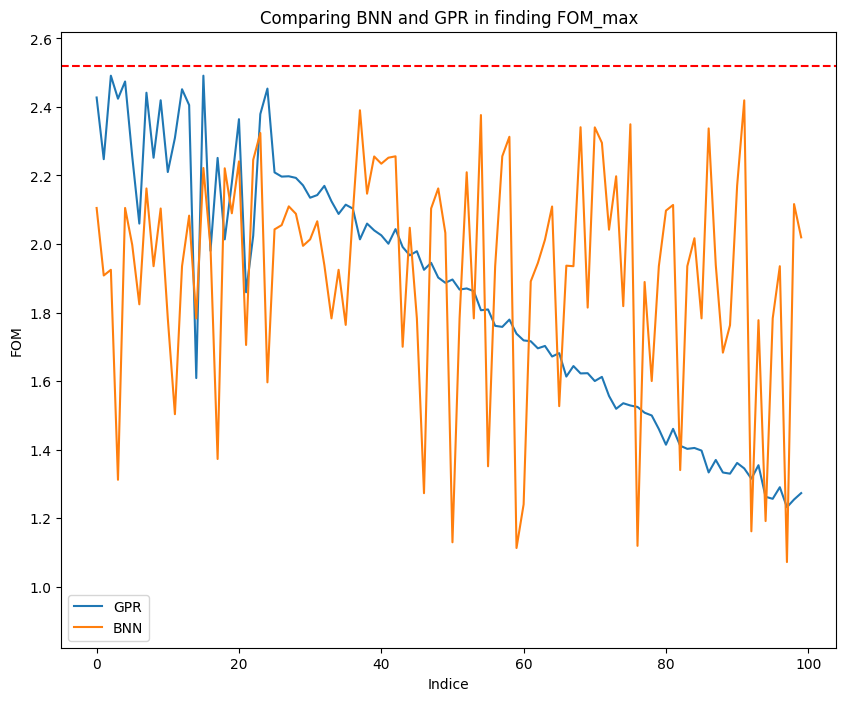

In [47]:
plt.figure(figsize=(10, 8))
plt.plot(FOM_gpr)
plt.plot(FOM_values_BNN)
plt.axhline(y=torch.max(y).item(), color='red', linestyle='--', label='Target Objective FOM')
plt.xlabel('Indice')
plt.ylabel('FOM')
plt.ylim([np.min(FOM_values_BNN) - 0.25, torch.max(y).item() + 0.1])

plt.title('Comparing BNN and GPR in finding FOM_max')
plt.legend(['GPR', 'BNN'])
plt.show()

Constructing probability model P(S_i | FOM_i)

Following cells will construct switch array s.t. S = {0, 1}, while accepting FOM_i as inputs.

In [48]:
switch, FOM_prob = [], []

for i, j in zip(FOM_values_BNN, FOM_gpr):
    if i > j: #BNN chosen
        switch.append(1)
        FOM_prob.append(i)
    else: #GPR chosen
        switch.append(0)
        FOM_prob.append(j.item())

In [5]:
from sklearn import svm
from sklearn.model_selection import train_test_split

In [50]:
switch, FOM_prob = np.array(switch), np.array(FOM_prob)

In [55]:
X_train, X_test, y_train, y_test = train_test_split(FOM_prob, switch, test_size = 0.1, random_state = 41)

In [56]:
clf = svm.SVC()
clf.fit(X_train.reshape(-1, 1), y_train)

SVC()

In [57]:
clf.score(X_test.reshape(-1, 1), y_test)

0.6

In [59]:
import pickle

#save the SVC
with open('svc_model.pkl', 'wb') as model_file:
    pickle.dump(clf, model_file)

In [4]:
#uncomment this to load model
#import pickle
#with open('svc_model.pkl', 'rb') as model_file:
#    clf = pickle.load(model_file)

In [60]:
from sklearn.metrics import classification_report

print(classification_report(y_test, clf.predict(X_test.reshape(-1, 1))))

              precision    recall  f1-score   support

           0       0.75      0.50      0.60         6
           1       0.50      0.75      0.60         4

    accuracy                           0.60        10
   macro avg       0.62      0.62      0.60        10
weighted avg       0.65      0.60      0.60        10



Implementing model that dynamically switches between GPR and BNN

P(S_i | FOM_i) predicts on whether it should use GPR or BNN

In [5]:
def GPR(initial_X, initial_y, X, y):
    try:
        initial_X, initial_y = initial_X.detach().numpy(), initial_y.detach().numpy()
        X, y = X.detach().numpy(), y.detach().numpy()
    except:
        pass

    # defining the kernel for the Gaussian process
    kernel = Matern(length_scale=1.0)
    regressor = GaussianProcessRegressor(kernel=kernel)

    # initializing the optimizer
    optimizer = BayesianOptimizer(
        estimator=regressor,
        X_training=initial_X, y_training=initial_y,
        query_strategy=max_EI
    )

    FOM_gpr = []
    # Bayesian optimization
    query_idx, query_inst = optimizer.query(X)
    optimizer.teach(X[query_idx], y[query_idx])
    FOM_gpr.append(y[query_idx])
    
    return optimizer.X_training, optimizer.y_training, y[query_idx].item()

In [6]:
def BNN_v2(initial_X, initial_y, X, y):
    n_iterations = 100
    FOM_values, EI_arr = [], []

    try:
        X, y = torch.tensor(X, dtype = torch.float), torch.tensor(y, dtype = torch.float)
        initial_X, initial_y = torch.tensor(initial_X, dtype = torch.float), torch.tensor(initial_y, dtype = torch.float)
    except:
        pass

    model = nn.Sequential(
        bnn.BayesLinear(prior_mu=0, prior_sigma=0.1, in_features=3, out_features=64),
        nn.ReLU(),
        bnn.BayesLinear(prior_mu=0, prior_sigma=0.1, in_features=64, out_features=32),  # Additional hidden layer
        nn.ReLU(),
        bnn.BayesLinear(prior_mu=0, prior_sigma=0.1, in_features=32, out_features=16),  # Additional hidden layer
        nn.ReLU(),
        bnn.BayesLinear(prior_mu=0, prior_sigma=0.1, in_features=16, out_features=1),
    )

    #define the loss functions and optimizer needed
    mse_loss = nn.MSELoss()
    kl_loss = bnn.BKLLoss(reduction='mean', last_layer_only=False)
    kl_weight = 0.01

    optimizer = optim.Adam(model.parameters(), lr=1e-4)

    for step in range(250):
        pre = model(initial_X)
        mse = mse_loss(pre, initial_y.reshape(-1, 1))
        kl = kl_loss(model)
        cost = mse + kl_weight*kl
        
        optimizer.zero_grad()
        cost.backward()
        optimizer.step()
    
    print('- MSE : %2.2f, KL : %2.2f' % (mse.item(), kl.item()))

    model.eval()

    num_samples = 100  # should give 100 different BNN models to find array of <mean, stdev>
    predictions = torch.zeros((num_samples, X.shape[0]))

    with torch.no_grad():
        for i in range(num_samples):
            y_pred = model(X)
            predictions[i, :] = y_pred.squeeze().detach()
    
    current_objective = y_pred[np.argmax(y_pred)]
    pred_std = predictions.std(dim = 0)
    pred_mean = predictions.mean(dim = 0)

    #acquisition function results
    new_sample, EI, idx = EI_learning(X, y_pred = pred_mean, pred_std = pred_std)
    #print("New data point added : {}".format(new_sample))
    #print("Corresponding FOM : {}".format(y[idx]))
    #print("Target FOM : {}".format(torch.max(y).item()))

    initial_X = torch.cat((initial_X, new_sample.reshape(1, 3)))
    initial_y = torch.cat((initial_y, torch.tensor([y[idx].item()], dtype = torch.float)))

    return initial_X, initial_y, y[idx].item()

In [7]:
import logging

In [8]:
def optimalityGap(FOM, FOM_max):
    return np.abs(FOM - FOM_max)

In [15]:
n_iterations = 50
FOM_combined, optimalitygapArr = [], []
#probability_of_optimum, FOM_optimal = [], np.max(y)

for n_point in range(1, n_iterations + 1):
    print("Iteration # : {}".format(n_point))
    if n_point == 1:
        #gpr will be used
        print("Starting with GPR...")
        initial_X, initial_y, FOM_val = GPR(initial_X, initial_y, X, y)
        FOM_combined.append(FOM_val)
        optimalitygapArr.append(np.abs(np.max(y) - FOM_val))
        #probability_of_optimum.append(np.sum(initial_y < FOM_optimal) / len(initial_y))
    
    else:
        if clf.predict([[FOM_combined[-1]]]).item() == 1: #BNN
            print("Switching to BNN...")
            initial_X, initial_y, FOM_val = BNN_v2(initial_X, initial_y, X, y)
            FOM_combined.append(FOM_val)
            optimalitygapArr.append(np.abs(np.max(y) - FOM_val))
            #probability_of_optimum.append(torch.sum(initial_y < FOM_optimal).item() / len(initial_y))
        
        elif clf.predict([[FOM_combined[-1]]]).item() == 0: #GPR
            print("Switching to GPR...")
            initial_X, initial_y, FOM_val = GPR(initial_X, initial_y, X, y)
            FOM_combined.append(FOM_val)
            optimalitygapArr.append(np.abs(np.max(y) - FOM_val))
            #probability_of_optimum.append(np.sum(initial_y < FOM_optimal) / len(initial_y))
        

Iteration # : 1
Starting with GPR...
Iteration # : 2
Switching to GPR...
Iteration # : 3
Switching to BNN...
- MSE : 5.58, KL : 0.81
Iteration # : 4
Switching to BNN...


C:\Users\sarta\AppData\Local\Temp\ipykernel_16096\2616428218.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  initial_X, initial_y = torch.tensor(initial_X, dtype = torch.float), torch.tensor(initial_y, dtype = torch.float)


- MSE : 3.52, KL : 0.77
Iteration # : 5
Switching to BNN...


C:\Users\sarta\AppData\Local\Temp\ipykernel_16096\2616428218.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  initial_X, initial_y = torch.tensor(initial_X, dtype = torch.float), torch.tensor(initial_y, dtype = torch.float)


- MSE : 2.81, KL : 0.77
Iteration # : 6
Switching to BNN...


C:\Users\sarta\AppData\Local\Temp\ipykernel_16096\2616428218.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  initial_X, initial_y = torch.tensor(initial_X, dtype = torch.float), torch.tensor(initial_y, dtype = torch.float)


- MSE : 3.00, KL : 0.80
Iteration # : 7
Switching to BNN...


C:\Users\sarta\AppData\Local\Temp\ipykernel_16096\2616428218.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  initial_X, initial_y = torch.tensor(initial_X, dtype = torch.float), torch.tensor(initial_y, dtype = torch.float)


- MSE : 3.86, KL : 0.77
Iteration # : 8
Switching to GPR...
Iteration # : 9
Switching to GPR...
Iteration # : 10
Switching to GPR...
Iteration # : 11
Switching to GPR...
Iteration # : 12
Switching to GPR...
Iteration # : 13
Switching to GPR...
Iteration # : 14
Switching to GPR...
Iteration # : 15
Switching to BNN...
- MSE : 5.53, KL : 0.77
Iteration # : 16
Switching to BNN...


C:\Users\sarta\AppData\Local\Temp\ipykernel_16096\2616428218.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  initial_X, initial_y = torch.tensor(initial_X, dtype = torch.float), torch.tensor(initial_y, dtype = torch.float)


- MSE : 4.60, KL : 0.79
Iteration # : 17
Switching to BNN...


C:\Users\sarta\AppData\Local\Temp\ipykernel_16096\2616428218.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  initial_X, initial_y = torch.tensor(initial_X, dtype = torch.float), torch.tensor(initial_y, dtype = torch.float)


- MSE : 3.25, KL : 0.78
Iteration # : 18
Switching to BNN...


C:\Users\sarta\AppData\Local\Temp\ipykernel_16096\2616428218.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  initial_X, initial_y = torch.tensor(initial_X, dtype = torch.float), torch.tensor(initial_y, dtype = torch.float)


- MSE : 4.37, KL : 0.77
Iteration # : 19
Switching to BNN...


C:\Users\sarta\AppData\Local\Temp\ipykernel_16096\2616428218.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  initial_X, initial_y = torch.tensor(initial_X, dtype = torch.float), torch.tensor(initial_y, dtype = torch.float)


- MSE : 4.19, KL : 0.75
Iteration # : 20
Switching to GPR...
Iteration # : 21
Switching to BNN...
- MSE : 3.32, KL : 0.77
Iteration # : 22
Switching to BNN...


C:\Users\sarta\AppData\Local\Temp\ipykernel_16096\2616428218.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  initial_X, initial_y = torch.tensor(initial_X, dtype = torch.float), torch.tensor(initial_y, dtype = torch.float)


- MSE : 4.72, KL : 0.72
Iteration # : 23
Switching to BNN...


C:\Users\sarta\AppData\Local\Temp\ipykernel_16096\2616428218.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  initial_X, initial_y = torch.tensor(initial_X, dtype = torch.float), torch.tensor(initial_y, dtype = torch.float)


- MSE : 3.47, KL : 0.78
Iteration # : 24
Switching to GPR...
Iteration # : 25
Switching to BNN...


c:\ProgramData\mambaforge\lib\site-packages\sklearn\gaussian_process\_gpr.py:659: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


- MSE : 4.72, KL : 0.73
Iteration # : 26
Switching to BNN...


C:\Users\sarta\AppData\Local\Temp\ipykernel_16096\2616428218.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  initial_X, initial_y = torch.tensor(initial_X, dtype = torch.float), torch.tensor(initial_y, dtype = torch.float)


- MSE : 3.66, KL : 0.76
Iteration # : 27
Switching to BNN...


C:\Users\sarta\AppData\Local\Temp\ipykernel_16096\2616428218.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  initial_X, initial_y = torch.tensor(initial_X, dtype = torch.float), torch.tensor(initial_y, dtype = torch.float)


- MSE : 4.42, KL : 0.79
Iteration # : 28
Switching to BNN...


C:\Users\sarta\AppData\Local\Temp\ipykernel_16096\2616428218.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  initial_X, initial_y = torch.tensor(initial_X, dtype = torch.float), torch.tensor(initial_y, dtype = torch.float)


- MSE : 3.94, KL : 0.76
Iteration # : 29
Switching to BNN...


C:\Users\sarta\AppData\Local\Temp\ipykernel_16096\2616428218.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  initial_X, initial_y = torch.tensor(initial_X, dtype = torch.float), torch.tensor(initial_y, dtype = torch.float)


- MSE : 3.09, KL : 0.72
Iteration # : 30
Switching to BNN...


C:\Users\sarta\AppData\Local\Temp\ipykernel_16096\2616428218.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  initial_X, initial_y = torch.tensor(initial_X, dtype = torch.float), torch.tensor(initial_y, dtype = torch.float)


- MSE : 3.47, KL : 0.78
Iteration # : 31
Switching to BNN...


C:\Users\sarta\AppData\Local\Temp\ipykernel_16096\2616428218.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  initial_X, initial_y = torch.tensor(initial_X, dtype = torch.float), torch.tensor(initial_y, dtype = torch.float)


- MSE : 3.59, KL : 0.79
Iteration # : 32
Switching to GPR...
Iteration # : 33
Switching to BNN...
- MSE : 2.93, KL : 0.80
Iteration # : 34
Switching to BNN...


C:\Users\sarta\AppData\Local\Temp\ipykernel_16096\2616428218.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  initial_X, initial_y = torch.tensor(initial_X, dtype = torch.float), torch.tensor(initial_y, dtype = torch.float)


- MSE : 4.64, KL : 0.73
Iteration # : 35
Switching to BNN...


C:\Users\sarta\AppData\Local\Temp\ipykernel_16096\2616428218.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  initial_X, initial_y = torch.tensor(initial_X, dtype = torch.float), torch.tensor(initial_y, dtype = torch.float)


- MSE : 2.43, KL : 0.74
Iteration # : 36
Switching to BNN...


C:\Users\sarta\AppData\Local\Temp\ipykernel_16096\2616428218.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  initial_X, initial_y = torch.tensor(initial_X, dtype = torch.float), torch.tensor(initial_y, dtype = torch.float)


- MSE : 4.03, KL : 0.81
Iteration # : 37
Switching to BNN...


C:\Users\sarta\AppData\Local\Temp\ipykernel_16096\2616428218.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  initial_X, initial_y = torch.tensor(initial_X, dtype = torch.float), torch.tensor(initial_y, dtype = torch.float)


- MSE : 3.26, KL : 0.83
Iteration # : 38
Switching to BNN...


C:\Users\sarta\AppData\Local\Temp\ipykernel_16096\2616428218.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  initial_X, initial_y = torch.tensor(initial_X, dtype = torch.float), torch.tensor(initial_y, dtype = torch.float)


- MSE : 3.97, KL : 0.78
Iteration # : 39
Switching to BNN...


C:\Users\sarta\AppData\Local\Temp\ipykernel_16096\2616428218.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  initial_X, initial_y = torch.tensor(initial_X, dtype = torch.float), torch.tensor(initial_y, dtype = torch.float)


- MSE : 3.07, KL : 0.79
Iteration # : 40
Switching to BNN...


C:\Users\sarta\AppData\Local\Temp\ipykernel_16096\2616428218.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  initial_X, initial_y = torch.tensor(initial_X, dtype = torch.float), torch.tensor(initial_y, dtype = torch.float)


- MSE : 5.00, KL : 0.75
Iteration # : 41
Switching to BNN...


C:\Users\sarta\AppData\Local\Temp\ipykernel_16096\2616428218.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  initial_X, initial_y = torch.tensor(initial_X, dtype = torch.float), torch.tensor(initial_y, dtype = torch.float)


- MSE : 5.81, KL : 0.80
Iteration # : 42
Switching to BNN...


C:\Users\sarta\AppData\Local\Temp\ipykernel_16096\2616428218.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  initial_X, initial_y = torch.tensor(initial_X, dtype = torch.float), torch.tensor(initial_y, dtype = torch.float)


- MSE : 2.33, KL : 0.77
Iteration # : 43
Switching to GPR...
Iteration # : 44
Switching to GPR...
Iteration # : 45
Switching to GPR...
Iteration # : 46
Switching to GPR...
Iteration # : 47
Switching to BNN...
- MSE : 4.47, KL : 0.77
Iteration # : 48
Switching to BNN...


C:\Users\sarta\AppData\Local\Temp\ipykernel_16096\2616428218.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  initial_X, initial_y = torch.tensor(initial_X, dtype = torch.float), torch.tensor(initial_y, dtype = torch.float)


- MSE : 4.30, KL : 0.80
Iteration # : 49
Switching to BNN...


C:\Users\sarta\AppData\Local\Temp\ipykernel_16096\2616428218.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  initial_X, initial_y = torch.tensor(initial_X, dtype = torch.float), torch.tensor(initial_y, dtype = torch.float)


- MSE : 4.30, KL : 0.77
Iteration # : 50
Switching to BNN...


C:\Users\sarta\AppData\Local\Temp\ipykernel_16096\2616428218.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  initial_X, initial_y = torch.tensor(initial_X, dtype = torch.float), torch.tensor(initial_y, dtype = torch.float)


- MSE : 1.54, KL : 0.80


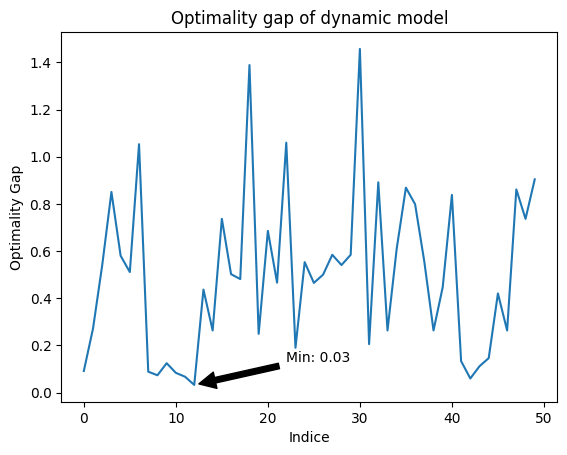

In [19]:
plt.plot(optimalitygapArr)
plt.xlabel('Indice')
plt.ylabel('Optimality Gap')
plt.title('Optimality gap of dynamic model')

# Find the index of the minimum value in optimalitygapArr
min_index = np.argmin(optimalitygapArr)
min_value = np.min(optimalitygapArr)

# Annotate the minimum value on the plot
plt.annotate(f'Min: {min_value:.2f}', xy=(min_index, min_value), xytext=(min_index + 10, min_value + 0.1),
             arrowprops=dict(facecolor='black', shrink=0.05))

# Show the plot
plt.show()

In [13]:
#run this code block to log required data
logging.basicConfig(filename='results/optimalityGap.log', level=logging.DEBUG, format='%(asctime)s - %(levelname)s - %(message)s')
#probability_of_optimum, FOM_optimal = [], np.max(y)

for trialNum in range(4):
    initial_X, initial_y = np.load("initial_data/initial_X.npy"), np.load("initial_data/initial_y.npy")
    n_iterations = 50
    FOM_combined, optimality_arr = [], []
    newParam = []

    for n_point in range(1, n_iterations + 1):
        print("Iteration # : {}".format(n_point))
        if n_point == 1:
            #gpr will be used
            print("Starting with GPR...")
            initial_X, initial_y, FOM_val = GPR(initial_X, initial_y, X, y)
            FOM_combined.append(FOM_val)
            optimality_arr.append(np.abs(np.max(y) - FOM_val))
            newParam.append(initial_X[-1])
            #probability_of_optimum.append(np.sum(initial_y < FOM_optimal) / len(initial_y))
        
        else:
            if clf.predict([[FOM_combined[-1]]]).item() == 1: #BNN
                print("Switching to BNN...")
                initial_X, initial_y, FOM_val = BNN_v2(initial_X, initial_y, X, y)
                FOM_combined.append(FOM_val)
                optimality_arr.append(np.abs(np.max(y) - FOM_val))
                newParam.append(initial_X[-1])
                #probability_of_optimum.append(torch.sum(initial_y < FOM_optimal).item() / len(initial_y))
            
            elif clf.predict([[FOM_combined[-1]]]).item() == 0: #GPR
                print("Switching to GPR...")
                initial_X, initial_y, FOM_val = GPR(initial_X, initial_y, X, y)
                FOM_combined.append(FOM_val)
                optimality_arr.append(np.abs(np.max(y) - FOM_val))
                newParam.append(initial_X[-1])
                #probability_of_optimum.append(np.sum(initial_y < FOM_optimal) / len(initial_y))
    
    logging.info('Trial : {}, min(O_G) : {}, Optimal Parameters : {}, N_req : {}'.format(trialNum, np.min(optimality_arr), newParam[np.argmin(optimality_arr)], np.argmin(optimality_arr)))

Iteration # : 1
Starting with GPR...
Iteration # : 2
Switching to GPR...
Iteration # : 3
Switching to BNN...
- MSE : 4.18, KL : 0.79
Iteration # : 4
Switching to BNN...


C:\Users\sarta\AppData\Local\Temp\ipykernel_16096\2616428218.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  initial_X, initial_y = torch.tensor(initial_X, dtype = torch.float), torch.tensor(initial_y, dtype = torch.float)


- MSE : 5.05, KL : 0.75
Iteration # : 5
Switching to BNN...


C:\Users\sarta\AppData\Local\Temp\ipykernel_16096\2616428218.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  initial_X, initial_y = torch.tensor(initial_X, dtype = torch.float), torch.tensor(initial_y, dtype = torch.float)


- MSE : 4.56, KL : 0.75
Iteration # : 6
Switching to BNN...


C:\Users\sarta\AppData\Local\Temp\ipykernel_16096\2616428218.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  initial_X, initial_y = torch.tensor(initial_X, dtype = torch.float), torch.tensor(initial_y, dtype = torch.float)


- MSE : 2.88, KL : 0.77
Iteration # : 7
Switching to BNN...


C:\Users\sarta\AppData\Local\Temp\ipykernel_16096\2616428218.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  initial_X, initial_y = torch.tensor(initial_X, dtype = torch.float), torch.tensor(initial_y, dtype = torch.float)


- MSE : 2.34, KL : 0.80
Iteration # : 8
Switching to BNN...


C:\Users\sarta\AppData\Local\Temp\ipykernel_16096\2616428218.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  initial_X, initial_y = torch.tensor(initial_X, dtype = torch.float), torch.tensor(initial_y, dtype = torch.float)


- MSE : 3.67, KL : 0.75
Iteration # : 9
Switching to GPR...
Iteration # : 10
Switching to GPR...
Iteration # : 11
Switching to GPR...
Iteration # : 12
Switching to GPR...
Iteration # : 13
Switching to GPR...
Iteration # : 14
Switching to GPR...
Iteration # : 15
Switching to BNN...
- MSE : 3.57, KL : 0.77
Iteration # : 16
Switching to BNN...


C:\Users\sarta\AppData\Local\Temp\ipykernel_16096\2616428218.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  initial_X, initial_y = torch.tensor(initial_X, dtype = torch.float), torch.tensor(initial_y, dtype = torch.float)


- MSE : 4.01, KL : 0.72
Iteration # : 17
Switching to BNN...


C:\Users\sarta\AppData\Local\Temp\ipykernel_16096\2616428218.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  initial_X, initial_y = torch.tensor(initial_X, dtype = torch.float), torch.tensor(initial_y, dtype = torch.float)


- MSE : 4.68, KL : 0.77
Iteration # : 18
Switching to BNN...


C:\Users\sarta\AppData\Local\Temp\ipykernel_16096\2616428218.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  initial_X, initial_y = torch.tensor(initial_X, dtype = torch.float), torch.tensor(initial_y, dtype = torch.float)


- MSE : 3.95, KL : 0.80
Iteration # : 19
Switching to BNN...


C:\Users\sarta\AppData\Local\Temp\ipykernel_16096\2616428218.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  initial_X, initial_y = torch.tensor(initial_X, dtype = torch.float), torch.tensor(initial_y, dtype = torch.float)


- MSE : 4.61, KL : 0.77
Iteration # : 20
Switching to BNN...


C:\Users\sarta\AppData\Local\Temp\ipykernel_16096\2616428218.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  initial_X, initial_y = torch.tensor(initial_X, dtype = torch.float), torch.tensor(initial_y, dtype = torch.float)


- MSE : 4.19, KL : 0.77
Iteration # : 21
Switching to BNN...


C:\Users\sarta\AppData\Local\Temp\ipykernel_16096\2616428218.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  initial_X, initial_y = torch.tensor(initial_X, dtype = torch.float), torch.tensor(initial_y, dtype = torch.float)


- MSE : 4.10, KL : 0.78
Iteration # : 22
Switching to BNN...


C:\Users\sarta\AppData\Local\Temp\ipykernel_16096\2616428218.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  initial_X, initial_y = torch.tensor(initial_X, dtype = torch.float), torch.tensor(initial_y, dtype = torch.float)


- MSE : 3.59, KL : 0.78
Iteration # : 23
Switching to BNN...


C:\Users\sarta\AppData\Local\Temp\ipykernel_16096\2616428218.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  initial_X, initial_y = torch.tensor(initial_X, dtype = torch.float), torch.tensor(initial_y, dtype = torch.float)


- MSE : 3.44, KL : 0.81
Iteration # : 24
Switching to BNN...


C:\Users\sarta\AppData\Local\Temp\ipykernel_16096\2616428218.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  initial_X, initial_y = torch.tensor(initial_X, dtype = torch.float), torch.tensor(initial_y, dtype = torch.float)


- MSE : 2.92, KL : 0.75
Iteration # : 25
Switching to BNN...


C:\Users\sarta\AppData\Local\Temp\ipykernel_16096\2616428218.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  initial_X, initial_y = torch.tensor(initial_X, dtype = torch.float), torch.tensor(initial_y, dtype = torch.float)


- MSE : 2.46, KL : 0.74
Iteration # : 26
Switching to GPR...
Iteration # : 27
Switching to GPR...
Iteration # : 28
Switching to BNN...


c:\ProgramData\mambaforge\lib\site-packages\sklearn\gaussian_process\kernels.py:419: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\ProgramData\mambaforge\lib\site-packages\sklearn\gaussian_process\kernels.py:419: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\ProgramData\mambaforge\lib\site-packages\sklearn\gaussian_process\kernels.py:419: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


- MSE : 3.30, KL : 0.77
Iteration # : 29
Switching to BNN...


C:\Users\sarta\AppData\Local\Temp\ipykernel_16096\2616428218.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  initial_X, initial_y = torch.tensor(initial_X, dtype = torch.float), torch.tensor(initial_y, dtype = torch.float)


- MSE : 3.23, KL : 0.79
Iteration # : 30
Switching to GPR...
Iteration # : 31
Switching to BNN...


c:\ProgramData\mambaforge\lib\site-packages\sklearn\gaussian_process\kernels.py:419: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\ProgramData\mambaforge\lib\site-packages\sklearn\gaussian_process\kernels.py:419: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


- MSE : 3.68, KL : 0.78
Iteration # : 32
Switching to BNN...


C:\Users\sarta\AppData\Local\Temp\ipykernel_16096\2616428218.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  initial_X, initial_y = torch.tensor(initial_X, dtype = torch.float), torch.tensor(initial_y, dtype = torch.float)


- MSE : 3.63, KL : 0.83
Iteration # : 33
Switching to BNN...


C:\Users\sarta\AppData\Local\Temp\ipykernel_16096\2616428218.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  initial_X, initial_y = torch.tensor(initial_X, dtype = torch.float), torch.tensor(initial_y, dtype = torch.float)


- MSE : 4.29, KL : 0.78
Iteration # : 34
Switching to BNN...


C:\Users\sarta\AppData\Local\Temp\ipykernel_16096\2616428218.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  initial_X, initial_y = torch.tensor(initial_X, dtype = torch.float), torch.tensor(initial_y, dtype = torch.float)


- MSE : 3.26, KL : 0.78
Iteration # : 35
Switching to BNN...


C:\Users\sarta\AppData\Local\Temp\ipykernel_16096\2616428218.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  initial_X, initial_y = torch.tensor(initial_X, dtype = torch.float), torch.tensor(initial_y, dtype = torch.float)


- MSE : 3.10, KL : 0.77
Iteration # : 36
Switching to BNN...


C:\Users\sarta\AppData\Local\Temp\ipykernel_16096\2616428218.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  initial_X, initial_y = torch.tensor(initial_X, dtype = torch.float), torch.tensor(initial_y, dtype = torch.float)


- MSE : 4.01, KL : 0.81
Iteration # : 37
Switching to BNN...


C:\Users\sarta\AppData\Local\Temp\ipykernel_16096\2616428218.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  initial_X, initial_y = torch.tensor(initial_X, dtype = torch.float), torch.tensor(initial_y, dtype = torch.float)


- MSE : 2.67, KL : 0.73
Iteration # : 38
Switching to BNN...


C:\Users\sarta\AppData\Local\Temp\ipykernel_16096\2616428218.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  initial_X, initial_y = torch.tensor(initial_X, dtype = torch.float), torch.tensor(initial_y, dtype = torch.float)


- MSE : 2.67, KL : 0.74
Iteration # : 39
Switching to BNN...


C:\Users\sarta\AppData\Local\Temp\ipykernel_16096\2616428218.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  initial_X, initial_y = torch.tensor(initial_X, dtype = torch.float), torch.tensor(initial_y, dtype = torch.float)


- MSE : 3.75, KL : 0.82
Iteration # : 40
Switching to BNN...


C:\Users\sarta\AppData\Local\Temp\ipykernel_16096\2616428218.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  initial_X, initial_y = torch.tensor(initial_X, dtype = torch.float), torch.tensor(initial_y, dtype = torch.float)


- MSE : 2.29, KL : 0.75
Iteration # : 41
Switching to BNN...


C:\Users\sarta\AppData\Local\Temp\ipykernel_16096\2616428218.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  initial_X, initial_y = torch.tensor(initial_X, dtype = torch.float), torch.tensor(initial_y, dtype = torch.float)


- MSE : 2.76, KL : 0.75
Iteration # : 42
Switching to BNN...


C:\Users\sarta\AppData\Local\Temp\ipykernel_16096\2616428218.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  initial_X, initial_y = torch.tensor(initial_X, dtype = torch.float), torch.tensor(initial_y, dtype = torch.float)


- MSE : 5.43, KL : 0.75
Iteration # : 43
Switching to BNN...


C:\Users\sarta\AppData\Local\Temp\ipykernel_16096\2616428218.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  initial_X, initial_y = torch.tensor(initial_X, dtype = torch.float), torch.tensor(initial_y, dtype = torch.float)


- MSE : 3.33, KL : 0.78
Iteration # : 44
Switching to BNN...


C:\Users\sarta\AppData\Local\Temp\ipykernel_16096\2616428218.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  initial_X, initial_y = torch.tensor(initial_X, dtype = torch.float), torch.tensor(initial_y, dtype = torch.float)


- MSE : 3.95, KL : 0.77
Iteration # : 45
Switching to BNN...


C:\Users\sarta\AppData\Local\Temp\ipykernel_16096\2616428218.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  initial_X, initial_y = torch.tensor(initial_X, dtype = torch.float), torch.tensor(initial_y, dtype = torch.float)


- MSE : 2.69, KL : 0.77
Iteration # : 46
Switching to BNN...


C:\Users\sarta\AppData\Local\Temp\ipykernel_16096\2616428218.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  initial_X, initial_y = torch.tensor(initial_X, dtype = torch.float), torch.tensor(initial_y, dtype = torch.float)


- MSE : 3.68, KL : 0.79
Iteration # : 47
Switching to GPR...
Iteration # : 48
Switching to BNN...


c:\ProgramData\mambaforge\lib\site-packages\sklearn\gaussian_process\kernels.py:419: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\ProgramData\mambaforge\lib\site-packages\sklearn\gaussian_process\kernels.py:419: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


- MSE : 4.49, KL : 0.76
Iteration # : 49
Switching to BNN...


C:\Users\sarta\AppData\Local\Temp\ipykernel_16096\2616428218.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  initial_X, initial_y = torch.tensor(initial_X, dtype = torch.float), torch.tensor(initial_y, dtype = torch.float)


- MSE : 1.80, KL : 0.81
Iteration # : 50
Switching to BNN...


C:\Users\sarta\AppData\Local\Temp\ipykernel_16096\2616428218.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  initial_X, initial_y = torch.tensor(initial_X, dtype = torch.float), torch.tensor(initial_y, dtype = torch.float)


- MSE : 3.04, KL : 0.78
Iteration # : 1
Starting with GPR...
Iteration # : 2
Switching to GPR...
Iteration # : 3
Switching to BNN...
- MSE : 3.89, KL : 0.74
Iteration # : 4
Switching to BNN...


C:\Users\sarta\AppData\Local\Temp\ipykernel_16096\2616428218.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  initial_X, initial_y = torch.tensor(initial_X, dtype = torch.float), torch.tensor(initial_y, dtype = torch.float)


- MSE : 4.11, KL : 0.81
Iteration # : 5
Switching to BNN...


C:\Users\sarta\AppData\Local\Temp\ipykernel_16096\2616428218.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  initial_X, initial_y = torch.tensor(initial_X, dtype = torch.float), torch.tensor(initial_y, dtype = torch.float)


- MSE : 1.41, KL : 0.76
Iteration # : 6
Switching to GPR...
Iteration # : 7
Switching to GPR...
Iteration # : 8
Switching to BNN...
- MSE : 3.49, KL : 0.79
Iteration # : 9
Switching to BNN...


C:\Users\sarta\AppData\Local\Temp\ipykernel_16096\2616428218.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  initial_X, initial_y = torch.tensor(initial_X, dtype = torch.float), torch.tensor(initial_y, dtype = torch.float)


- MSE : 3.63, KL : 0.79
Iteration # : 10
Switching to GPR...
Iteration # : 11
Switching to BNN...


c:\ProgramData\mambaforge\lib\site-packages\sklearn\gaussian_process\kernels.py:419: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


- MSE : 3.33, KL : 0.78
Iteration # : 12
Switching to BNN...


C:\Users\sarta\AppData\Local\Temp\ipykernel_16096\2616428218.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  initial_X, initial_y = torch.tensor(initial_X, dtype = torch.float), torch.tensor(initial_y, dtype = torch.float)


- MSE : 2.11, KL : 0.74
Iteration # : 13
Switching to GPR...


c:\ProgramData\mambaforge\lib\site-packages\sklearn\gaussian_process\kernels.py:419: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\ProgramData\mambaforge\lib\site-packages\sklearn\gaussian_process\kernels.py:419: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Iteration # : 14
Switching to BNN...
- MSE : 2.64, KL : 0.78
Iteration # : 15
Switching to BNN...


C:\Users\sarta\AppData\Local\Temp\ipykernel_16096\2616428218.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  initial_X, initial_y = torch.tensor(initial_X, dtype = torch.float), torch.tensor(initial_y, dtype = torch.float)


- MSE : 2.78, KL : 0.74
Iteration # : 16
Switching to BNN...


C:\Users\sarta\AppData\Local\Temp\ipykernel_16096\2616428218.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  initial_X, initial_y = torch.tensor(initial_X, dtype = torch.float), torch.tensor(initial_y, dtype = torch.float)


- MSE : 4.20, KL : 0.78
Iteration # : 17
Switching to BNN...


C:\Users\sarta\AppData\Local\Temp\ipykernel_16096\2616428218.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  initial_X, initial_y = torch.tensor(initial_X, dtype = torch.float), torch.tensor(initial_y, dtype = torch.float)


- MSE : 3.69, KL : 0.78
Iteration # : 18
Switching to BNN...


C:\Users\sarta\AppData\Local\Temp\ipykernel_16096\2616428218.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  initial_X, initial_y = torch.tensor(initial_X, dtype = torch.float), torch.tensor(initial_y, dtype = torch.float)


- MSE : 3.10, KL : 0.79
Iteration # : 19
Switching to BNN...


C:\Users\sarta\AppData\Local\Temp\ipykernel_16096\2616428218.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  initial_X, initial_y = torch.tensor(initial_X, dtype = torch.float), torch.tensor(initial_y, dtype = torch.float)


- MSE : 3.75, KL : 0.76
Iteration # : 20
Switching to GPR...
Iteration # : 21
Switching to BNN...


c:\ProgramData\mambaforge\lib\site-packages\sklearn\gaussian_process\kernels.py:419: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


- MSE : 3.92, KL : 0.76
Iteration # : 22
Switching to BNN...


C:\Users\sarta\AppData\Local\Temp\ipykernel_16096\2616428218.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  initial_X, initial_y = torch.tensor(initial_X, dtype = torch.float), torch.tensor(initial_y, dtype = torch.float)


- MSE : 3.22, KL : 0.81
Iteration # : 23
Switching to BNN...


C:\Users\sarta\AppData\Local\Temp\ipykernel_16096\2616428218.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  initial_X, initial_y = torch.tensor(initial_X, dtype = torch.float), torch.tensor(initial_y, dtype = torch.float)


- MSE : 3.54, KL : 0.74
Iteration # : 24
Switching to BNN...


C:\Users\sarta\AppData\Local\Temp\ipykernel_16096\2616428218.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  initial_X, initial_y = torch.tensor(initial_X, dtype = torch.float), torch.tensor(initial_y, dtype = torch.float)


- MSE : 3.52, KL : 0.78
Iteration # : 25
Switching to GPR...
Iteration # : 26
Switching to GPR...
Iteration # : 27
Switching to GPR...
Iteration # : 28
Switching to BNN...
- MSE : 2.25, KL : 0.81
Iteration # : 29
Switching to BNN...


C:\Users\sarta\AppData\Local\Temp\ipykernel_16096\2616428218.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  initial_X, initial_y = torch.tensor(initial_X, dtype = torch.float), torch.tensor(initial_y, dtype = torch.float)


- MSE : 2.91, KL : 0.78
Iteration # : 30
Switching to BNN...


C:\Users\sarta\AppData\Local\Temp\ipykernel_16096\2616428218.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  initial_X, initial_y = torch.tensor(initial_X, dtype = torch.float), torch.tensor(initial_y, dtype = torch.float)


- MSE : 2.95, KL : 0.76
Iteration # : 31
Switching to BNN...


C:\Users\sarta\AppData\Local\Temp\ipykernel_16096\2616428218.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  initial_X, initial_y = torch.tensor(initial_X, dtype = torch.float), torch.tensor(initial_y, dtype = torch.float)


- MSE : 3.26, KL : 0.84
Iteration # : 32
Switching to BNN...


C:\Users\sarta\AppData\Local\Temp\ipykernel_16096\2616428218.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  initial_X, initial_y = torch.tensor(initial_X, dtype = torch.float), torch.tensor(initial_y, dtype = torch.float)


- MSE : 4.03, KL : 0.79
Iteration # : 33
Switching to BNN...


C:\Users\sarta\AppData\Local\Temp\ipykernel_16096\2616428218.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  initial_X, initial_y = torch.tensor(initial_X, dtype = torch.float), torch.tensor(initial_y, dtype = torch.float)


- MSE : 2.09, KL : 0.75
Iteration # : 34
Switching to BNN...


C:\Users\sarta\AppData\Local\Temp\ipykernel_16096\2616428218.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  initial_X, initial_y = torch.tensor(initial_X, dtype = torch.float), torch.tensor(initial_y, dtype = torch.float)


- MSE : 2.36, KL : 0.70
Iteration # : 35
Switching to GPR...
Iteration # : 36
Switching to GPR...
Iteration # : 37
Switching to GPR...
Iteration # : 38
Switching to GPR...
Iteration # : 39
Switching to GPR...
Iteration # : 40
Switching to BNN...
- MSE : 1.75, KL : 0.73
Iteration # : 41
Switching to BNN...


C:\Users\sarta\AppData\Local\Temp\ipykernel_16096\2616428218.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  initial_X, initial_y = torch.tensor(initial_X, dtype = torch.float), torch.tensor(initial_y, dtype = torch.float)


- MSE : 2.86, KL : 0.77
Iteration # : 42
Switching to GPR...
Iteration # : 43
Switching to GPR...
Iteration # : 44
Switching to BNN...
- MSE : 5.57, KL : 0.75
Iteration # : 45
Switching to GPR...


c:\ProgramData\mambaforge\lib\site-packages\sklearn\gaussian_process\_gpr.py:659: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
c:\ProgramData\mambaforge\lib\site-packages\sklearn\gaussian_process\_gpr.py:659: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
c:\ProgramData\mambaforge\lib\site-packages\sklearn\gaussian_process\_gpr.py:659: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/

Iteration # : 46
Switching to GPR...
Iteration # : 47
Switching to GPR...
Iteration # : 48
Switching to GPR...


c:\ProgramData\mambaforge\lib\site-packages\sklearn\gaussian_process\kernels.py:419: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Iteration # : 49
Switching to BNN...
- MSE : 4.65, KL : 0.75
Iteration # : 50
Switching to GPR...
Iteration # : 1
Starting with GPR...
Iteration # : 2
Switching to GPR...
Iteration # : 3
Switching to BNN...


c:\ProgramData\mambaforge\lib\site-packages\sklearn\gaussian_process\kernels.py:419: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\ProgramData\mambaforge\lib\site-packages\sklearn\gaussian_process\kernels.py:419: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


- MSE : 3.77, KL : 0.78
Iteration # : 4
Switching to GPR...
Iteration # : 5
Switching to GPR...
Iteration # : 6
Switching to GPR...
Iteration # : 7
Switching to GPR...
Iteration # : 8
Switching to GPR...
Iteration # : 9
Switching to GPR...
Iteration # : 10
Switching to GPR...
Iteration # : 11
Switching to GPR...
Iteration # : 12
Switching to GPR...
Iteration # : 13
Switching to GPR...
Iteration # : 14
Switching to BNN...
- MSE : 5.15, KL : 0.78
Iteration # : 15
Switching to BNN...


C:\Users\sarta\AppData\Local\Temp\ipykernel_16096\2616428218.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  initial_X, initial_y = torch.tensor(initial_X, dtype = torch.float), torch.tensor(initial_y, dtype = torch.float)


- MSE : 5.05, KL : 0.73
Iteration # : 16
Switching to BNN...


C:\Users\sarta\AppData\Local\Temp\ipykernel_16096\2616428218.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  initial_X, initial_y = torch.tensor(initial_X, dtype = torch.float), torch.tensor(initial_y, dtype = torch.float)


- MSE : 5.00, KL : 0.73
Iteration # : 17
Switching to BNN...


C:\Users\sarta\AppData\Local\Temp\ipykernel_16096\2616428218.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  initial_X, initial_y = torch.tensor(initial_X, dtype = torch.float), torch.tensor(initial_y, dtype = torch.float)


- MSE : 3.66, KL : 0.79
Iteration # : 18
Switching to BNN...


C:\Users\sarta\AppData\Local\Temp\ipykernel_16096\2616428218.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  initial_X, initial_y = torch.tensor(initial_X, dtype = torch.float), torch.tensor(initial_y, dtype = torch.float)


- MSE : 3.17, KL : 0.77
Iteration # : 19
Switching to BNN...


C:\Users\sarta\AppData\Local\Temp\ipykernel_16096\2616428218.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  initial_X, initial_y = torch.tensor(initial_X, dtype = torch.float), torch.tensor(initial_y, dtype = torch.float)


- MSE : 4.72, KL : 0.71
Iteration # : 20
Switching to GPR...
Iteration # : 21
Switching to BNN...
- MSE : 4.41, KL : 0.74
Iteration # : 22
Switching to BNN...


C:\Users\sarta\AppData\Local\Temp\ipykernel_16096\2616428218.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  initial_X, initial_y = torch.tensor(initial_X, dtype = torch.float), torch.tensor(initial_y, dtype = torch.float)


- MSE : 3.58, KL : 0.73
Iteration # : 23
Switching to BNN...


C:\Users\sarta\AppData\Local\Temp\ipykernel_16096\2616428218.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  initial_X, initial_y = torch.tensor(initial_X, dtype = torch.float), torch.tensor(initial_y, dtype = torch.float)


- MSE : 3.27, KL : 0.78
Iteration # : 24
Switching to BNN...


C:\Users\sarta\AppData\Local\Temp\ipykernel_16096\2616428218.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  initial_X, initial_y = torch.tensor(initial_X, dtype = torch.float), torch.tensor(initial_y, dtype = torch.float)


- MSE : 4.52, KL : 0.79
Iteration # : 25
Switching to BNN...


C:\Users\sarta\AppData\Local\Temp\ipykernel_16096\2616428218.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  initial_X, initial_y = torch.tensor(initial_X, dtype = torch.float), torch.tensor(initial_y, dtype = torch.float)


- MSE : 5.10, KL : 0.74
Iteration # : 26
Switching to GPR...
Iteration # : 27
Switching to GPR...
Iteration # : 28
Switching to BNN...


c:\ProgramData\mambaforge\lib\site-packages\sklearn\gaussian_process\kernels.py:419: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\ProgramData\mambaforge\lib\site-packages\sklearn\gaussian_process\kernels.py:419: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\ProgramData\mambaforge\lib\site-packages\sklearn\gaussian_process\kernels.py:419: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


- MSE : 5.20, KL : 0.76
Iteration # : 29
Switching to BNN...


C:\Users\sarta\AppData\Local\Temp\ipykernel_16096\2616428218.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  initial_X, initial_y = torch.tensor(initial_X, dtype = torch.float), torch.tensor(initial_y, dtype = torch.float)


- MSE : 4.62, KL : 0.77
Iteration # : 30
Switching to BNN...


C:\Users\sarta\AppData\Local\Temp\ipykernel_16096\2616428218.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  initial_X, initial_y = torch.tensor(initial_X, dtype = torch.float), torch.tensor(initial_y, dtype = torch.float)


- MSE : 2.47, KL : 0.79
Iteration # : 31
Switching to GPR...
Iteration # : 32
Switching to GPR...
Iteration # : 33
Switching to GPR...
Iteration # : 34
Switching to BNN...
- MSE : 4.60, KL : 0.79
Iteration # : 35
Switching to BNN...


C:\Users\sarta\AppData\Local\Temp\ipykernel_16096\2616428218.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  initial_X, initial_y = torch.tensor(initial_X, dtype = torch.float), torch.tensor(initial_y, dtype = torch.float)


- MSE : 3.00, KL : 0.75
Iteration # : 36
Switching to BNN...


C:\Users\sarta\AppData\Local\Temp\ipykernel_16096\2616428218.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  initial_X, initial_y = torch.tensor(initial_X, dtype = torch.float), torch.tensor(initial_y, dtype = torch.float)


- MSE : 4.13, KL : 0.77
Iteration # : 37
Switching to BNN...


C:\Users\sarta\AppData\Local\Temp\ipykernel_16096\2616428218.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  initial_X, initial_y = torch.tensor(initial_X, dtype = torch.float), torch.tensor(initial_y, dtype = torch.float)


- MSE : 3.25, KL : 0.74
Iteration # : 38
Switching to BNN...


C:\Users\sarta\AppData\Local\Temp\ipykernel_16096\2616428218.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  initial_X, initial_y = torch.tensor(initial_X, dtype = torch.float), torch.tensor(initial_y, dtype = torch.float)


- MSE : 3.16, KL : 0.76
Iteration # : 39
Switching to BNN...


C:\Users\sarta\AppData\Local\Temp\ipykernel_16096\2616428218.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  initial_X, initial_y = torch.tensor(initial_X, dtype = torch.float), torch.tensor(initial_y, dtype = torch.float)


- MSE : 3.78, KL : 0.76
Iteration # : 40
Switching to GPR...
Iteration # : 41
Switching to GPR...
Iteration # : 42
Switching to GPR...
Iteration # : 43
Switching to BNN...


c:\ProgramData\mambaforge\lib\site-packages\sklearn\gaussian_process\kernels.py:419: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\ProgramData\mambaforge\lib\site-packages\sklearn\gaussian_process\kernels.py:419: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\ProgramData\mambaforge\lib\site-packages\sklearn\gaussian_process\kernels.py:419: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


- MSE : 4.20, KL : 0.74
Iteration # : 44
Switching to BNN...


C:\Users\sarta\AppData\Local\Temp\ipykernel_16096\2616428218.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  initial_X, initial_y = torch.tensor(initial_X, dtype = torch.float), torch.tensor(initial_y, dtype = torch.float)


- MSE : 4.08, KL : 0.73
Iteration # : 45
Switching to BNN...


C:\Users\sarta\AppData\Local\Temp\ipykernel_16096\2616428218.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  initial_X, initial_y = torch.tensor(initial_X, dtype = torch.float), torch.tensor(initial_y, dtype = torch.float)


- MSE : 5.95, KL : 0.78
Iteration # : 46
Switching to BNN...


C:\Users\sarta\AppData\Local\Temp\ipykernel_16096\2616428218.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  initial_X, initial_y = torch.tensor(initial_X, dtype = torch.float), torch.tensor(initial_y, dtype = torch.float)


- MSE : 4.63, KL : 0.81
Iteration # : 47
Switching to BNN...


C:\Users\sarta\AppData\Local\Temp\ipykernel_16096\2616428218.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  initial_X, initial_y = torch.tensor(initial_X, dtype = torch.float), torch.tensor(initial_y, dtype = torch.float)


- MSE : 3.31, KL : 0.80
Iteration # : 48
Switching to BNN...


C:\Users\sarta\AppData\Local\Temp\ipykernel_16096\2616428218.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  initial_X, initial_y = torch.tensor(initial_X, dtype = torch.float), torch.tensor(initial_y, dtype = torch.float)


- MSE : 5.36, KL : 0.74
Iteration # : 49
Switching to BNN...


C:\Users\sarta\AppData\Local\Temp\ipykernel_16096\2616428218.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  initial_X, initial_y = torch.tensor(initial_X, dtype = torch.float), torch.tensor(initial_y, dtype = torch.float)


- MSE : 2.14, KL : 0.74
Iteration # : 50
Switching to GPR...
Iteration # : 1
Starting with GPR...
Iteration # : 2
Switching to GPR...
Iteration # : 3
Switching to BNN...


c:\ProgramData\mambaforge\lib\site-packages\sklearn\gaussian_process\kernels.py:419: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\ProgramData\mambaforge\lib\site-packages\sklearn\gaussian_process\kernels.py:419: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


- MSE : 2.54, KL : 0.78
Iteration # : 4
Switching to BNN...


C:\Users\sarta\AppData\Local\Temp\ipykernel_16096\2616428218.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  initial_X, initial_y = torch.tensor(initial_X, dtype = torch.float), torch.tensor(initial_y, dtype = torch.float)


- MSE : 2.27, KL : 0.79
Iteration # : 5
Switching to GPR...
Iteration # : 6
Switching to GPR...
Iteration # : 7
Switching to GPR...
Iteration # : 8
Switching to GPR...
Iteration # : 9
Switching to GPR...
Iteration # : 10
Switching to BNN...
- MSE : 4.32, KL : 0.71
Iteration # : 11
Switching to BNN...


C:\Users\sarta\AppData\Local\Temp\ipykernel_16096\2616428218.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  initial_X, initial_y = torch.tensor(initial_X, dtype = torch.float), torch.tensor(initial_y, dtype = torch.float)


- MSE : 4.04, KL : 0.71
Iteration # : 12
Switching to BNN...


C:\Users\sarta\AppData\Local\Temp\ipykernel_16096\2616428218.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  initial_X, initial_y = torch.tensor(initial_X, dtype = torch.float), torch.tensor(initial_y, dtype = torch.float)


- MSE : 3.98, KL : 0.76
Iteration # : 13
Switching to GPR...
Iteration # : 14
Switching to BNN...
- MSE : 3.39, KL : 0.81
Iteration # : 15
Switching to BNN...


C:\Users\sarta\AppData\Local\Temp\ipykernel_16096\2616428218.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  initial_X, initial_y = torch.tensor(initial_X, dtype = torch.float), torch.tensor(initial_y, dtype = torch.float)


- MSE : 3.20, KL : 0.77
Iteration # : 16
Switching to BNN...


C:\Users\sarta\AppData\Local\Temp\ipykernel_16096\2616428218.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  initial_X, initial_y = torch.tensor(initial_X, dtype = torch.float), torch.tensor(initial_y, dtype = torch.float)


- MSE : 4.40, KL : 0.78
Iteration # : 17
Switching to BNN...


C:\Users\sarta\AppData\Local\Temp\ipykernel_16096\2616428218.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  initial_X, initial_y = torch.tensor(initial_X, dtype = torch.float), torch.tensor(initial_y, dtype = torch.float)


- MSE : 4.08, KL : 0.72
Iteration # : 18
Switching to BNN...


C:\Users\sarta\AppData\Local\Temp\ipykernel_16096\2616428218.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  initial_X, initial_y = torch.tensor(initial_X, dtype = torch.float), torch.tensor(initial_y, dtype = torch.float)


- MSE : 3.72, KL : 0.78
Iteration # : 19
Switching to BNN...


C:\Users\sarta\AppData\Local\Temp\ipykernel_16096\2616428218.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  initial_X, initial_y = torch.tensor(initial_X, dtype = torch.float), torch.tensor(initial_y, dtype = torch.float)


- MSE : 3.85, KL : 0.79
Iteration # : 20
Switching to BNN...


C:\Users\sarta\AppData\Local\Temp\ipykernel_16096\2616428218.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  initial_X, initial_y = torch.tensor(initial_X, dtype = torch.float), torch.tensor(initial_y, dtype = torch.float)


- MSE : 3.78, KL : 0.78
Iteration # : 21
Switching to BNN...


C:\Users\sarta\AppData\Local\Temp\ipykernel_16096\2616428218.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  initial_X, initial_y = torch.tensor(initial_X, dtype = torch.float), torch.tensor(initial_y, dtype = torch.float)


- MSE : 2.03, KL : 0.77
Iteration # : 22
Switching to GPR...
Iteration # : 23
Switching to GPR...
Iteration # : 24
Switching to GPR...
Iteration # : 25
Switching to GPR...
Iteration # : 26
Switching to BNN...


c:\ProgramData\mambaforge\lib\site-packages\sklearn\gaussian_process\_gpr.py:659: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
c:\ProgramData\mambaforge\lib\site-packages\sklearn\gaussian_process\_gpr.py:659: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
c:\ProgramData\mambaforge\lib\site-packages\sklearn\gaussian_process\_gpr.py:659: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/

- MSE : 2.58, KL : 0.78
Iteration # : 27
Switching to GPR...
Iteration # : 28
Switching to BNN...


c:\ProgramData\mambaforge\lib\site-packages\sklearn\gaussian_process\_gpr.py:659: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


- MSE : 4.25, KL : 0.78
Iteration # : 29
Switching to BNN...


C:\Users\sarta\AppData\Local\Temp\ipykernel_16096\2616428218.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  initial_X, initial_y = torch.tensor(initial_X, dtype = torch.float), torch.tensor(initial_y, dtype = torch.float)


- MSE : 3.06, KL : 0.75
Iteration # : 30
Switching to GPR...
Iteration # : 31
Switching to GPR...
Iteration # : 32
Switching to GPR...
Iteration # : 33
Switching to GPR...


c:\ProgramData\mambaforge\lib\site-packages\sklearn\gaussian_process\_gpr.py:659: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
c:\ProgramData\mambaforge\lib\site-packages\sklearn\gaussian_process\_gpr.py:659: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
c:\ProgramData\mambaforge\lib\site-packages\sklearn\gaussian_process\_gpr.py:659: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/

Iteration # : 34
Switching to BNN...
- MSE : 3.59, KL : 0.73
Iteration # : 35
Switching to BNN...


C:\Users\sarta\AppData\Local\Temp\ipykernel_16096\2616428218.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  initial_X, initial_y = torch.tensor(initial_X, dtype = torch.float), torch.tensor(initial_y, dtype = torch.float)


- MSE : 3.74, KL : 0.79
Iteration # : 36
Switching to GPR...
Iteration # : 37
Switching to BNN...
- MSE : 3.07, KL : 0.76
Iteration # : 38
Switching to BNN...


C:\Users\sarta\AppData\Local\Temp\ipykernel_16096\2616428218.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  initial_X, initial_y = torch.tensor(initial_X, dtype = torch.float), torch.tensor(initial_y, dtype = torch.float)


- MSE : 4.79, KL : 0.75
Iteration # : 39
Switching to GPR...
Iteration # : 40
Switching to BNN...


c:\ProgramData\mambaforge\lib\site-packages\sklearn\gaussian_process\_gpr.py:659: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


- MSE : 3.72, KL : 0.74
Iteration # : 41
Switching to BNN...


C:\Users\sarta\AppData\Local\Temp\ipykernel_16096\2616428218.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  initial_X, initial_y = torch.tensor(initial_X, dtype = torch.float), torch.tensor(initial_y, dtype = torch.float)


- MSE : 4.27, KL : 0.77
Iteration # : 42
Switching to BNN...


C:\Users\sarta\AppData\Local\Temp\ipykernel_16096\2616428218.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  initial_X, initial_y = torch.tensor(initial_X, dtype = torch.float), torch.tensor(initial_y, dtype = torch.float)


- MSE : 3.38, KL : 0.77
Iteration # : 43
Switching to BNN...


C:\Users\sarta\AppData\Local\Temp\ipykernel_16096\2616428218.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  initial_X, initial_y = torch.tensor(initial_X, dtype = torch.float), torch.tensor(initial_y, dtype = torch.float)


- MSE : 3.89, KL : 0.80
Iteration # : 44
Switching to BNN...


C:\Users\sarta\AppData\Local\Temp\ipykernel_16096\2616428218.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  initial_X, initial_y = torch.tensor(initial_X, dtype = torch.float), torch.tensor(initial_y, dtype = torch.float)


- MSE : 2.98, KL : 0.74
Iteration # : 45
Switching to BNN...


C:\Users\sarta\AppData\Local\Temp\ipykernel_16096\2616428218.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  initial_X, initial_y = torch.tensor(initial_X, dtype = torch.float), torch.tensor(initial_y, dtype = torch.float)


- MSE : 4.34, KL : 0.77
Iteration # : 46
Switching to BNN...


C:\Users\sarta\AppData\Local\Temp\ipykernel_16096\2616428218.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  initial_X, initial_y = torch.tensor(initial_X, dtype = torch.float), torch.tensor(initial_y, dtype = torch.float)


- MSE : 3.16, KL : 0.77
Iteration # : 47
Switching to BNN...


C:\Users\sarta\AppData\Local\Temp\ipykernel_16096\2616428218.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  initial_X, initial_y = torch.tensor(initial_X, dtype = torch.float), torch.tensor(initial_y, dtype = torch.float)


- MSE : 3.00, KL : 0.77
Iteration # : 48
Switching to GPR...
Iteration # : 49
Switching to GPR...
Iteration # : 50
Switching to BNN...


c:\ProgramData\mambaforge\lib\site-packages\sklearn\gaussian_process\_gpr.py:659: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


- MSE : 1.78, KL : 0.75


In [9]:
#run this code block to retrieve [[...]] (for probability calcs)
for i in range(20):
    initial_X, initial_y = np.load("initial_data/initial_X.npy"), np.load("initial_data/initial_y.npy")
    n_iterations = 50
    FOM_combined = []
    #probability_of_optimum, FOM_optimal = [], np.max(y)

    for n_point in range(1, n_iterations + 1):
        print("Iteration # : {}".format(n_point))
        if n_point == 1:
            #gpr will be used
            print("Starting with GPR...")
            initial_X, initial_y, FOM_val = GPR(initial_X, initial_y, X, y)
            FOM_combined.append(FOM_val)
            #probability_of_optimum.append(np.sum(initial_y < FOM_optimal) / len(initial_y))
        
        else:
            if clf.predict([[FOM_combined[-1]]]).item() == 1: #BNN
                print("Switching to BNN...")
                initial_X, initial_y, FOM_val = BNN_v2(initial_X, initial_y, X, y)
                FOM_combined.append(FOM_val)
                #probability_of_optimum.append(torch.sum(initial_y < FOM_optimal).item() / len(initial_y))
            
            elif clf.predict([[FOM_combined[-1]]]).item() == 0: #GPR
                print("Switching to GPR...")
                initial_X, initial_y, FOM_val = GPR(initial_X, initial_y, X, y)
                FOM_combined.append(FOM_val)
                #probability_of_optimum.append(np.sum(initial_y < FOM_optimal) / len(initial_y))
    
    with open("results/FOM_combined_{}.npy".format(i), "wb") as f:
        np.save(f, FOM_combined)

Iteration # : 1
Starting with GPR...
Iteration # : 2
Switching to GPR...
Iteration # : 3
Switching to BNN...
- MSE : 2.99, KL : 0.73
Iteration # : 4
Switching to BNN...


C:\Users\sarta\AppData\Local\Temp\ipykernel_35532\2616428218.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  initial_X, initial_y = torch.tensor(initial_X, dtype = torch.float), torch.tensor(initial_y, dtype = torch.float)


- MSE : 4.14, KL : 0.74
Iteration # : 5
Switching to BNN...


C:\Users\sarta\AppData\Local\Temp\ipykernel_35532\2616428218.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  initial_X, initial_y = torch.tensor(initial_X, dtype = torch.float), torch.tensor(initial_y, dtype = torch.float)


- MSE : 2.71, KL : 0.73
Iteration # : 6
Switching to BNN...


C:\Users\sarta\AppData\Local\Temp\ipykernel_35532\2616428218.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  initial_X, initial_y = torch.tensor(initial_X, dtype = torch.float), torch.tensor(initial_y, dtype = torch.float)


- MSE : 3.74, KL : 0.78
Iteration # : 7
Switching to GPR...
Iteration # : 8
Switching to GPR...
Iteration # : 9
Switching to GPR...
Iteration # : 10
Switching to BNN...
- MSE : 3.99, KL : 0.80
Iteration # : 11
Switching to BNN...


C:\Users\sarta\AppData\Local\Temp\ipykernel_35532\2616428218.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  initial_X, initial_y = torch.tensor(initial_X, dtype = torch.float), torch.tensor(initial_y, dtype = torch.float)


- MSE : 4.19, KL : 0.81
Iteration # : 12
Switching to GPR...
Iteration # : 13
Switching to GPR...
Iteration # : 14
Switching to GPR...
Iteration # : 15
Switching to GPR...
Iteration # : 16
Switching to GPR...
Iteration # : 17
Switching to GPR...
Iteration # : 18
Switching to GPR...
Iteration # : 19
Switching to GPR...
Iteration # : 20
Switching to GPR...
Iteration # : 21
Switching to GPR...
Iteration # : 22
Switching to GPR...
Iteration # : 23
Switching to BNN...
- MSE : 4.80, KL : 0.82
Iteration # : 24
Switching to BNN...


C:\Users\sarta\AppData\Local\Temp\ipykernel_35532\2616428218.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  initial_X, initial_y = torch.tensor(initial_X, dtype = torch.float), torch.tensor(initial_y, dtype = torch.float)


- MSE : 3.40, KL : 0.80
Iteration # : 25
Switching to BNN...


C:\Users\sarta\AppData\Local\Temp\ipykernel_35532\2616428218.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  initial_X, initial_y = torch.tensor(initial_X, dtype = torch.float), torch.tensor(initial_y, dtype = torch.float)


- MSE : 4.13, KL : 0.76
Iteration # : 26
Switching to BNN...


C:\Users\sarta\AppData\Local\Temp\ipykernel_35532\2616428218.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  initial_X, initial_y = torch.tensor(initial_X, dtype = torch.float), torch.tensor(initial_y, dtype = torch.float)


- MSE : 3.63, KL : 0.75
Iteration # : 27
Switching to BNN...


C:\Users\sarta\AppData\Local\Temp\ipykernel_35532\2616428218.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  initial_X, initial_y = torch.tensor(initial_X, dtype = torch.float), torch.tensor(initial_y, dtype = torch.float)


- MSE : 2.21, KL : 0.75
Iteration # : 28
Switching to BNN...


C:\Users\sarta\AppData\Local\Temp\ipykernel_35532\2616428218.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  initial_X, initial_y = torch.tensor(initial_X, dtype = torch.float), torch.tensor(initial_y, dtype = torch.float)


- MSE : 4.68, KL : 0.76
Iteration # : 29
Switching to BNN...


C:\Users\sarta\AppData\Local\Temp\ipykernel_35532\2616428218.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  initial_X, initial_y = torch.tensor(initial_X, dtype = torch.float), torch.tensor(initial_y, dtype = torch.float)


- MSE : 5.82, KL : 0.73
Iteration # : 30
Switching to GPR...
Iteration # : 31
Switching to GPR...
Iteration # : 32
Switching to GPR...


c:\ProgramData\mambaforge\lib\site-packages\sklearn\gaussian_process\_gpr.py:659: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


Iteration # : 33
Switching to BNN...
- MSE : 3.47, KL : 0.80
Iteration # : 34
Switching to GPR...
Iteration # : 35
Switching to BNN...
- MSE : 3.76, KL : 0.82
Iteration # : 36
Switching to GPR...
Iteration # : 37
Switching to GPR...
Iteration # : 38
Switching to GPR...


c:\ProgramData\mambaforge\lib\site-packages\sklearn\gaussian_process\_gpr.py:659: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
c:\ProgramData\mambaforge\lib\site-packages\sklearn\gaussian_process\_gpr.py:659: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


Iteration # : 39
Switching to GPR...
Iteration # : 40
Switching to BNN...
- MSE : 4.39, KL : 0.81
Iteration # : 41
Switching to BNN...


C:\Users\sarta\AppData\Local\Temp\ipykernel_35532\2616428218.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  initial_X, initial_y = torch.tensor(initial_X, dtype = torch.float), torch.tensor(initial_y, dtype = torch.float)


- MSE : 1.73, KL : 0.76
Iteration # : 42
Switching to GPR...
Iteration # : 43
Switching to BNN...
- MSE : 4.45, KL : 0.77
Iteration # : 44
Switching to BNN...


C:\Users\sarta\AppData\Local\Temp\ipykernel_35532\2616428218.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  initial_X, initial_y = torch.tensor(initial_X, dtype = torch.float), torch.tensor(initial_y, dtype = torch.float)


- MSE : 2.96, KL : 0.77
Iteration # : 45
Switching to GPR...
Iteration # : 46
Switching to BNN...


c:\ProgramData\mambaforge\lib\site-packages\sklearn\gaussian_process\_gpr.py:659: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


- MSE : 3.88, KL : 0.75
Iteration # : 47
Switching to GPR...
Iteration # : 48
Switching to GPR...
Iteration # : 49
Switching to GPR...
Iteration # : 50
Switching to BNN...
- MSE : 4.92, KL : 0.79
Iteration # : 1
Starting with GPR...
Iteration # : 2
Switching to GPR...
Iteration # : 3
Switching to BNN...
- MSE : 4.04, KL : 0.75
Iteration # : 4
Switching to BNN...


C:\Users\sarta\AppData\Local\Temp\ipykernel_35532\2616428218.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  initial_X, initial_y = torch.tensor(initial_X, dtype = torch.float), torch.tensor(initial_y, dtype = torch.float)


- MSE : 4.44, KL : 0.69
Iteration # : 5
Switching to BNN...


C:\Users\sarta\AppData\Local\Temp\ipykernel_35532\2616428218.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  initial_X, initial_y = torch.tensor(initial_X, dtype = torch.float), torch.tensor(initial_y, dtype = torch.float)


- MSE : 2.73, KL : 0.73
Iteration # : 6
Switching to BNN...


C:\Users\sarta\AppData\Local\Temp\ipykernel_35532\2616428218.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  initial_X, initial_y = torch.tensor(initial_X, dtype = torch.float), torch.tensor(initial_y, dtype = torch.float)


- MSE : 3.35, KL : 0.73
Iteration # : 7
Switching to BNN...


C:\Users\sarta\AppData\Local\Temp\ipykernel_35532\2616428218.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  initial_X, initial_y = torch.tensor(initial_X, dtype = torch.float), torch.tensor(initial_y, dtype = torch.float)


- MSE : 2.69, KL : 0.75
Iteration # : 8
Switching to BNN...


C:\Users\sarta\AppData\Local\Temp\ipykernel_35532\2616428218.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  initial_X, initial_y = torch.tensor(initial_X, dtype = torch.float), torch.tensor(initial_y, dtype = torch.float)


- MSE : 2.67, KL : 0.73
Iteration # : 9
Switching to BNN...


C:\Users\sarta\AppData\Local\Temp\ipykernel_35532\2616428218.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  initial_X, initial_y = torch.tensor(initial_X, dtype = torch.float), torch.tensor(initial_y, dtype = torch.float)


- MSE : 5.05, KL : 0.77
Iteration # : 10
Switching to GPR...
Iteration # : 11
Switching to GPR...
Iteration # : 12
Switching to GPR...
Iteration # : 13
Switching to GPR...
Iteration # : 14
Switching to GPR...
Iteration # : 15
Switching to GPR...
Iteration # : 16
Switching to GPR...
Iteration # : 17
Switching to BNN...
- MSE : 3.44, KL : 0.73
Iteration # : 18
Switching to GPR...
Iteration # : 19
Switching to GPR...
Iteration # : 20
Switching to GPR...
Iteration # : 21
Switching to GPR...
Iteration # : 22
Switching to BNN...
- MSE : 2.90, KL : 0.78
Iteration # : 23
Switching to BNN...


C:\Users\sarta\AppData\Local\Temp\ipykernel_35532\2616428218.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  initial_X, initial_y = torch.tensor(initial_X, dtype = torch.float), torch.tensor(initial_y, dtype = torch.float)


- MSE : 4.39, KL : 0.77
Iteration # : 24
Switching to GPR...
Iteration # : 25
Switching to BNN...
- MSE : 4.74, KL : 0.82
Iteration # : 26
Switching to BNN...


C:\Users\sarta\AppData\Local\Temp\ipykernel_35532\2616428218.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  initial_X, initial_y = torch.tensor(initial_X, dtype = torch.float), torch.tensor(initial_y, dtype = torch.float)


- MSE : 4.37, KL : 0.75
Iteration # : 27
Switching to GPR...
Iteration # : 28
Switching to BNN...
- MSE : 3.64, KL : 0.75
Iteration # : 29
Switching to BNN...


C:\Users\sarta\AppData\Local\Temp\ipykernel_35532\2616428218.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  initial_X, initial_y = torch.tensor(initial_X, dtype = torch.float), torch.tensor(initial_y, dtype = torch.float)


- MSE : 3.74, KL : 0.76
Iteration # : 30
Switching to BNN...


C:\Users\sarta\AppData\Local\Temp\ipykernel_35532\2616428218.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  initial_X, initial_y = torch.tensor(initial_X, dtype = torch.float), torch.tensor(initial_y, dtype = torch.float)


- MSE : 3.59, KL : 0.79
Iteration # : 31
Switching to BNN...


C:\Users\sarta\AppData\Local\Temp\ipykernel_35532\2616428218.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  initial_X, initial_y = torch.tensor(initial_X, dtype = torch.float), torch.tensor(initial_y, dtype = torch.float)


- MSE : 3.89, KL : 0.77
Iteration # : 32
Switching to BNN...


C:\Users\sarta\AppData\Local\Temp\ipykernel_35532\2616428218.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  initial_X, initial_y = torch.tensor(initial_X, dtype = torch.float), torch.tensor(initial_y, dtype = torch.float)


- MSE : 3.38, KL : 0.75
Iteration # : 33
Switching to BNN...


C:\Users\sarta\AppData\Local\Temp\ipykernel_35532\2616428218.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  initial_X, initial_y = torch.tensor(initial_X, dtype = torch.float), torch.tensor(initial_y, dtype = torch.float)


- MSE : 4.59, KL : 0.72
Iteration # : 34
Switching to BNN...


C:\Users\sarta\AppData\Local\Temp\ipykernel_35532\2616428218.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  initial_X, initial_y = torch.tensor(initial_X, dtype = torch.float), torch.tensor(initial_y, dtype = torch.float)


- MSE : 3.95, KL : 0.74
Iteration # : 35
Switching to BNN...


C:\Users\sarta\AppData\Local\Temp\ipykernel_35532\2616428218.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  initial_X, initial_y = torch.tensor(initial_X, dtype = torch.float), torch.tensor(initial_y, dtype = torch.float)


- MSE : 4.20, KL : 0.82
Iteration # : 36
Switching to BNN...


C:\Users\sarta\AppData\Local\Temp\ipykernel_35532\2616428218.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  initial_X, initial_y = torch.tensor(initial_X, dtype = torch.float), torch.tensor(initial_y, dtype = torch.float)


- MSE : 3.56, KL : 0.75
Iteration # : 37
Switching to BNN...


C:\Users\sarta\AppData\Local\Temp\ipykernel_35532\2616428218.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  initial_X, initial_y = torch.tensor(initial_X, dtype = torch.float), torch.tensor(initial_y, dtype = torch.float)


- MSE : 2.99, KL : 0.77
Iteration # : 38
Switching to BNN...


C:\Users\sarta\AppData\Local\Temp\ipykernel_35532\2616428218.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  initial_X, initial_y = torch.tensor(initial_X, dtype = torch.float), torch.tensor(initial_y, dtype = torch.float)


- MSE : 1.97, KL : 0.78
Iteration # : 39
Switching to GPR...
Iteration # : 40
Switching to GPR...
Iteration # : 41
Switching to BNN...
- MSE : 2.17, KL : 0.75
Iteration # : 42
Switching to BNN...


C:\Users\sarta\AppData\Local\Temp\ipykernel_35532\2616428218.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  initial_X, initial_y = torch.tensor(initial_X, dtype = torch.float), torch.tensor(initial_y, dtype = torch.float)


- MSE : 4.41, KL : 0.74
Iteration # : 43
Switching to BNN...


C:\Users\sarta\AppData\Local\Temp\ipykernel_35532\2616428218.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  initial_X, initial_y = torch.tensor(initial_X, dtype = torch.float), torch.tensor(initial_y, dtype = torch.float)


- MSE : 4.71, KL : 0.75
Iteration # : 44
Switching to BNN...


C:\Users\sarta\AppData\Local\Temp\ipykernel_35532\2616428218.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  initial_X, initial_y = torch.tensor(initial_X, dtype = torch.float), torch.tensor(initial_y, dtype = torch.float)


- MSE : 4.31, KL : 0.76
Iteration # : 45
Switching to BNN...


C:\Users\sarta\AppData\Local\Temp\ipykernel_35532\2616428218.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  initial_X, initial_y = torch.tensor(initial_X, dtype = torch.float), torch.tensor(initial_y, dtype = torch.float)


- MSE : 3.63, KL : 0.76
Iteration # : 46
Switching to BNN...


C:\Users\sarta\AppData\Local\Temp\ipykernel_35532\2616428218.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  initial_X, initial_y = torch.tensor(initial_X, dtype = torch.float), torch.tensor(initial_y, dtype = torch.float)


- MSE : 4.08, KL : 0.76
Iteration # : 47
Switching to BNN...


C:\Users\sarta\AppData\Local\Temp\ipykernel_35532\2616428218.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  initial_X, initial_y = torch.tensor(initial_X, dtype = torch.float), torch.tensor(initial_y, dtype = torch.float)


- MSE : 3.66, KL : 0.77
Iteration # : 48
Switching to GPR...
Iteration # : 49
Switching to BNN...


c:\ProgramData\mambaforge\lib\site-packages\sklearn\gaussian_process\kernels.py:419: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\ProgramData\mambaforge\lib\site-packages\sklearn\gaussian_process\kernels.py:419: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


- MSE : 2.08, KL : 0.80
Iteration # : 50
Switching to GPR...
Iteration # : 1
Starting with GPR...
Iteration # : 2
Switching to GPR...
Iteration # : 3
Switching to BNN...


c:\ProgramData\mambaforge\lib\site-packages\sklearn\gaussian_process\kernels.py:419: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\ProgramData\mambaforge\lib\site-packages\sklearn\gaussian_process\kernels.py:419: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


- MSE : 5.09, KL : 0.76
Iteration # : 4
Switching to BNN...


C:\Users\sarta\AppData\Local\Temp\ipykernel_35532\2616428218.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  initial_X, initial_y = torch.tensor(initial_X, dtype = torch.float), torch.tensor(initial_y, dtype = torch.float)


- MSE : 4.70, KL : 0.80
Iteration # : 5
Switching to GPR...
Iteration # : 6
Switching to GPR...
Iteration # : 7
Switching to GPR...
Iteration # : 8
Switching to GPR...
Iteration # : 9
Switching to GPR...
Iteration # : 10
Switching to GPR...
Iteration # : 11
Switching to GPR...
Iteration # : 12
Switching to BNN...
- MSE : 3.49, KL : 0.75
Iteration # : 13
Switching to BNN...


C:\Users\sarta\AppData\Local\Temp\ipykernel_35532\2616428218.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  initial_X, initial_y = torch.tensor(initial_X, dtype = torch.float), torch.tensor(initial_y, dtype = torch.float)


- MSE : 3.65, KL : 0.80
Iteration # : 14
Switching to BNN...


C:\Users\sarta\AppData\Local\Temp\ipykernel_35532\2616428218.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  initial_X, initial_y = torch.tensor(initial_X, dtype = torch.float), torch.tensor(initial_y, dtype = torch.float)


- MSE : 5.57, KL : 0.70
Iteration # : 15
Switching to BNN...


C:\Users\sarta\AppData\Local\Temp\ipykernel_35532\2616428218.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  initial_X, initial_y = torch.tensor(initial_X, dtype = torch.float), torch.tensor(initial_y, dtype = torch.float)


- MSE : 3.93, KL : 0.72
Iteration # : 16
Switching to BNN...


C:\Users\sarta\AppData\Local\Temp\ipykernel_35532\2616428218.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  initial_X, initial_y = torch.tensor(initial_X, dtype = torch.float), torch.tensor(initial_y, dtype = torch.float)


- MSE : 4.00, KL : 0.78
Iteration # : 17
Switching to GPR...
Iteration # : 18
Switching to BNN...
- MSE : 3.04, KL : 0.78
Iteration # : 19
Switching to BNN...


C:\Users\sarta\AppData\Local\Temp\ipykernel_35532\2616428218.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  initial_X, initial_y = torch.tensor(initial_X, dtype = torch.float), torch.tensor(initial_y, dtype = torch.float)


- MSE : 2.99, KL : 0.73
Iteration # : 20
Switching to BNN...


C:\Users\sarta\AppData\Local\Temp\ipykernel_35532\2616428218.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  initial_X, initial_y = torch.tensor(initial_X, dtype = torch.float), torch.tensor(initial_y, dtype = torch.float)


- MSE : 5.25, KL : 0.78
Iteration # : 21
Switching to BNN...


C:\Users\sarta\AppData\Local\Temp\ipykernel_35532\2616428218.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  initial_X, initial_y = torch.tensor(initial_X, dtype = torch.float), torch.tensor(initial_y, dtype = torch.float)


- MSE : 3.74, KL : 0.76
Iteration # : 22
Switching to GPR...
Iteration # : 23
Switching to GPR...
Iteration # : 24
Switching to GPR...
Iteration # : 25
Switching to GPR...
Iteration # : 26
Switching to GPR...
Iteration # : 27
Switching to GPR...
Iteration # : 28
Switching to GPR...
Iteration # : 29
Switching to BNN...


c:\ProgramData\mambaforge\lib\site-packages\sklearn\gaussian_process\kernels.py:419: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\ProgramData\mambaforge\lib\site-packages\sklearn\gaussian_process\kernels.py:419: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\ProgramData\mambaforge\lib\site-packages\sklearn\gaussian_process\kernels.py:419: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


- MSE : 4.28, KL : 0.72
Iteration # : 30
Switching to BNN...


C:\Users\sarta\AppData\Local\Temp\ipykernel_35532\2616428218.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  initial_X, initial_y = torch.tensor(initial_X, dtype = torch.float), torch.tensor(initial_y, dtype = torch.float)


- MSE : 3.82, KL : 0.74
Iteration # : 31
Switching to GPR...
Iteration # : 32
Switching to GPR...
Iteration # : 33
Switching to BNN...
- MSE : 4.45, KL : 0.76
Iteration # : 34
Switching to BNN...


C:\Users\sarta\AppData\Local\Temp\ipykernel_35532\2616428218.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  initial_X, initial_y = torch.tensor(initial_X, dtype = torch.float), torch.tensor(initial_y, dtype = torch.float)


- MSE : 3.03, KL : 0.73
Iteration # : 35
Switching to BNN...


C:\Users\sarta\AppData\Local\Temp\ipykernel_35532\2616428218.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  initial_X, initial_y = torch.tensor(initial_X, dtype = torch.float), torch.tensor(initial_y, dtype = torch.float)


- MSE : 5.00, KL : 0.75
Iteration # : 36
Switching to GPR...
Iteration # : 37
Switching to GPR...
Iteration # : 38
Switching to GPR...
Iteration # : 39
Switching to BNN...
- MSE : 3.43, KL : 0.68
Iteration # : 40
Switching to BNN...


C:\Users\sarta\AppData\Local\Temp\ipykernel_35532\2616428218.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  initial_X, initial_y = torch.tensor(initial_X, dtype = torch.float), torch.tensor(initial_y, dtype = torch.float)


- MSE : 3.70, KL : 0.75
Iteration # : 41
Switching to BNN...


C:\Users\sarta\AppData\Local\Temp\ipykernel_35532\2616428218.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  initial_X, initial_y = torch.tensor(initial_X, dtype = torch.float), torch.tensor(initial_y, dtype = torch.float)


- MSE : 4.95, KL : 0.78
Iteration # : 42
Switching to BNN...


C:\Users\sarta\AppData\Local\Temp\ipykernel_35532\2616428218.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  initial_X, initial_y = torch.tensor(initial_X, dtype = torch.float), torch.tensor(initial_y, dtype = torch.float)


- MSE : 2.84, KL : 0.76
Iteration # : 43
Switching to BNN...


C:\Users\sarta\AppData\Local\Temp\ipykernel_35532\2616428218.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  initial_X, initial_y = torch.tensor(initial_X, dtype = torch.float), torch.tensor(initial_y, dtype = torch.float)


- MSE : 4.91, KL : 0.79
Iteration # : 44
Switching to BNN...


C:\Users\sarta\AppData\Local\Temp\ipykernel_35532\2616428218.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  initial_X, initial_y = torch.tensor(initial_X, dtype = torch.float), torch.tensor(initial_y, dtype = torch.float)


- MSE : 3.45, KL : 0.79
Iteration # : 45
Switching to BNN...


C:\Users\sarta\AppData\Local\Temp\ipykernel_35532\2616428218.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  initial_X, initial_y = torch.tensor(initial_X, dtype = torch.float), torch.tensor(initial_y, dtype = torch.float)


- MSE : 3.70, KL : 0.74
Iteration # : 46
Switching to GPR...
Iteration # : 47
Switching to BNN...


c:\ProgramData\mambaforge\lib\site-packages\sklearn\gaussian_process\kernels.py:419: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\ProgramData\mambaforge\lib\site-packages\sklearn\gaussian_process\kernels.py:419: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


- MSE : 3.40, KL : 0.72
Iteration # : 48
Switching to BNN...


C:\Users\sarta\AppData\Local\Temp\ipykernel_35532\2616428218.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  initial_X, initial_y = torch.tensor(initial_X, dtype = torch.float), torch.tensor(initial_y, dtype = torch.float)


- MSE : 4.08, KL : 0.84
Iteration # : 49
Switching to BNN...


C:\Users\sarta\AppData\Local\Temp\ipykernel_35532\2616428218.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  initial_X, initial_y = torch.tensor(initial_X, dtype = torch.float), torch.tensor(initial_y, dtype = torch.float)


- MSE : 2.27, KL : 0.81
Iteration # : 50
Switching to GPR...
Iteration # : 1
Starting with GPR...
Iteration # : 2
Switching to GPR...
Iteration # : 3
Switching to BNN...


c:\ProgramData\mambaforge\lib\site-packages\sklearn\gaussian_process\kernels.py:419: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\ProgramData\mambaforge\lib\site-packages\sklearn\gaussian_process\kernels.py:419: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


- MSE : 2.68, KL : 0.76
Iteration # : 4
Switching to BNN...


C:\Users\sarta\AppData\Local\Temp\ipykernel_35532\2616428218.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  initial_X, initial_y = torch.tensor(initial_X, dtype = torch.float), torch.tensor(initial_y, dtype = torch.float)


- MSE : 4.66, KL : 0.75
Iteration # : 5
Switching to BNN...


C:\Users\sarta\AppData\Local\Temp\ipykernel_35532\2616428218.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  initial_X, initial_y = torch.tensor(initial_X, dtype = torch.float), torch.tensor(initial_y, dtype = torch.float)


- MSE : 3.00, KL : 0.73
Iteration # : 6
Switching to BNN...


C:\Users\sarta\AppData\Local\Temp\ipykernel_35532\2616428218.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  initial_X, initial_y = torch.tensor(initial_X, dtype = torch.float), torch.tensor(initial_y, dtype = torch.float)


- MSE : 4.22, KL : 0.76
Iteration # : 7
Switching to BNN...


C:\Users\sarta\AppData\Local\Temp\ipykernel_35532\2616428218.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  initial_X, initial_y = torch.tensor(initial_X, dtype = torch.float), torch.tensor(initial_y, dtype = torch.float)


- MSE : 3.44, KL : 0.73
Iteration # : 8
Switching to BNN...


C:\Users\sarta\AppData\Local\Temp\ipykernel_35532\2616428218.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  initial_X, initial_y = torch.tensor(initial_X, dtype = torch.float), torch.tensor(initial_y, dtype = torch.float)


- MSE : 4.59, KL : 0.80
Iteration # : 9
Switching to BNN...


C:\Users\sarta\AppData\Local\Temp\ipykernel_35532\2616428218.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  initial_X, initial_y = torch.tensor(initial_X, dtype = torch.float), torch.tensor(initial_y, dtype = torch.float)


- MSE : 2.46, KL : 0.76
Iteration # : 10
Switching to BNN...


C:\Users\sarta\AppData\Local\Temp\ipykernel_35532\2616428218.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  initial_X, initial_y = torch.tensor(initial_X, dtype = torch.float), torch.tensor(initial_y, dtype = torch.float)


- MSE : 3.67, KL : 0.80
Iteration # : 11
Switching to GPR...
Iteration # : 12
Switching to GPR...
Iteration # : 13
Switching to BNN...


c:\ProgramData\mambaforge\lib\site-packages\sklearn\gaussian_process\kernels.py:419: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\ProgramData\mambaforge\lib\site-packages\sklearn\gaussian_process\_gpr.py:659: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


- MSE : 2.70, KL : 0.73
Iteration # : 14
Switching to BNN...


C:\Users\sarta\AppData\Local\Temp\ipykernel_35532\2616428218.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  initial_X, initial_y = torch.tensor(initial_X, dtype = torch.float), torch.tensor(initial_y, dtype = torch.float)


- MSE : 2.41, KL : 0.75
Iteration # : 15
Switching to BNN...


C:\Users\sarta\AppData\Local\Temp\ipykernel_35532\2616428218.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  initial_X, initial_y = torch.tensor(initial_X, dtype = torch.float), torch.tensor(initial_y, dtype = torch.float)


- MSE : 3.29, KL : 0.75
Iteration # : 16
Switching to BNN...


C:\Users\sarta\AppData\Local\Temp\ipykernel_35532\2616428218.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  initial_X, initial_y = torch.tensor(initial_X, dtype = torch.float), torch.tensor(initial_y, dtype = torch.float)


- MSE : 3.85, KL : 0.77
Iteration # : 17
Switching to BNN...


C:\Users\sarta\AppData\Local\Temp\ipykernel_35532\2616428218.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  initial_X, initial_y = torch.tensor(initial_X, dtype = torch.float), torch.tensor(initial_y, dtype = torch.float)


- MSE : 4.24, KL : 0.77
Iteration # : 18
Switching to BNN...


C:\Users\sarta\AppData\Local\Temp\ipykernel_35532\2616428218.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  initial_X, initial_y = torch.tensor(initial_X, dtype = torch.float), torch.tensor(initial_y, dtype = torch.float)


- MSE : 4.14, KL : 0.78
Iteration # : 19
Switching to BNN...


C:\Users\sarta\AppData\Local\Temp\ipykernel_35532\2616428218.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  initial_X, initial_y = torch.tensor(initial_X, dtype = torch.float), torch.tensor(initial_y, dtype = torch.float)


- MSE : 3.31, KL : 0.78
Iteration # : 20
Switching to BNN...


C:\Users\sarta\AppData\Local\Temp\ipykernel_35532\2616428218.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  initial_X, initial_y = torch.tensor(initial_X, dtype = torch.float), torch.tensor(initial_y, dtype = torch.float)


- MSE : 3.14, KL : 0.71
Iteration # : 21
Switching to GPR...
Iteration # : 22
Switching to GPR...
Iteration # : 23
Switching to GPR...


c:\ProgramData\mambaforge\lib\site-packages\sklearn\gaussian_process\kernels.py:419: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Iteration # : 24
Switching to GPR...
Iteration # : 25
Switching to BNN...
- MSE : 3.23, KL : 0.84
Iteration # : 26
Switching to GPR...
Iteration # : 27
Switching to BNN...


c:\ProgramData\mambaforge\lib\site-packages\sklearn\gaussian_process\kernels.py:419: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


- MSE : 3.37, KL : 0.74
Iteration # : 28
Switching to BNN...


C:\Users\sarta\AppData\Local\Temp\ipykernel_35532\2616428218.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  initial_X, initial_y = torch.tensor(initial_X, dtype = torch.float), torch.tensor(initial_y, dtype = torch.float)


- MSE : 2.90, KL : 0.73
Iteration # : 29
Switching to BNN...


C:\Users\sarta\AppData\Local\Temp\ipykernel_35532\2616428218.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  initial_X, initial_y = torch.tensor(initial_X, dtype = torch.float), torch.tensor(initial_y, dtype = torch.float)


- MSE : 3.48, KL : 0.82
Iteration # : 30
Switching to BNN...


C:\Users\sarta\AppData\Local\Temp\ipykernel_35532\2616428218.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  initial_X, initial_y = torch.tensor(initial_X, dtype = torch.float), torch.tensor(initial_y, dtype = torch.float)


- MSE : 4.24, KL : 0.73
Iteration # : 31
Switching to BNN...


C:\Users\sarta\AppData\Local\Temp\ipykernel_35532\2616428218.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  initial_X, initial_y = torch.tensor(initial_X, dtype = torch.float), torch.tensor(initial_y, dtype = torch.float)


- MSE : 4.05, KL : 0.71
Iteration # : 32
Switching to BNN...


C:\Users\sarta\AppData\Local\Temp\ipykernel_35532\2616428218.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  initial_X, initial_y = torch.tensor(initial_X, dtype = torch.float), torch.tensor(initial_y, dtype = torch.float)


- MSE : 3.88, KL : 0.80
Iteration # : 33
Switching to BNN...


C:\Users\sarta\AppData\Local\Temp\ipykernel_35532\2616428218.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  initial_X, initial_y = torch.tensor(initial_X, dtype = torch.float), torch.tensor(initial_y, dtype = torch.float)


- MSE : 3.58, KL : 0.76
Iteration # : 34
Switching to BNN...


C:\Users\sarta\AppData\Local\Temp\ipykernel_35532\2616428218.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  initial_X, initial_y = torch.tensor(initial_X, dtype = torch.float), torch.tensor(initial_y, dtype = torch.float)


- MSE : 2.76, KL : 0.77
Iteration # : 35
Switching to BNN...


C:\Users\sarta\AppData\Local\Temp\ipykernel_35532\2616428218.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  initial_X, initial_y = torch.tensor(initial_X, dtype = torch.float), torch.tensor(initial_y, dtype = torch.float)


- MSE : 2.50, KL : 0.76
Iteration # : 36
Switching to BNN...


C:\Users\sarta\AppData\Local\Temp\ipykernel_35532\2616428218.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  initial_X, initial_y = torch.tensor(initial_X, dtype = torch.float), torch.tensor(initial_y, dtype = torch.float)


- MSE : 2.59, KL : 0.77
Iteration # : 37
Switching to BNN...


C:\Users\sarta\AppData\Local\Temp\ipykernel_35532\2616428218.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  initial_X, initial_y = torch.tensor(initial_X, dtype = torch.float), torch.tensor(initial_y, dtype = torch.float)


- MSE : 4.26, KL : 0.77
Iteration # : 38
Switching to BNN...


C:\Users\sarta\AppData\Local\Temp\ipykernel_35532\2616428218.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  initial_X, initial_y = torch.tensor(initial_X, dtype = torch.float), torch.tensor(initial_y, dtype = torch.float)


- MSE : 1.22, KL : 0.81
Iteration # : 39
Switching to BNN...


C:\Users\sarta\AppData\Local\Temp\ipykernel_35532\2616428218.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  initial_X, initial_y = torch.tensor(initial_X, dtype = torch.float), torch.tensor(initial_y, dtype = torch.float)


- MSE : 3.25, KL : 0.72
Iteration # : 40
Switching to BNN...


C:\Users\sarta\AppData\Local\Temp\ipykernel_35532\2616428218.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  initial_X, initial_y = torch.tensor(initial_X, dtype = torch.float), torch.tensor(initial_y, dtype = torch.float)


- MSE : 3.86, KL : 0.74
Iteration # : 41
Switching to BNN...


C:\Users\sarta\AppData\Local\Temp\ipykernel_35532\2616428218.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  initial_X, initial_y = torch.tensor(initial_X, dtype = torch.float), torch.tensor(initial_y, dtype = torch.float)


- MSE : 3.30, KL : 0.80
Iteration # : 42
Switching to BNN...


C:\Users\sarta\AppData\Local\Temp\ipykernel_35532\2616428218.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  initial_X, initial_y = torch.tensor(initial_X, dtype = torch.float), torch.tensor(initial_y, dtype = torch.float)


- MSE : 3.06, KL : 0.76
Iteration # : 43
Switching to BNN...


C:\Users\sarta\AppData\Local\Temp\ipykernel_35532\2616428218.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  initial_X, initial_y = torch.tensor(initial_X, dtype = torch.float), torch.tensor(initial_y, dtype = torch.float)


- MSE : 3.83, KL : 0.74
Iteration # : 44
Switching to BNN...


C:\Users\sarta\AppData\Local\Temp\ipykernel_35532\2616428218.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  initial_X, initial_y = torch.tensor(initial_X, dtype = torch.float), torch.tensor(initial_y, dtype = torch.float)


- MSE : 4.12, KL : 0.77
Iteration # : 45
Switching to BNN...


C:\Users\sarta\AppData\Local\Temp\ipykernel_35532\2616428218.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  initial_X, initial_y = torch.tensor(initial_X, dtype = torch.float), torch.tensor(initial_y, dtype = torch.float)


- MSE : 4.02, KL : 0.79
Iteration # : 46
Switching to BNN...


C:\Users\sarta\AppData\Local\Temp\ipykernel_35532\2616428218.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  initial_X, initial_y = torch.tensor(initial_X, dtype = torch.float), torch.tensor(initial_y, dtype = torch.float)


- MSE : 3.66, KL : 0.75
Iteration # : 47
Switching to GPR...
Iteration # : 48
Switching to GPR...
Iteration # : 49
Switching to GPR...
Iteration # : 50
Switching to GPR...
Iteration # : 1
Starting with GPR...
Iteration # : 2
Switching to GPR...
Iteration # : 3
Switching to BNN...
- MSE : 3.08, KL : 0.74
Iteration # : 4
Switching to BNN...


C:\Users\sarta\AppData\Local\Temp\ipykernel_35532\2616428218.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  initial_X, initial_y = torch.tensor(initial_X, dtype = torch.float), torch.tensor(initial_y, dtype = torch.float)


- MSE : 4.91, KL : 0.80
Iteration # : 5
Switching to BNN...


C:\Users\sarta\AppData\Local\Temp\ipykernel_35532\2616428218.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  initial_X, initial_y = torch.tensor(initial_X, dtype = torch.float), torch.tensor(initial_y, dtype = torch.float)


- MSE : 3.29, KL : 0.75
Iteration # : 6
Switching to GPR...
Iteration # : 7
Switching to GPR...
Iteration # : 8
Switching to GPR...
Iteration # : 9
Switching to GPR...
Iteration # : 10
Switching to GPR...
Iteration # : 11
Switching to BNN...
- MSE : 3.71, KL : 0.80
Iteration # : 12
Switching to BNN...


C:\Users\sarta\AppData\Local\Temp\ipykernel_35532\2616428218.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  initial_X, initial_y = torch.tensor(initial_X, dtype = torch.float), torch.tensor(initial_y, dtype = torch.float)


- MSE : 4.61, KL : 0.81
Iteration # : 13
Switching to GPR...
Iteration # : 14
Switching to BNN...


c:\ProgramData\mambaforge\lib\site-packages\sklearn\gaussian_process\_gpr.py:659: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


- MSE : 4.18, KL : 0.82
Iteration # : 15
Switching to GPR...
Iteration # : 16
Switching to GPR...
Iteration # : 17
Switching to GPR...
Iteration # : 18
Switching to GPR...
Iteration # : 19
Switching to GPR...
Iteration # : 20
Switching to BNN...


c:\ProgramData\mambaforge\lib\site-packages\sklearn\gaussian_process\_gpr.py:659: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


- MSE : 2.14, KL : 0.75
Iteration # : 21
Switching to GPR...
Iteration # : 22
Switching to BNN...
- MSE : 3.88, KL : 0.78
Iteration # : 23
Switching to BNN...


C:\Users\sarta\AppData\Local\Temp\ipykernel_35532\2616428218.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  initial_X, initial_y = torch.tensor(initial_X, dtype = torch.float), torch.tensor(initial_y, dtype = torch.float)


- MSE : 4.25, KL : 0.76
Iteration # : 24
Switching to BNN...


C:\Users\sarta\AppData\Local\Temp\ipykernel_35532\2616428218.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  initial_X, initial_y = torch.tensor(initial_X, dtype = torch.float), torch.tensor(initial_y, dtype = torch.float)


- MSE : 3.18, KL : 0.76
Iteration # : 25
Switching to BNN...


C:\Users\sarta\AppData\Local\Temp\ipykernel_35532\2616428218.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  initial_X, initial_y = torch.tensor(initial_X, dtype = torch.float), torch.tensor(initial_y, dtype = torch.float)


- MSE : 3.91, KL : 0.76
Iteration # : 26
Switching to BNN...


C:\Users\sarta\AppData\Local\Temp\ipykernel_35532\2616428218.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  initial_X, initial_y = torch.tensor(initial_X, dtype = torch.float), torch.tensor(initial_y, dtype = torch.float)


- MSE : 3.81, KL : 0.77
Iteration # : 27
Switching to BNN...


C:\Users\sarta\AppData\Local\Temp\ipykernel_35532\2616428218.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  initial_X, initial_y = torch.tensor(initial_X, dtype = torch.float), torch.tensor(initial_y, dtype = torch.float)


- MSE : 3.20, KL : 0.82
Iteration # : 28
Switching to BNN...


C:\Users\sarta\AppData\Local\Temp\ipykernel_35532\2616428218.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  initial_X, initial_y = torch.tensor(initial_X, dtype = torch.float), torch.tensor(initial_y, dtype = torch.float)


- MSE : 2.53, KL : 0.80
Iteration # : 29
Switching to GPR...
Iteration # : 30
Switching to GPR...
Iteration # : 31
Switching to BNN...
- MSE : 5.39, KL : 0.74
Iteration # : 32
Switching to BNN...


C:\Users\sarta\AppData\Local\Temp\ipykernel_35532\2616428218.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  initial_X, initial_y = torch.tensor(initial_X, dtype = torch.float), torch.tensor(initial_y, dtype = torch.float)


- MSE : 2.73, KL : 0.79
Iteration # : 33
Switching to GPR...
Iteration # : 34
Switching to GPR...
Iteration # : 35
Switching to GPR...


c:\ProgramData\mambaforge\lib\site-packages\sklearn\gaussian_process\_gpr.py:659: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
c:\ProgramData\mambaforge\lib\site-packages\sklearn\gaussian_process\_gpr.py:659: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


Iteration # : 36
Switching to GPR...
Iteration # : 37
Switching to GPR...
Iteration # : 38
Switching to BNN...
- MSE : 3.16, KL : 0.75
Iteration # : 39
Switching to BNN...


C:\Users\sarta\AppData\Local\Temp\ipykernel_35532\2616428218.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  initial_X, initial_y = torch.tensor(initial_X, dtype = torch.float), torch.tensor(initial_y, dtype = torch.float)


- MSE : 4.66, KL : 0.72
Iteration # : 40
Switching to BNN...


C:\Users\sarta\AppData\Local\Temp\ipykernel_35532\2616428218.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  initial_X, initial_y = torch.tensor(initial_X, dtype = torch.float), torch.tensor(initial_y, dtype = torch.float)


- MSE : 4.76, KL : 0.77
Iteration # : 41
Switching to GPR...
Iteration # : 42
Switching to BNN...
- MSE : 2.87, KL : 0.75
Iteration # : 43
Switching to GPR...
Iteration # : 44
Switching to GPR...


c:\ProgramData\mambaforge\lib\site-packages\sklearn\gaussian_process\_gpr.py:659: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
c:\ProgramData\mambaforge\lib\site-packages\sklearn\gaussian_process\_gpr.py:659: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
c:\ProgramData\mambaforge\lib\site-packages\sklearn\gaussian_process\_gpr.py:659: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/

Iteration # : 45
Switching to BNN...
- MSE : 3.46, KL : 0.75
Iteration # : 46
Switching to GPR...
Iteration # : 47
Switching to GPR...


c:\ProgramData\mambaforge\lib\site-packages\sklearn\gaussian_process\_gpr.py:659: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
c:\ProgramData\mambaforge\lib\site-packages\sklearn\gaussian_process\_gpr.py:659: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


Iteration # : 48
Switching to BNN...
- MSE : 3.33, KL : 0.79
Iteration # : 49
Switching to GPR...
Iteration # : 50
Switching to GPR...
Iteration # : 1
Starting with GPR...
Iteration # : 2
Switching to GPR...
Iteration # : 3
Switching to BNN...
- MSE : 5.42, KL : 0.79
Iteration # : 4
Switching to GPR...
Iteration # : 5
Switching to GPR...
Iteration # : 6
Switching to GPR...
Iteration # : 7
Switching to GPR...
Iteration # : 8
Switching to GPR...
Iteration # : 9
Switching to BNN...
- MSE : 4.10, KL : 0.77
Iteration # : 10
Switching to BNN...


C:\Users\sarta\AppData\Local\Temp\ipykernel_35532\2616428218.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  initial_X, initial_y = torch.tensor(initial_X, dtype = torch.float), torch.tensor(initial_y, dtype = torch.float)


- MSE : 3.07, KL : 0.72
Iteration # : 11
Switching to BNN...


C:\Users\sarta\AppData\Local\Temp\ipykernel_35532\2616428218.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  initial_X, initial_y = torch.tensor(initial_X, dtype = torch.float), torch.tensor(initial_y, dtype = torch.float)


- MSE : 3.38, KL : 0.76
Iteration # : 12
Switching to BNN...


C:\Users\sarta\AppData\Local\Temp\ipykernel_35532\2616428218.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  initial_X, initial_y = torch.tensor(initial_X, dtype = torch.float), torch.tensor(initial_y, dtype = torch.float)


- MSE : 5.46, KL : 0.79
Iteration # : 13
Switching to GPR...
Iteration # : 14
Switching to BNN...
- MSE : 3.57, KL : 0.80
Iteration # : 15
Switching to BNN...


C:\Users\sarta\AppData\Local\Temp\ipykernel_35532\2616428218.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  initial_X, initial_y = torch.tensor(initial_X, dtype = torch.float), torch.tensor(initial_y, dtype = torch.float)


- MSE : 3.83, KL : 0.73
Iteration # : 16
Switching to BNN...


C:\Users\sarta\AppData\Local\Temp\ipykernel_35532\2616428218.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  initial_X, initial_y = torch.tensor(initial_X, dtype = torch.float), torch.tensor(initial_y, dtype = torch.float)


- MSE : 2.92, KL : 0.78
Iteration # : 17
Switching to BNN...


C:\Users\sarta\AppData\Local\Temp\ipykernel_35532\2616428218.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  initial_X, initial_y = torch.tensor(initial_X, dtype = torch.float), torch.tensor(initial_y, dtype = torch.float)


- MSE : 4.85, KL : 0.77
Iteration # : 18
Switching to BNN...


C:\Users\sarta\AppData\Local\Temp\ipykernel_35532\2616428218.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  initial_X, initial_y = torch.tensor(initial_X, dtype = torch.float), torch.tensor(initial_y, dtype = torch.float)


- MSE : 2.66, KL : 0.80
Iteration # : 19
Switching to GPR...
Iteration # : 20
Switching to GPR...
Iteration # : 21
Switching to BNN...
- MSE : 4.36, KL : 0.81
Iteration # : 22
Switching to BNN...


C:\Users\sarta\AppData\Local\Temp\ipykernel_35532\2616428218.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  initial_X, initial_y = torch.tensor(initial_X, dtype = torch.float), torch.tensor(initial_y, dtype = torch.float)


- MSE : 3.17, KL : 0.80
Iteration # : 23
Switching to GPR...
Iteration # : 24
Switching to GPR...
Iteration # : 25
Switching to GPR...
Iteration # : 26
Switching to GPR...


c:\ProgramData\mambaforge\lib\site-packages\sklearn\gaussian_process\_gpr.py:659: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
c:\ProgramData\mambaforge\lib\site-packages\sklearn\gaussian_process\_gpr.py:659: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


Iteration # : 27
Switching to GPR...
Iteration # : 28
Switching to GPR...
Iteration # : 29
Switching to GPR...
Iteration # : 30
Switching to BNN...
- MSE : 4.77, KL : 0.74
Iteration # : 31
Switching to BNN...


C:\Users\sarta\AppData\Local\Temp\ipykernel_35532\2616428218.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  initial_X, initial_y = torch.tensor(initial_X, dtype = torch.float), torch.tensor(initial_y, dtype = torch.float)


- MSE : 3.57, KL : 0.77
Iteration # : 32
Switching to BNN...


C:\Users\sarta\AppData\Local\Temp\ipykernel_35532\2616428218.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  initial_X, initial_y = torch.tensor(initial_X, dtype = torch.float), torch.tensor(initial_y, dtype = torch.float)


- MSE : 3.42, KL : 0.76
Iteration # : 33
Switching to BNN...


C:\Users\sarta\AppData\Local\Temp\ipykernel_35532\2616428218.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  initial_X, initial_y = torch.tensor(initial_X, dtype = torch.float), torch.tensor(initial_y, dtype = torch.float)


- MSE : 2.19, KL : 0.75
Iteration # : 34
Switching to GPR...
Iteration # : 35
Switching to GPR...


c:\ProgramData\mambaforge\lib\site-packages\sklearn\gaussian_process\_gpr.py:659: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


Iteration # : 36
Switching to BNN...
- MSE : 4.90, KL : 0.80
Iteration # : 37
Switching to GPR...
Iteration # : 38
Switching to BNN...


c:\ProgramData\mambaforge\lib\site-packages\sklearn\gaussian_process\_gpr.py:659: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


- MSE : 4.20, KL : 0.72
Iteration # : 39
Switching to BNN...


C:\Users\sarta\AppData\Local\Temp\ipykernel_35532\2616428218.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  initial_X, initial_y = torch.tensor(initial_X, dtype = torch.float), torch.tensor(initial_y, dtype = torch.float)


- MSE : 3.72, KL : 0.74
Iteration # : 40
Switching to BNN...


C:\Users\sarta\AppData\Local\Temp\ipykernel_35532\2616428218.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  initial_X, initial_y = torch.tensor(initial_X, dtype = torch.float), torch.tensor(initial_y, dtype = torch.float)


- MSE : 4.66, KL : 0.76
Iteration # : 41
Switching to GPR...
Iteration # : 42
Switching to GPR...
Iteration # : 43
Switching to GPR...


c:\ProgramData\mambaforge\lib\site-packages\sklearn\gaussian_process\_gpr.py:659: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


Iteration # : 44
Switching to BNN...
- MSE : 3.01, KL : 0.78
Iteration # : 45
Switching to GPR...
Iteration # : 46
Switching to GPR...


c:\ProgramData\mambaforge\lib\site-packages\sklearn\gaussian_process\_gpr.py:659: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
c:\ProgramData\mambaforge\lib\site-packages\sklearn\gaussian_process\_gpr.py:659: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
c:\ProgramData\mambaforge\lib\site-packages\sklearn\gaussian_process\_gpr.py:659: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/

Iteration # : 47
Switching to GPR...
Iteration # : 48
Switching to BNN...
- MSE : 3.10, KL : 0.79
Iteration # : 49
Switching to BNN...


C:\Users\sarta\AppData\Local\Temp\ipykernel_35532\2616428218.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  initial_X, initial_y = torch.tensor(initial_X, dtype = torch.float), torch.tensor(initial_y, dtype = torch.float)


- MSE : 4.35, KL : 0.80
Iteration # : 50
Switching to BNN...


C:\Users\sarta\AppData\Local\Temp\ipykernel_35532\2616428218.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  initial_X, initial_y = torch.tensor(initial_X, dtype = torch.float), torch.tensor(initial_y, dtype = torch.float)


- MSE : 3.33, KL : 0.74
Iteration # : 1
Starting with GPR...
Iteration # : 2
Switching to GPR...
Iteration # : 3
Switching to BNN...
- MSE : 4.96, KL : 0.73
Iteration # : 4
Switching to BNN...


C:\Users\sarta\AppData\Local\Temp\ipykernel_35532\2616428218.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  initial_X, initial_y = torch.tensor(initial_X, dtype = torch.float), torch.tensor(initial_y, dtype = torch.float)


- MSE : 3.69, KL : 0.75
Iteration # : 5
Switching to BNN...


C:\Users\sarta\AppData\Local\Temp\ipykernel_35532\2616428218.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  initial_X, initial_y = torch.tensor(initial_X, dtype = torch.float), torch.tensor(initial_y, dtype = torch.float)


- MSE : 3.95, KL : 0.76
Iteration # : 6
Switching to BNN...


C:\Users\sarta\AppData\Local\Temp\ipykernel_35532\2616428218.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  initial_X, initial_y = torch.tensor(initial_X, dtype = torch.float), torch.tensor(initial_y, dtype = torch.float)


- MSE : 2.64, KL : 0.75
Iteration # : 7
Switching to BNN...


C:\Users\sarta\AppData\Local\Temp\ipykernel_35532\2616428218.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  initial_X, initial_y = torch.tensor(initial_X, dtype = torch.float), torch.tensor(initial_y, dtype = torch.float)


- MSE : 6.00, KL : 0.76
Iteration # : 8
Switching to BNN...


C:\Users\sarta\AppData\Local\Temp\ipykernel_35532\2616428218.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  initial_X, initial_y = torch.tensor(initial_X, dtype = torch.float), torch.tensor(initial_y, dtype = torch.float)


- MSE : 5.04, KL : 0.79
Iteration # : 9
Switching to BNN...


C:\Users\sarta\AppData\Local\Temp\ipykernel_35532\2616428218.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  initial_X, initial_y = torch.tensor(initial_X, dtype = torch.float), torch.tensor(initial_y, dtype = torch.float)


- MSE : 2.94, KL : 0.77
Iteration # : 10
Switching to GPR...
Iteration # : 11
Switching to GPR...
Iteration # : 12
Switching to BNN...


c:\ProgramData\mambaforge\lib\site-packages\sklearn\gaussian_process\kernels.py:419: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\ProgramData\mambaforge\lib\site-packages\sklearn\gaussian_process\_gpr.py:659: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


- MSE : 3.41, KL : 0.71
Iteration # : 13
Switching to BNN...


C:\Users\sarta\AppData\Local\Temp\ipykernel_35532\2616428218.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  initial_X, initial_y = torch.tensor(initial_X, dtype = torch.float), torch.tensor(initial_y, dtype = torch.float)


- MSE : 3.80, KL : 0.74
Iteration # : 14
Switching to BNN...


C:\Users\sarta\AppData\Local\Temp\ipykernel_35532\2616428218.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  initial_X, initial_y = torch.tensor(initial_X, dtype = torch.float), torch.tensor(initial_y, dtype = torch.float)


- MSE : 3.09, KL : 0.75
Iteration # : 15
Switching to GPR...
Iteration # : 16
Switching to GPR...
Iteration # : 17
Switching to GPR...
Iteration # : 18
Switching to BNN...


c:\ProgramData\mambaforge\lib\site-packages\sklearn\gaussian_process\kernels.py:419: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\ProgramData\mambaforge\lib\site-packages\sklearn\gaussian_process\_gpr.py:659: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


- MSE : 3.70, KL : 0.73
Iteration # : 19
Switching to BNN...


C:\Users\sarta\AppData\Local\Temp\ipykernel_35532\2616428218.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  initial_X, initial_y = torch.tensor(initial_X, dtype = torch.float), torch.tensor(initial_y, dtype = torch.float)


- MSE : 3.62, KL : 0.79
Iteration # : 20
Switching to BNN...


C:\Users\sarta\AppData\Local\Temp\ipykernel_35532\2616428218.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  initial_X, initial_y = torch.tensor(initial_X, dtype = torch.float), torch.tensor(initial_y, dtype = torch.float)


- MSE : 2.86, KL : 0.79
Iteration # : 21
Switching to BNN...


C:\Users\sarta\AppData\Local\Temp\ipykernel_35532\2616428218.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  initial_X, initial_y = torch.tensor(initial_X, dtype = torch.float), torch.tensor(initial_y, dtype = torch.float)


- MSE : 2.73, KL : 0.80
Iteration # : 22
Switching to BNN...


C:\Users\sarta\AppData\Local\Temp\ipykernel_35532\2616428218.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  initial_X, initial_y = torch.tensor(initial_X, dtype = torch.float), torch.tensor(initial_y, dtype = torch.float)


- MSE : 2.69, KL : 0.81
Iteration # : 23
Switching to BNN...


C:\Users\sarta\AppData\Local\Temp\ipykernel_35532\2616428218.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  initial_X, initial_y = torch.tensor(initial_X, dtype = torch.float), torch.tensor(initial_y, dtype = torch.float)


- MSE : 4.20, KL : 0.77
Iteration # : 24
Switching to BNN...


C:\Users\sarta\AppData\Local\Temp\ipykernel_35532\2616428218.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  initial_X, initial_y = torch.tensor(initial_X, dtype = torch.float), torch.tensor(initial_y, dtype = torch.float)


- MSE : 3.00, KL : 0.79
Iteration # : 25
Switching to BNN...


C:\Users\sarta\AppData\Local\Temp\ipykernel_35532\2616428218.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  initial_X, initial_y = torch.tensor(initial_X, dtype = torch.float), torch.tensor(initial_y, dtype = torch.float)


- MSE : 4.04, KL : 0.79
Iteration # : 26
Switching to BNN...


C:\Users\sarta\AppData\Local\Temp\ipykernel_35532\2616428218.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  initial_X, initial_y = torch.tensor(initial_X, dtype = torch.float), torch.tensor(initial_y, dtype = torch.float)


- MSE : 1.84, KL : 0.81
Iteration # : 27
Switching to BNN...


C:\Users\sarta\AppData\Local\Temp\ipykernel_35532\2616428218.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  initial_X, initial_y = torch.tensor(initial_X, dtype = torch.float), torch.tensor(initial_y, dtype = torch.float)


- MSE : 2.82, KL : 0.70
Iteration # : 28
Switching to BNN...


C:\Users\sarta\AppData\Local\Temp\ipykernel_35532\2616428218.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  initial_X, initial_y = torch.tensor(initial_X, dtype = torch.float), torch.tensor(initial_y, dtype = torch.float)


- MSE : 3.11, KL : 0.78
Iteration # : 29
Switching to BNN...


C:\Users\sarta\AppData\Local\Temp\ipykernel_35532\2616428218.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  initial_X, initial_y = torch.tensor(initial_X, dtype = torch.float), torch.tensor(initial_y, dtype = torch.float)


- MSE : 3.36, KL : 0.78
Iteration # : 30
Switching to BNN...


C:\Users\sarta\AppData\Local\Temp\ipykernel_35532\2616428218.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  initial_X, initial_y = torch.tensor(initial_X, dtype = torch.float), torch.tensor(initial_y, dtype = torch.float)


- MSE : 3.19, KL : 0.78
Iteration # : 31
Switching to BNN...


C:\Users\sarta\AppData\Local\Temp\ipykernel_35532\2616428218.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  initial_X, initial_y = torch.tensor(initial_X, dtype = torch.float), torch.tensor(initial_y, dtype = torch.float)


- MSE : 2.89, KL : 0.76
Iteration # : 32
Switching to BNN...


C:\Users\sarta\AppData\Local\Temp\ipykernel_35532\2616428218.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  initial_X, initial_y = torch.tensor(initial_X, dtype = torch.float), torch.tensor(initial_y, dtype = torch.float)


- MSE : 4.80, KL : 0.80
Iteration # : 33
Switching to BNN...


C:\Users\sarta\AppData\Local\Temp\ipykernel_35532\2616428218.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  initial_X, initial_y = torch.tensor(initial_X, dtype = torch.float), torch.tensor(initial_y, dtype = torch.float)


- MSE : 2.39, KL : 0.79
Iteration # : 34
Switching to BNN...


C:\Users\sarta\AppData\Local\Temp\ipykernel_35532\2616428218.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  initial_X, initial_y = torch.tensor(initial_X, dtype = torch.float), torch.tensor(initial_y, dtype = torch.float)


- MSE : 4.06, KL : 0.74
Iteration # : 35
Switching to GPR...
Iteration # : 36
Switching to GPR...
Iteration # : 37
Switching to GPR...


c:\ProgramData\mambaforge\lib\site-packages\sklearn\gaussian_process\kernels.py:419: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Iteration # : 38
Switching to GPR...
Iteration # : 39
Switching to BNN...


c:\ProgramData\mambaforge\lib\site-packages\sklearn\gaussian_process\_gpr.py:659: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


- MSE : 4.05, KL : 0.78
Iteration # : 40
Switching to BNN...


C:\Users\sarta\AppData\Local\Temp\ipykernel_35532\2616428218.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  initial_X, initial_y = torch.tensor(initial_X, dtype = torch.float), torch.tensor(initial_y, dtype = torch.float)


- MSE : 4.73, KL : 0.81
Iteration # : 41
Switching to GPR...
Iteration # : 42
Switching to BNN...


c:\ProgramData\mambaforge\lib\site-packages\sklearn\gaussian_process\kernels.py:419: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\ProgramData\mambaforge\lib\site-packages\sklearn\gaussian_process\kernels.py:419: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


- MSE : 1.58, KL : 0.82
Iteration # : 43
Switching to BNN...


C:\Users\sarta\AppData\Local\Temp\ipykernel_35532\2616428218.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  initial_X, initial_y = torch.tensor(initial_X, dtype = torch.float), torch.tensor(initial_y, dtype = torch.float)


- MSE : 3.15, KL : 0.76
Iteration # : 44
Switching to BNN...


C:\Users\sarta\AppData\Local\Temp\ipykernel_35532\2616428218.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  initial_X, initial_y = torch.tensor(initial_X, dtype = torch.float), torch.tensor(initial_y, dtype = torch.float)


- MSE : 3.93, KL : 0.74
Iteration # : 45
Switching to GPR...
Iteration # : 46
Switching to BNN...


c:\ProgramData\mambaforge\lib\site-packages\sklearn\gaussian_process\kernels.py:419: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\ProgramData\mambaforge\lib\site-packages\sklearn\gaussian_process\kernels.py:419: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


- MSE : 3.22, KL : 0.76
Iteration # : 47
Switching to BNN...


C:\Users\sarta\AppData\Local\Temp\ipykernel_35532\2616428218.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  initial_X, initial_y = torch.tensor(initial_X, dtype = torch.float), torch.tensor(initial_y, dtype = torch.float)


- MSE : 3.64, KL : 0.72
Iteration # : 48
Switching to BNN...


C:\Users\sarta\AppData\Local\Temp\ipykernel_35532\2616428218.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  initial_X, initial_y = torch.tensor(initial_X, dtype = torch.float), torch.tensor(initial_y, dtype = torch.float)


- MSE : 4.63, KL : 0.77
Iteration # : 49
Switching to BNN...


C:\Users\sarta\AppData\Local\Temp\ipykernel_35532\2616428218.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  initial_X, initial_y = torch.tensor(initial_X, dtype = torch.float), torch.tensor(initial_y, dtype = torch.float)


- MSE : 4.99, KL : 0.74
Iteration # : 50
Switching to BNN...


C:\Users\sarta\AppData\Local\Temp\ipykernel_35532\2616428218.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  initial_X, initial_y = torch.tensor(initial_X, dtype = torch.float), torch.tensor(initial_y, dtype = torch.float)


- MSE : 3.55, KL : 0.75
Iteration # : 1
Starting with GPR...
Iteration # : 2
Switching to GPR...
Iteration # : 3
Switching to BNN...
- MSE : 3.97, KL : 0.76
Iteration # : 4
Switching to GPR...
Iteration # : 5
Switching to GPR...
Iteration # : 6
Switching to GPR...
Iteration # : 7
Switching to GPR...
Iteration # : 8
Switching to GPR...
Iteration # : 9
Switching to GPR...
Iteration # : 10
Switching to GPR...
Iteration # : 11
Switching to GPR...
Iteration # : 12
Switching to BNN...
- MSE : 3.58, KL : 0.80
Iteration # : 13
Switching to GPR...
Iteration # : 14
Switching to BNN...
- MSE : 4.54, KL : 0.75
Iteration # : 15
Switching to BNN...


C:\Users\sarta\AppData\Local\Temp\ipykernel_35532\2616428218.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  initial_X, initial_y = torch.tensor(initial_X, dtype = torch.float), torch.tensor(initial_y, dtype = torch.float)


- MSE : 2.78, KL : 0.73
Iteration # : 16
Switching to BNN...


C:\Users\sarta\AppData\Local\Temp\ipykernel_35532\2616428218.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  initial_X, initial_y = torch.tensor(initial_X, dtype = torch.float), torch.tensor(initial_y, dtype = torch.float)


- MSE : 3.34, KL : 0.75
Iteration # : 17
Switching to BNN...


C:\Users\sarta\AppData\Local\Temp\ipykernel_35532\2616428218.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  initial_X, initial_y = torch.tensor(initial_X, dtype = torch.float), torch.tensor(initial_y, dtype = torch.float)


- MSE : 3.79, KL : 0.80
Iteration # : 18
Switching to GPR...
Iteration # : 19
Switching to BNN...
- MSE : 3.37, KL : 0.79
Iteration # : 20
Switching to GPR...
Iteration # : 21
Switching to GPR...
Iteration # : 22
Switching to BNN...
- MSE : 4.62, KL : 0.75
Iteration # : 23
Switching to GPR...
Iteration # : 24
Switching to GPR...
Iteration # : 25
Switching to GPR...
Iteration # : 26
Switching to GPR...
Iteration # : 27
Switching to GPR...
Iteration # : 28
Switching to BNN...
- MSE : 3.40, KL : 0.78
Iteration # : 29
Switching to BNN...


C:\Users\sarta\AppData\Local\Temp\ipykernel_35532\2616428218.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  initial_X, initial_y = torch.tensor(initial_X, dtype = torch.float), torch.tensor(initial_y, dtype = torch.float)


- MSE : 3.90, KL : 0.77
Iteration # : 30
Switching to BNN...


C:\Users\sarta\AppData\Local\Temp\ipykernel_35532\2616428218.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  initial_X, initial_y = torch.tensor(initial_X, dtype = torch.float), torch.tensor(initial_y, dtype = torch.float)


- MSE : 4.13, KL : 0.77
Iteration # : 31
Switching to GPR...
Iteration # : 32
Switching to BNN...
- MSE : 3.20, KL : 0.79
Iteration # : 33
Switching to BNN...


C:\Users\sarta\AppData\Local\Temp\ipykernel_35532\2616428218.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  initial_X, initial_y = torch.tensor(initial_X, dtype = torch.float), torch.tensor(initial_y, dtype = torch.float)


- MSE : 2.61, KL : 0.78
Iteration # : 34
Switching to BNN...


C:\Users\sarta\AppData\Local\Temp\ipykernel_35532\2616428218.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  initial_X, initial_y = torch.tensor(initial_X, dtype = torch.float), torch.tensor(initial_y, dtype = torch.float)


- MSE : 2.64, KL : 0.69
Iteration # : 35
Switching to BNN...


C:\Users\sarta\AppData\Local\Temp\ipykernel_35532\2616428218.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  initial_X, initial_y = torch.tensor(initial_X, dtype = torch.float), torch.tensor(initial_y, dtype = torch.float)


- MSE : 3.12, KL : 0.78
Iteration # : 36
Switching to BNN...


C:\Users\sarta\AppData\Local\Temp\ipykernel_35532\2616428218.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  initial_X, initial_y = torch.tensor(initial_X, dtype = torch.float), torch.tensor(initial_y, dtype = torch.float)


- MSE : 1.67, KL : 0.78
Iteration # : 37
Switching to GPR...
Iteration # : 38
Switching to GPR...
Iteration # : 39
Switching to BNN...


c:\ProgramData\mambaforge\lib\site-packages\sklearn\gaussian_process\kernels.py:419: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\ProgramData\mambaforge\lib\site-packages\sklearn\gaussian_process\kernels.py:419: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\ProgramData\mambaforge\lib\site-packages\sklearn\gaussian_process\kernels.py:419: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


- MSE : 3.43, KL : 0.82
Iteration # : 40
Switching to BNN...


C:\Users\sarta\AppData\Local\Temp\ipykernel_35532\2616428218.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  initial_X, initial_y = torch.tensor(initial_X, dtype = torch.float), torch.tensor(initial_y, dtype = torch.float)


- MSE : 3.74, KL : 0.73
Iteration # : 41
Switching to BNN...


C:\Users\sarta\AppData\Local\Temp\ipykernel_35532\2616428218.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  initial_X, initial_y = torch.tensor(initial_X, dtype = torch.float), torch.tensor(initial_y, dtype = torch.float)


- MSE : 3.95, KL : 0.73
Iteration # : 42
Switching to BNN...


C:\Users\sarta\AppData\Local\Temp\ipykernel_35532\2616428218.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  initial_X, initial_y = torch.tensor(initial_X, dtype = torch.float), torch.tensor(initial_y, dtype = torch.float)


- MSE : 4.63, KL : 0.76
Iteration # : 43
Switching to BNN...


C:\Users\sarta\AppData\Local\Temp\ipykernel_35532\2616428218.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  initial_X, initial_y = torch.tensor(initial_X, dtype = torch.float), torch.tensor(initial_y, dtype = torch.float)


- MSE : 3.90, KL : 0.84
Iteration # : 44
Switching to BNN...


C:\Users\sarta\AppData\Local\Temp\ipykernel_35532\2616428218.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  initial_X, initial_y = torch.tensor(initial_X, dtype = torch.float), torch.tensor(initial_y, dtype = torch.float)


- MSE : 3.26, KL : 0.72
Iteration # : 45
Switching to BNN...


C:\Users\sarta\AppData\Local\Temp\ipykernel_35532\2616428218.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  initial_X, initial_y = torch.tensor(initial_X, dtype = torch.float), torch.tensor(initial_y, dtype = torch.float)


- MSE : 4.10, KL : 0.78
Iteration # : 46
Switching to BNN...


C:\Users\sarta\AppData\Local\Temp\ipykernel_35532\2616428218.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  initial_X, initial_y = torch.tensor(initial_X, dtype = torch.float), torch.tensor(initial_y, dtype = torch.float)


- MSE : 4.04, KL : 0.73
Iteration # : 47
Switching to GPR...
Iteration # : 48
Switching to GPR...


c:\ProgramData\mambaforge\lib\site-packages\sklearn\gaussian_process\kernels.py:419: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\ProgramData\mambaforge\lib\site-packages\sklearn\gaussian_process\_gpr.py:659: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
c:\ProgramData\mambaforge\lib\site-packages\sklearn\gaussian_process\_gpr.py:659: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", 

Iteration # : 49
Switching to GPR...
Iteration # : 50
Switching to BNN...
- MSE : 3.23, KL : 0.77
Iteration # : 1
Starting with GPR...
Iteration # : 2
Switching to GPR...
Iteration # : 3
Switching to BNN...
- MSE : 3.36, KL : 0.77
Iteration # : 4
Switching to BNN...


C:\Users\sarta\AppData\Local\Temp\ipykernel_35532\2616428218.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  initial_X, initial_y = torch.tensor(initial_X, dtype = torch.float), torch.tensor(initial_y, dtype = torch.float)


- MSE : 2.84, KL : 0.76
Iteration # : 5
Switching to BNN...


C:\Users\sarta\AppData\Local\Temp\ipykernel_35532\2616428218.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  initial_X, initial_y = torch.tensor(initial_X, dtype = torch.float), torch.tensor(initial_y, dtype = torch.float)


- MSE : 4.26, KL : 0.76
Iteration # : 6
Switching to BNN...


C:\Users\sarta\AppData\Local\Temp\ipykernel_35532\2616428218.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  initial_X, initial_y = torch.tensor(initial_X, dtype = torch.float), torch.tensor(initial_y, dtype = torch.float)


- MSE : 4.61, KL : 0.74
Iteration # : 7
Switching to GPR...
Iteration # : 8
Switching to GPR...
Iteration # : 9
Switching to GPR...
Iteration # : 10
Switching to BNN...
- MSE : 3.45, KL : 0.77
Iteration # : 11
Switching to BNN...


C:\Users\sarta\AppData\Local\Temp\ipykernel_35532\2616428218.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  initial_X, initial_y = torch.tensor(initial_X, dtype = torch.float), torch.tensor(initial_y, dtype = torch.float)


- MSE : 4.01, KL : 0.72
Iteration # : 12
Switching to BNN...


C:\Users\sarta\AppData\Local\Temp\ipykernel_35532\2616428218.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  initial_X, initial_y = torch.tensor(initial_X, dtype = torch.float), torch.tensor(initial_y, dtype = torch.float)


- MSE : 2.30, KL : 0.77
Iteration # : 13
Switching to BNN...


C:\Users\sarta\AppData\Local\Temp\ipykernel_35532\2616428218.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  initial_X, initial_y = torch.tensor(initial_X, dtype = torch.float), torch.tensor(initial_y, dtype = torch.float)


- MSE : 4.30, KL : 0.76
Iteration # : 14
Switching to BNN...


C:\Users\sarta\AppData\Local\Temp\ipykernel_35532\2616428218.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  initial_X, initial_y = torch.tensor(initial_X, dtype = torch.float), torch.tensor(initial_y, dtype = torch.float)


- MSE : 4.96, KL : 0.76
Iteration # : 15
Switching to GPR...
Iteration # : 16
Switching to BNN...


c:\ProgramData\mambaforge\lib\site-packages\sklearn\gaussian_process\_gpr.py:659: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


- MSE : 2.09, KL : 0.73
Iteration # : 17
Switching to BNN...


C:\Users\sarta\AppData\Local\Temp\ipykernel_35532\2616428218.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  initial_X, initial_y = torch.tensor(initial_X, dtype = torch.float), torch.tensor(initial_y, dtype = torch.float)


- MSE : 2.49, KL : 0.75
Iteration # : 18
Switching to BNN...


C:\Users\sarta\AppData\Local\Temp\ipykernel_35532\2616428218.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  initial_X, initial_y = torch.tensor(initial_X, dtype = torch.float), torch.tensor(initial_y, dtype = torch.float)


- MSE : 3.03, KL : 0.75
Iteration # : 19
Switching to BNN...


C:\Users\sarta\AppData\Local\Temp\ipykernel_35532\2616428218.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  initial_X, initial_y = torch.tensor(initial_X, dtype = torch.float), torch.tensor(initial_y, dtype = torch.float)


- MSE : 3.38, KL : 0.75
Iteration # : 20
Switching to BNN...


C:\Users\sarta\AppData\Local\Temp\ipykernel_35532\2616428218.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  initial_X, initial_y = torch.tensor(initial_X, dtype = torch.float), torch.tensor(initial_y, dtype = torch.float)


- MSE : 3.40, KL : 0.75
Iteration # : 21
Switching to GPR...
Iteration # : 22
Switching to GPR...
Iteration # : 23
Switching to GPR...


c:\ProgramData\mambaforge\lib\site-packages\sklearn\gaussian_process\_gpr.py:659: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
c:\ProgramData\mambaforge\lib\site-packages\sklearn\gaussian_process\_gpr.py:659: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


Iteration # : 24
Switching to GPR...
Iteration # : 25
Switching to GPR...
Iteration # : 26
Switching to BNN...


c:\ProgramData\mambaforge\lib\site-packages\sklearn\gaussian_process\_gpr.py:659: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


- MSE : 3.23, KL : 0.79
Iteration # : 27
Switching to BNN...


C:\Users\sarta\AppData\Local\Temp\ipykernel_35532\2616428218.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  initial_X, initial_y = torch.tensor(initial_X, dtype = torch.float), torch.tensor(initial_y, dtype = torch.float)


- MSE : 2.36, KL : 0.79
Iteration # : 28
Switching to BNN...


C:\Users\sarta\AppData\Local\Temp\ipykernel_35532\2616428218.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  initial_X, initial_y = torch.tensor(initial_X, dtype = torch.float), torch.tensor(initial_y, dtype = torch.float)


- MSE : 3.07, KL : 0.74
Iteration # : 29
Switching to GPR...
Iteration # : 30
Switching to GPR...


c:\ProgramData\mambaforge\lib\site-packages\sklearn\gaussian_process\_gpr.py:659: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
c:\ProgramData\mambaforge\lib\site-packages\sklearn\gaussian_process\_gpr.py:659: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
c:\ProgramData\mambaforge\lib\site-packages\sklearn\gaussian_process\_gpr.py:659: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/

Iteration # : 31
Switching to GPR...
Iteration # : 32
Switching to GPR...


c:\ProgramData\mambaforge\lib\site-packages\sklearn\gaussian_process\_gpr.py:659: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


Iteration # : 33
Switching to GPR...
Iteration # : 34
Switching to BNN...
- MSE : 4.31, KL : 0.76
Iteration # : 35
Switching to BNN...


C:\Users\sarta\AppData\Local\Temp\ipykernel_35532\2616428218.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  initial_X, initial_y = torch.tensor(initial_X, dtype = torch.float), torch.tensor(initial_y, dtype = torch.float)


- MSE : 4.61, KL : 0.79
Iteration # : 36
Switching to GPR...
Iteration # : 37
Switching to GPR...


c:\ProgramData\mambaforge\lib\site-packages\sklearn\gaussian_process\_gpr.py:659: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
c:\ProgramData\mambaforge\lib\site-packages\sklearn\gaussian_process\_gpr.py:659: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
c:\ProgramData\mambaforge\lib\site-packages\sklearn\gaussian_process\kernels.py:419: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnin

Iteration # : 38
Switching to GPR...
Iteration # : 39
Switching to GPR...


c:\ProgramData\mambaforge\lib\site-packages\sklearn\gaussian_process\kernels.py:419: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Iteration # : 40
Switching to BNN...
- MSE : 4.33, KL : 0.72
Iteration # : 41
Switching to GPR...
Iteration # : 42
Switching to BNN...


c:\ProgramData\mambaforge\lib\site-packages\sklearn\gaussian_process\kernels.py:419: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\ProgramData\mambaforge\lib\site-packages\sklearn\gaussian_process\kernels.py:419: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


- MSE : 4.75, KL : 0.75
Iteration # : 43
Switching to BNN...


C:\Users\sarta\AppData\Local\Temp\ipykernel_35532\2616428218.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  initial_X, initial_y = torch.tensor(initial_X, dtype = torch.float), torch.tensor(initial_y, dtype = torch.float)


- MSE : 3.98, KL : 0.80
Iteration # : 44
Switching to GPR...
Iteration # : 45
Switching to BNN...


c:\ProgramData\mambaforge\lib\site-packages\sklearn\gaussian_process\kernels.py:419: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\ProgramData\mambaforge\lib\site-packages\sklearn\gaussian_process\kernels.py:419: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


- MSE : 2.99, KL : 0.77
Iteration # : 46
Switching to GPR...
Iteration # : 47
Switching to BNN...


c:\ProgramData\mambaforge\lib\site-packages\sklearn\gaussian_process\kernels.py:419: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\ProgramData\mambaforge\lib\site-packages\sklearn\gaussian_process\kernels.py:419: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


- MSE : 4.89, KL : 0.78
Iteration # : 48
Switching to BNN...


C:\Users\sarta\AppData\Local\Temp\ipykernel_35532\2616428218.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  initial_X, initial_y = torch.tensor(initial_X, dtype = torch.float), torch.tensor(initial_y, dtype = torch.float)


- MSE : 3.65, KL : 0.75
Iteration # : 49
Switching to BNN...


C:\Users\sarta\AppData\Local\Temp\ipykernel_35532\2616428218.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  initial_X, initial_y = torch.tensor(initial_X, dtype = torch.float), torch.tensor(initial_y, dtype = torch.float)


- MSE : 4.33, KL : 0.79
Iteration # : 50
Switching to BNN...


C:\Users\sarta\AppData\Local\Temp\ipykernel_35532\2616428218.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  initial_X, initial_y = torch.tensor(initial_X, dtype = torch.float), torch.tensor(initial_y, dtype = torch.float)


- MSE : 3.50, KL : 0.83
Iteration # : 1
Starting with GPR...
Iteration # : 2
Switching to GPR...
Iteration # : 3
Switching to BNN...
- MSE : 4.30, KL : 0.75
Iteration # : 4
Switching to BNN...


C:\Users\sarta\AppData\Local\Temp\ipykernel_35532\2616428218.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  initial_X, initial_y = torch.tensor(initial_X, dtype = torch.float), torch.tensor(initial_y, dtype = torch.float)


- MSE : 5.44, KL : 0.74
Iteration # : 5
Switching to BNN...


C:\Users\sarta\AppData\Local\Temp\ipykernel_35532\2616428218.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  initial_X, initial_y = torch.tensor(initial_X, dtype = torch.float), torch.tensor(initial_y, dtype = torch.float)


- MSE : 4.34, KL : 0.75
Iteration # : 6
Switching to BNN...


C:\Users\sarta\AppData\Local\Temp\ipykernel_35532\2616428218.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  initial_X, initial_y = torch.tensor(initial_X, dtype = torch.float), torch.tensor(initial_y, dtype = torch.float)


- MSE : 4.45, KL : 0.75
Iteration # : 7
Switching to BNN...


C:\Users\sarta\AppData\Local\Temp\ipykernel_35532\2616428218.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  initial_X, initial_y = torch.tensor(initial_X, dtype = torch.float), torch.tensor(initial_y, dtype = torch.float)


- MSE : 3.61, KL : 0.72
Iteration # : 8
Switching to BNN...


C:\Users\sarta\AppData\Local\Temp\ipykernel_35532\2616428218.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  initial_X, initial_y = torch.tensor(initial_X, dtype = torch.float), torch.tensor(initial_y, dtype = torch.float)


- MSE : 3.36, KL : 0.76
Iteration # : 9
Switching to GPR...
Iteration # : 10
Switching to GPR...
Iteration # : 11
Switching to GPR...
Iteration # : 12
Switching to GPR...
Iteration # : 13
Switching to GPR...
Iteration # : 14
Switching to GPR...
Iteration # : 15
Switching to GPR...
Iteration # : 16
Switching to BNN...
- MSE : 6.59, KL : 0.77
Iteration # : 17
Switching to BNN...


C:\Users\sarta\AppData\Local\Temp\ipykernel_35532\2616428218.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  initial_X, initial_y = torch.tensor(initial_X, dtype = torch.float), torch.tensor(initial_y, dtype = torch.float)


- MSE : 3.48, KL : 0.70
Iteration # : 18
Switching to BNN...


C:\Users\sarta\AppData\Local\Temp\ipykernel_35532\2616428218.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  initial_X, initial_y = torch.tensor(initial_X, dtype = torch.float), torch.tensor(initial_y, dtype = torch.float)


- MSE : 4.67, KL : 0.79
Iteration # : 19
Switching to BNN...


C:\Users\sarta\AppData\Local\Temp\ipykernel_35532\2616428218.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  initial_X, initial_y = torch.tensor(initial_X, dtype = torch.float), torch.tensor(initial_y, dtype = torch.float)


- MSE : 4.29, KL : 0.75
Iteration # : 20
Switching to BNN...


C:\Users\sarta\AppData\Local\Temp\ipykernel_35532\2616428218.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  initial_X, initial_y = torch.tensor(initial_X, dtype = torch.float), torch.tensor(initial_y, dtype = torch.float)


- MSE : 3.95, KL : 0.79
Iteration # : 21
Switching to BNN...


C:\Users\sarta\AppData\Local\Temp\ipykernel_35532\2616428218.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  initial_X, initial_y = torch.tensor(initial_X, dtype = torch.float), torch.tensor(initial_y, dtype = torch.float)


- MSE : 4.17, KL : 0.74
Iteration # : 22
Switching to BNN...


C:\Users\sarta\AppData\Local\Temp\ipykernel_35532\2616428218.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  initial_X, initial_y = torch.tensor(initial_X, dtype = torch.float), torch.tensor(initial_y, dtype = torch.float)


- MSE : 3.93, KL : 0.75
Iteration # : 23
Switching to GPR...
Iteration # : 24
Switching to GPR...
Iteration # : 25
Switching to GPR...
Iteration # : 26
Switching to BNN...
- MSE : 3.82, KL : 0.79
Iteration # : 27
Switching to BNN...


C:\Users\sarta\AppData\Local\Temp\ipykernel_35532\2616428218.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  initial_X, initial_y = torch.tensor(initial_X, dtype = torch.float), torch.tensor(initial_y, dtype = torch.float)


- MSE : 5.39, KL : 0.75
Iteration # : 28
Switching to BNN...


C:\Users\sarta\AppData\Local\Temp\ipykernel_35532\2616428218.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  initial_X, initial_y = torch.tensor(initial_X, dtype = torch.float), torch.tensor(initial_y, dtype = torch.float)


- MSE : 3.46, KL : 0.76
Iteration # : 29
Switching to BNN...


C:\Users\sarta\AppData\Local\Temp\ipykernel_35532\2616428218.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  initial_X, initial_y = torch.tensor(initial_X, dtype = torch.float), torch.tensor(initial_y, dtype = torch.float)


- MSE : 3.01, KL : 0.76
Iteration # : 30
Switching to BNN...


C:\Users\sarta\AppData\Local\Temp\ipykernel_35532\2616428218.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  initial_X, initial_y = torch.tensor(initial_X, dtype = torch.float), torch.tensor(initial_y, dtype = torch.float)


- MSE : 2.89, KL : 0.76
Iteration # : 31
Switching to BNN...


C:\Users\sarta\AppData\Local\Temp\ipykernel_35532\2616428218.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  initial_X, initial_y = torch.tensor(initial_X, dtype = torch.float), torch.tensor(initial_y, dtype = torch.float)


- MSE : 3.48, KL : 0.78
Iteration # : 32
Switching to BNN...


C:\Users\sarta\AppData\Local\Temp\ipykernel_35532\2616428218.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  initial_X, initial_y = torch.tensor(initial_X, dtype = torch.float), torch.tensor(initial_y, dtype = torch.float)


- MSE : 2.18, KL : 0.75
Iteration # : 33
Switching to BNN...


C:\Users\sarta\AppData\Local\Temp\ipykernel_35532\2616428218.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  initial_X, initial_y = torch.tensor(initial_X, dtype = torch.float), torch.tensor(initial_y, dtype = torch.float)


- MSE : 4.14, KL : 0.76
Iteration # : 34
Switching to BNN...


C:\Users\sarta\AppData\Local\Temp\ipykernel_35532\2616428218.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  initial_X, initial_y = torch.tensor(initial_X, dtype = torch.float), torch.tensor(initial_y, dtype = torch.float)


- MSE : 4.31, KL : 0.71
Iteration # : 35
Switching to BNN...


C:\Users\sarta\AppData\Local\Temp\ipykernel_35532\2616428218.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  initial_X, initial_y = torch.tensor(initial_X, dtype = torch.float), torch.tensor(initial_y, dtype = torch.float)


- MSE : 3.21, KL : 0.76
Iteration # : 36
Switching to BNN...


C:\Users\sarta\AppData\Local\Temp\ipykernel_35532\2616428218.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  initial_X, initial_y = torch.tensor(initial_X, dtype = torch.float), torch.tensor(initial_y, dtype = torch.float)


- MSE : 2.02, KL : 0.76
Iteration # : 37
Switching to BNN...


C:\Users\sarta\AppData\Local\Temp\ipykernel_35532\2616428218.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  initial_X, initial_y = torch.tensor(initial_X, dtype = torch.float), torch.tensor(initial_y, dtype = torch.float)


- MSE : 3.95, KL : 0.80
Iteration # : 38
Switching to GPR...
Iteration # : 39
Switching to GPR...


c:\ProgramData\mambaforge\lib\site-packages\sklearn\gaussian_process\_gpr.py:659: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
c:\ProgramData\mambaforge\lib\site-packages\sklearn\gaussian_process\_gpr.py:659: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


Iteration # : 40
Switching to GPR...
Iteration # : 41
Switching to BNN...


c:\ProgramData\mambaforge\lib\site-packages\sklearn\gaussian_process\_gpr.py:659: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


- MSE : 3.24, KL : 0.77
Iteration # : 42
Switching to BNN...


C:\Users\sarta\AppData\Local\Temp\ipykernel_35532\2616428218.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  initial_X, initial_y = torch.tensor(initial_X, dtype = torch.float), torch.tensor(initial_y, dtype = torch.float)


- MSE : 2.60, KL : 0.75
Iteration # : 43
Switching to BNN...


C:\Users\sarta\AppData\Local\Temp\ipykernel_35532\2616428218.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  initial_X, initial_y = torch.tensor(initial_X, dtype = torch.float), torch.tensor(initial_y, dtype = torch.float)


- MSE : 3.05, KL : 0.80
Iteration # : 44
Switching to BNN...


C:\Users\sarta\AppData\Local\Temp\ipykernel_35532\2616428218.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  initial_X, initial_y = torch.tensor(initial_X, dtype = torch.float), torch.tensor(initial_y, dtype = torch.float)


- MSE : 3.18, KL : 0.77
Iteration # : 45
Switching to GPR...
Iteration # : 46
Switching to GPR...


c:\ProgramData\mambaforge\lib\site-packages\sklearn\gaussian_process\_gpr.py:659: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
c:\ProgramData\mambaforge\lib\site-packages\sklearn\gaussian_process\_gpr.py:659: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


Iteration # : 47
Switching to GPR...
Iteration # : 48
Switching to GPR...
Iteration # : 49
Switching to BNN...
- MSE : 4.35, KL : 0.81
Iteration # : 50
Switching to BNN...


C:\Users\sarta\AppData\Local\Temp\ipykernel_35532\2616428218.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  initial_X, initial_y = torch.tensor(initial_X, dtype = torch.float), torch.tensor(initial_y, dtype = torch.float)


- MSE : 3.62, KL : 0.77
Iteration # : 1
Starting with GPR...
Iteration # : 2
Switching to GPR...
Iteration # : 3
Switching to BNN...
- MSE : 2.19, KL : 0.74
Iteration # : 4
Switching to BNN...


C:\Users\sarta\AppData\Local\Temp\ipykernel_35532\2616428218.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  initial_X, initial_y = torch.tensor(initial_X, dtype = torch.float), torch.tensor(initial_y, dtype = torch.float)


- MSE : 3.60, KL : 0.74
Iteration # : 5
Switching to BNN...


C:\Users\sarta\AppData\Local\Temp\ipykernel_35532\2616428218.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  initial_X, initial_y = torch.tensor(initial_X, dtype = torch.float), torch.tensor(initial_y, dtype = torch.float)


- MSE : 4.30, KL : 0.79
Iteration # : 6
Switching to GPR...
Iteration # : 7
Switching to GPR...
Iteration # : 8
Switching to GPR...
Iteration # : 9
Switching to BNN...
- MSE : 4.53, KL : 0.76
Iteration # : 10
Switching to BNN...


C:\Users\sarta\AppData\Local\Temp\ipykernel_35532\2616428218.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  initial_X, initial_y = torch.tensor(initial_X, dtype = torch.float), torch.tensor(initial_y, dtype = torch.float)


- MSE : 6.15, KL : 0.76
Iteration # : 11
Switching to BNN...


C:\Users\sarta\AppData\Local\Temp\ipykernel_35532\2616428218.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  initial_X, initial_y = torch.tensor(initial_X, dtype = torch.float), torch.tensor(initial_y, dtype = torch.float)


- MSE : 4.50, KL : 0.78
Iteration # : 12
Switching to BNN...


C:\Users\sarta\AppData\Local\Temp\ipykernel_35532\2616428218.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  initial_X, initial_y = torch.tensor(initial_X, dtype = torch.float), torch.tensor(initial_y, dtype = torch.float)


- MSE : 1.81, KL : 0.77
Iteration # : 13
Switching to BNN...


C:\Users\sarta\AppData\Local\Temp\ipykernel_35532\2616428218.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  initial_X, initial_y = torch.tensor(initial_X, dtype = torch.float), torch.tensor(initial_y, dtype = torch.float)


- MSE : 3.90, KL : 0.72
Iteration # : 14
Switching to BNN...


C:\Users\sarta\AppData\Local\Temp\ipykernel_35532\2616428218.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  initial_X, initial_y = torch.tensor(initial_X, dtype = torch.float), torch.tensor(initial_y, dtype = torch.float)


- MSE : 3.02, KL : 0.81
Iteration # : 15
Switching to BNN...


C:\Users\sarta\AppData\Local\Temp\ipykernel_35532\2616428218.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  initial_X, initial_y = torch.tensor(initial_X, dtype = torch.float), torch.tensor(initial_y, dtype = torch.float)


- MSE : 5.33, KL : 0.76
Iteration # : 16
Switching to BNN...


C:\Users\sarta\AppData\Local\Temp\ipykernel_35532\2616428218.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  initial_X, initial_y = torch.tensor(initial_X, dtype = torch.float), torch.tensor(initial_y, dtype = torch.float)


- MSE : 4.10, KL : 0.78
Iteration # : 17
Switching to GPR...
Iteration # : 18
Switching to GPR...
Iteration # : 19
Switching to GPR...
Iteration # : 20
Switching to BNN...
- MSE : 2.56, KL : 0.82
Iteration # : 21
Switching to BNN...


C:\Users\sarta\AppData\Local\Temp\ipykernel_35532\2616428218.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  initial_X, initial_y = torch.tensor(initial_X, dtype = torch.float), torch.tensor(initial_y, dtype = torch.float)


- MSE : 3.57, KL : 0.80
Iteration # : 22
Switching to BNN...


C:\Users\sarta\AppData\Local\Temp\ipykernel_35532\2616428218.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  initial_X, initial_y = torch.tensor(initial_X, dtype = torch.float), torch.tensor(initial_y, dtype = torch.float)


- MSE : 3.40, KL : 0.77
Iteration # : 23
Switching to BNN...


C:\Users\sarta\AppData\Local\Temp\ipykernel_35532\2616428218.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  initial_X, initial_y = torch.tensor(initial_X, dtype = torch.float), torch.tensor(initial_y, dtype = torch.float)


- MSE : 2.40, KL : 0.78
Iteration # : 24
Switching to BNN...


C:\Users\sarta\AppData\Local\Temp\ipykernel_35532\2616428218.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  initial_X, initial_y = torch.tensor(initial_X, dtype = torch.float), torch.tensor(initial_y, dtype = torch.float)


- MSE : 3.16, KL : 0.74
Iteration # : 25
Switching to BNN...


C:\Users\sarta\AppData\Local\Temp\ipykernel_35532\2616428218.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  initial_X, initial_y = torch.tensor(initial_X, dtype = torch.float), torch.tensor(initial_y, dtype = torch.float)


- MSE : 2.33, KL : 0.80
Iteration # : 26
Switching to GPR...
Iteration # : 27
Switching to GPR...
Iteration # : 28
Switching to GPR...
Iteration # : 29
Switching to GPR...
Iteration # : 30
Switching to GPR...
Iteration # : 31
Switching to GPR...
Iteration # : 32
Switching to GPR...
Iteration # : 33
Switching to GPR...
Iteration # : 34
Switching to GPR...
Iteration # : 35
Switching to BNN...
- MSE : 3.44, KL : 0.76
Iteration # : 36
Switching to BNN...


C:\Users\sarta\AppData\Local\Temp\ipykernel_35532\2616428218.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  initial_X, initial_y = torch.tensor(initial_X, dtype = torch.float), torch.tensor(initial_y, dtype = torch.float)


- MSE : 3.24, KL : 0.77
Iteration # : 37
Switching to BNN...


C:\Users\sarta\AppData\Local\Temp\ipykernel_35532\2616428218.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  initial_X, initial_y = torch.tensor(initial_X, dtype = torch.float), torch.tensor(initial_y, dtype = torch.float)


- MSE : 3.56, KL : 0.76
Iteration # : 38
Switching to GPR...
Iteration # : 39
Switching to GPR...
Iteration # : 40
Switching to GPR...


c:\ProgramData\mambaforge\lib\site-packages\sklearn\gaussian_process\_gpr.py:659: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
c:\ProgramData\mambaforge\lib\site-packages\sklearn\gaussian_process\_gpr.py:659: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


Iteration # : 41
Switching to GPR...
Iteration # : 42
Switching to BNN...
- MSE : 5.48, KL : 0.76
Iteration # : 43
Switching to BNN...


C:\Users\sarta\AppData\Local\Temp\ipykernel_35532\2616428218.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  initial_X, initial_y = torch.tensor(initial_X, dtype = torch.float), torch.tensor(initial_y, dtype = torch.float)


- MSE : 4.46, KL : 0.74
Iteration # : 44
Switching to BNN...


C:\Users\sarta\AppData\Local\Temp\ipykernel_35532\2616428218.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  initial_X, initial_y = torch.tensor(initial_X, dtype = torch.float), torch.tensor(initial_y, dtype = torch.float)


- MSE : 4.43, KL : 0.83
Iteration # : 45
Switching to BNN...


C:\Users\sarta\AppData\Local\Temp\ipykernel_35532\2616428218.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  initial_X, initial_y = torch.tensor(initial_X, dtype = torch.float), torch.tensor(initial_y, dtype = torch.float)


- MSE : 4.71, KL : 0.73
Iteration # : 46
Switching to BNN...


C:\Users\sarta\AppData\Local\Temp\ipykernel_35532\2616428218.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  initial_X, initial_y = torch.tensor(initial_X, dtype = torch.float), torch.tensor(initial_y, dtype = torch.float)


- MSE : 4.13, KL : 0.75
Iteration # : 47
Switching to GPR...
Iteration # : 48
Switching to GPR...


c:\ProgramData\mambaforge\lib\site-packages\sklearn\gaussian_process\kernels.py:419: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\ProgramData\mambaforge\lib\site-packages\sklearn\gaussian_process\kernels.py:419: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\ProgramData\mambaforge\lib\site-packages\sklearn\gaussian_process\kernels.py:419: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Iteration # : 49
Switching to GPR...
Iteration # : 50
Switching to BNN...
- MSE : 3.16, KL : 0.79
Iteration # : 1
Starting with GPR...
Iteration # : 2
Switching to GPR...
Iteration # : 3
Switching to BNN...
- MSE : 2.84, KL : 0.76
Iteration # : 4
Switching to BNN...


C:\Users\sarta\AppData\Local\Temp\ipykernel_35532\2616428218.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  initial_X, initial_y = torch.tensor(initial_X, dtype = torch.float), torch.tensor(initial_y, dtype = torch.float)


- MSE : 3.74, KL : 0.75
Iteration # : 5
Switching to BNN...


C:\Users\sarta\AppData\Local\Temp\ipykernel_35532\2616428218.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  initial_X, initial_y = torch.tensor(initial_X, dtype = torch.float), torch.tensor(initial_y, dtype = torch.float)


- MSE : 5.52, KL : 0.74
Iteration # : 6
Switching to BNN...


C:\Users\sarta\AppData\Local\Temp\ipykernel_35532\2616428218.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  initial_X, initial_y = torch.tensor(initial_X, dtype = torch.float), torch.tensor(initial_y, dtype = torch.float)


- MSE : 3.53, KL : 0.74
Iteration # : 7
Switching to BNN...


C:\Users\sarta\AppData\Local\Temp\ipykernel_35532\2616428218.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  initial_X, initial_y = torch.tensor(initial_X, dtype = torch.float), torch.tensor(initial_y, dtype = torch.float)


- MSE : 3.41, KL : 0.75
Iteration # : 8
Switching to BNN...


C:\Users\sarta\AppData\Local\Temp\ipykernel_35532\2616428218.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  initial_X, initial_y = torch.tensor(initial_X, dtype = torch.float), torch.tensor(initial_y, dtype = torch.float)


- MSE : 2.01, KL : 0.77
Iteration # : 9
Switching to BNN...


C:\Users\sarta\AppData\Local\Temp\ipykernel_35532\2616428218.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  initial_X, initial_y = torch.tensor(initial_X, dtype = torch.float), torch.tensor(initial_y, dtype = torch.float)


- MSE : 3.27, KL : 0.71
Iteration # : 10
Switching to BNN...


C:\Users\sarta\AppData\Local\Temp\ipykernel_35532\2616428218.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  initial_X, initial_y = torch.tensor(initial_X, dtype = torch.float), torch.tensor(initial_y, dtype = torch.float)


- MSE : 3.62, KL : 0.72
Iteration # : 11
Switching to GPR...
Iteration # : 12
Switching to GPR...
Iteration # : 13
Switching to BNN...


c:\ProgramData\mambaforge\lib\site-packages\sklearn\gaussian_process\_gpr.py:659: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


- MSE : 3.49, KL : 0.78
Iteration # : 14
Switching to BNN...


C:\Users\sarta\AppData\Local\Temp\ipykernel_35532\2616428218.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  initial_X, initial_y = torch.tensor(initial_X, dtype = torch.float), torch.tensor(initial_y, dtype = torch.float)


- MSE : 2.63, KL : 0.79
Iteration # : 15
Switching to BNN...


C:\Users\sarta\AppData\Local\Temp\ipykernel_35532\2616428218.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  initial_X, initial_y = torch.tensor(initial_X, dtype = torch.float), torch.tensor(initial_y, dtype = torch.float)


- MSE : 4.35, KL : 0.76
Iteration # : 16
Switching to BNN...


C:\Users\sarta\AppData\Local\Temp\ipykernel_35532\2616428218.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  initial_X, initial_y = torch.tensor(initial_X, dtype = torch.float), torch.tensor(initial_y, dtype = torch.float)


- MSE : 3.19, KL : 0.73
Iteration # : 17
Switching to BNN...


C:\Users\sarta\AppData\Local\Temp\ipykernel_35532\2616428218.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  initial_X, initial_y = torch.tensor(initial_X, dtype = torch.float), torch.tensor(initial_y, dtype = torch.float)


- MSE : 2.91, KL : 0.79
Iteration # : 18
Switching to GPR...
Iteration # : 19
Switching to GPR...
Iteration # : 20
Switching to GPR...
Iteration # : 21
Switching to GPR...
Iteration # : 22
Switching to GPR...


c:\ProgramData\mambaforge\lib\site-packages\sklearn\gaussian_process\_gpr.py:659: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


Iteration # : 23
Switching to GPR...
Iteration # : 24
Switching to GPR...
Iteration # : 25
Switching to GPR...
Iteration # : 26
Switching to BNN...
- MSE : 3.28, KL : 0.77
Iteration # : 27
Switching to BNN...


C:\Users\sarta\AppData\Local\Temp\ipykernel_35532\2616428218.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  initial_X, initial_y = torch.tensor(initial_X, dtype = torch.float), torch.tensor(initial_y, dtype = torch.float)


- MSE : 3.30, KL : 0.76
Iteration # : 28
Switching to GPR...
Iteration # : 29
Switching to GPR...
Iteration # : 30
Switching to GPR...
Iteration # : 31
Switching to GPR...
Iteration # : 32
Switching to GPR...


c:\ProgramData\mambaforge\lib\site-packages\sklearn\gaussian_process\kernels.py:419: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\ProgramData\mambaforge\lib\site-packages\sklearn\gaussian_process\kernels.py:419: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\ProgramData\mambaforge\lib\site-packages\sklearn\gaussian_process\kernels.py:419: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Iteration # : 33
Switching to BNN...
- MSE : 5.07, KL : 0.79
Iteration # : 34
Switching to GPR...
Iteration # : 35
Switching to GPR...
Iteration # : 36
Switching to BNN...


c:\ProgramData\mambaforge\lib\site-packages\sklearn\gaussian_process\kernels.py:419: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


- MSE : 3.65, KL : 0.80
Iteration # : 37
Switching to BNN...


C:\Users\sarta\AppData\Local\Temp\ipykernel_35532\2616428218.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  initial_X, initial_y = torch.tensor(initial_X, dtype = torch.float), torch.tensor(initial_y, dtype = torch.float)


- MSE : 2.86, KL : 0.82
Iteration # : 38
Switching to BNN...


C:\Users\sarta\AppData\Local\Temp\ipykernel_35532\2616428218.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  initial_X, initial_y = torch.tensor(initial_X, dtype = torch.float), torch.tensor(initial_y, dtype = torch.float)


- MSE : 5.52, KL : 0.77
Iteration # : 39
Switching to BNN...


C:\Users\sarta\AppData\Local\Temp\ipykernel_35532\2616428218.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  initial_X, initial_y = torch.tensor(initial_X, dtype = torch.float), torch.tensor(initial_y, dtype = torch.float)


- MSE : 4.14, KL : 0.75
Iteration # : 40
Switching to BNN...


C:\Users\sarta\AppData\Local\Temp\ipykernel_35532\2616428218.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  initial_X, initial_y = torch.tensor(initial_X, dtype = torch.float), torch.tensor(initial_y, dtype = torch.float)


- MSE : 4.96, KL : 0.77
Iteration # : 41
Switching to GPR...
Iteration # : 42
Switching to GPR...


c:\ProgramData\mambaforge\lib\site-packages\sklearn\gaussian_process\kernels.py:419: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Iteration # : 43
Switching to GPR...
Iteration # : 44
Switching to GPR...


c:\ProgramData\mambaforge\lib\site-packages\sklearn\gaussian_process\_gpr.py:659: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
c:\ProgramData\mambaforge\lib\site-packages\sklearn\gaussian_process\_gpr.py:659: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


Iteration # : 45
Switching to BNN...
- MSE : 3.18, KL : 0.81
Iteration # : 46
Switching to BNN...


C:\Users\sarta\AppData\Local\Temp\ipykernel_35532\2616428218.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  initial_X, initial_y = torch.tensor(initial_X, dtype = torch.float), torch.tensor(initial_y, dtype = torch.float)


- MSE : 2.29, KL : 0.78
Iteration # : 47
Switching to BNN...


C:\Users\sarta\AppData\Local\Temp\ipykernel_35532\2616428218.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  initial_X, initial_y = torch.tensor(initial_X, dtype = torch.float), torch.tensor(initial_y, dtype = torch.float)


- MSE : 2.21, KL : 0.77
Iteration # : 48
Switching to GPR...
Iteration # : 49
Switching to GPR...


c:\ProgramData\mambaforge\lib\site-packages\sklearn\gaussian_process\kernels.py:419: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\ProgramData\mambaforge\lib\site-packages\sklearn\gaussian_process\_gpr.py:659: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
c:\ProgramData\mambaforge\lib\site-packages\sklearn\gaussian_process\_gpr.py:659: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", 

Iteration # : 50
Switching to GPR...
Iteration # : 1
Starting with GPR...
Iteration # : 2
Switching to GPR...
Iteration # : 3
Switching to BNN...
- MSE : 5.09, KL : 0.75
Iteration # : 4
Switching to BNN...


C:\Users\sarta\AppData\Local\Temp\ipykernel_35532\2616428218.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  initial_X, initial_y = torch.tensor(initial_X, dtype = torch.float), torch.tensor(initial_y, dtype = torch.float)


- MSE : 4.50, KL : 0.79
Iteration # : 5
Switching to BNN...


C:\Users\sarta\AppData\Local\Temp\ipykernel_35532\2616428218.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  initial_X, initial_y = torch.tensor(initial_X, dtype = torch.float), torch.tensor(initial_y, dtype = torch.float)


- MSE : 4.56, KL : 0.74
Iteration # : 6
Switching to GPR...
Iteration # : 7
Switching to GPR...
Iteration # : 8
Switching to BNN...
- MSE : 1.97, KL : 0.81
Iteration # : 9
Switching to GPR...
Iteration # : 10
Switching to GPR...
Iteration # : 11
Switching to GPR...
Iteration # : 12
Switching to GPR...
Iteration # : 13
Switching to GPR...
Iteration # : 14
Switching to GPR...
Iteration # : 15
Switching to GPR...
Iteration # : 16
Switching to BNN...
- MSE : 5.10, KL : 0.75
Iteration # : 17
Switching to BNN...


C:\Users\sarta\AppData\Local\Temp\ipykernel_35532\2616428218.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  initial_X, initial_y = torch.tensor(initial_X, dtype = torch.float), torch.tensor(initial_y, dtype = torch.float)


- MSE : 4.34, KL : 0.74
Iteration # : 18
Switching to BNN...


C:\Users\sarta\AppData\Local\Temp\ipykernel_35532\2616428218.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  initial_X, initial_y = torch.tensor(initial_X, dtype = torch.float), torch.tensor(initial_y, dtype = torch.float)


- MSE : 3.18, KL : 0.71
Iteration # : 19
Switching to BNN...


C:\Users\sarta\AppData\Local\Temp\ipykernel_35532\2616428218.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  initial_X, initial_y = torch.tensor(initial_X, dtype = torch.float), torch.tensor(initial_y, dtype = torch.float)


- MSE : 6.44, KL : 0.74
Iteration # : 20
Switching to BNN...


C:\Users\sarta\AppData\Local\Temp\ipykernel_35532\2616428218.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  initial_X, initial_y = torch.tensor(initial_X, dtype = torch.float), torch.tensor(initial_y, dtype = torch.float)


- MSE : 3.81, KL : 0.76
Iteration # : 21
Switching to BNN...


C:\Users\sarta\AppData\Local\Temp\ipykernel_35532\2616428218.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  initial_X, initial_y = torch.tensor(initial_X, dtype = torch.float), torch.tensor(initial_y, dtype = torch.float)


- MSE : 3.44, KL : 0.76
Iteration # : 22
Switching to BNN...


C:\Users\sarta\AppData\Local\Temp\ipykernel_35532\2616428218.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  initial_X, initial_y = torch.tensor(initial_X, dtype = torch.float), torch.tensor(initial_y, dtype = torch.float)


- MSE : 3.35, KL : 0.81
Iteration # : 23
Switching to BNN...


C:\Users\sarta\AppData\Local\Temp\ipykernel_35532\2616428218.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  initial_X, initial_y = torch.tensor(initial_X, dtype = torch.float), torch.tensor(initial_y, dtype = torch.float)


- MSE : 4.45, KL : 0.76
Iteration # : 24
Switching to BNN...


C:\Users\sarta\AppData\Local\Temp\ipykernel_35532\2616428218.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  initial_X, initial_y = torch.tensor(initial_X, dtype = torch.float), torch.tensor(initial_y, dtype = torch.float)


- MSE : 3.41, KL : 0.78
Iteration # : 25
Switching to GPR...
Iteration # : 26
Switching to GPR...


c:\ProgramData\mambaforge\lib\site-packages\sklearn\gaussian_process\_gpr.py:659: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
c:\ProgramData\mambaforge\lib\site-packages\sklearn\gaussian_process\_gpr.py:659: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


Iteration # : 27
Switching to GPR...
Iteration # : 28
Switching to GPR...
Iteration # : 29
Switching to GPR...
Iteration # : 30
Switching to GPR...


c:\ProgramData\mambaforge\lib\site-packages\sklearn\gaussian_process\_gpr.py:659: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
c:\ProgramData\mambaforge\lib\site-packages\sklearn\gaussian_process\_gpr.py:659: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
c:\ProgramData\mambaforge\lib\site-packages\sklearn\gaussian_process\_gpr.py:659: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/

Iteration # : 31
Switching to GPR...
Iteration # : 32
Switching to GPR...
Iteration # : 33
Switching to GPR...
Iteration # : 34
Switching to GPR...
Iteration # : 35
Switching to BNN...
- MSE : 5.49, KL : 0.79
Iteration # : 36
Switching to BNN...


C:\Users\sarta\AppData\Local\Temp\ipykernel_35532\2616428218.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  initial_X, initial_y = torch.tensor(initial_X, dtype = torch.float), torch.tensor(initial_y, dtype = torch.float)


- MSE : 4.56, KL : 0.76
Iteration # : 37
Switching to BNN...


C:\Users\sarta\AppData\Local\Temp\ipykernel_35532\2616428218.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  initial_X, initial_y = torch.tensor(initial_X, dtype = torch.float), torch.tensor(initial_y, dtype = torch.float)


- MSE : 4.11, KL : 0.79
Iteration # : 38
Switching to BNN...


C:\Users\sarta\AppData\Local\Temp\ipykernel_35532\2616428218.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  initial_X, initial_y = torch.tensor(initial_X, dtype = torch.float), torch.tensor(initial_y, dtype = torch.float)


- MSE : 3.83, KL : 0.71
Iteration # : 39
Switching to BNN...


C:\Users\sarta\AppData\Local\Temp\ipykernel_35532\2616428218.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  initial_X, initial_y = torch.tensor(initial_X, dtype = torch.float), torch.tensor(initial_y, dtype = torch.float)


- MSE : 3.39, KL : 0.75
Iteration # : 40
Switching to BNN...


C:\Users\sarta\AppData\Local\Temp\ipykernel_35532\2616428218.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  initial_X, initial_y = torch.tensor(initial_X, dtype = torch.float), torch.tensor(initial_y, dtype = torch.float)


- MSE : 3.64, KL : 0.83
Iteration # : 41
Switching to BNN...


C:\Users\sarta\AppData\Local\Temp\ipykernel_35532\2616428218.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  initial_X, initial_y = torch.tensor(initial_X, dtype = torch.float), torch.tensor(initial_y, dtype = torch.float)


- MSE : 3.69, KL : 0.77
Iteration # : 42
Switching to BNN...


C:\Users\sarta\AppData\Local\Temp\ipykernel_35532\2616428218.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  initial_X, initial_y = torch.tensor(initial_X, dtype = torch.float), torch.tensor(initial_y, dtype = torch.float)


- MSE : 4.01, KL : 0.77
Iteration # : 43
Switching to BNN...


C:\Users\sarta\AppData\Local\Temp\ipykernel_35532\2616428218.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  initial_X, initial_y = torch.tensor(initial_X, dtype = torch.float), torch.tensor(initial_y, dtype = torch.float)


- MSE : 2.50, KL : 0.79
Iteration # : 44
Switching to BNN...


C:\Users\sarta\AppData\Local\Temp\ipykernel_35532\2616428218.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  initial_X, initial_y = torch.tensor(initial_X, dtype = torch.float), torch.tensor(initial_y, dtype = torch.float)


- MSE : 3.39, KL : 0.79
Iteration # : 45
Switching to BNN...


C:\Users\sarta\AppData\Local\Temp\ipykernel_35532\2616428218.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  initial_X, initial_y = torch.tensor(initial_X, dtype = torch.float), torch.tensor(initial_y, dtype = torch.float)


- MSE : 2.89, KL : 0.79
Iteration # : 46
Switching to GPR...
Iteration # : 47
Switching to BNN...


c:\ProgramData\mambaforge\lib\site-packages\sklearn\gaussian_process\_gpr.py:659: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


- MSE : 5.42, KL : 0.73
Iteration # : 48
Switching to BNN...


C:\Users\sarta\AppData\Local\Temp\ipykernel_35532\2616428218.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  initial_X, initial_y = torch.tensor(initial_X, dtype = torch.float), torch.tensor(initial_y, dtype = torch.float)


- MSE : 4.37, KL : 0.73
Iteration # : 49
Switching to BNN...


C:\Users\sarta\AppData\Local\Temp\ipykernel_35532\2616428218.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  initial_X, initial_y = torch.tensor(initial_X, dtype = torch.float), torch.tensor(initial_y, dtype = torch.float)


- MSE : 5.13, KL : 0.75
Iteration # : 50
Switching to GPR...
Iteration # : 1
Starting with GPR...
Iteration # : 2
Switching to GPR...
Iteration # : 3
Switching to BNN...


c:\ProgramData\mambaforge\lib\site-packages\sklearn\gaussian_process\_gpr.py:659: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


- MSE : 5.04, KL : 0.77
Iteration # : 4
Switching to BNN...


C:\Users\sarta\AppData\Local\Temp\ipykernel_35532\2616428218.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  initial_X, initial_y = torch.tensor(initial_X, dtype = torch.float), torch.tensor(initial_y, dtype = torch.float)


- MSE : 2.25, KL : 0.79
Iteration # : 5
Switching to GPR...
Iteration # : 6
Switching to GPR...
Iteration # : 7
Switching to GPR...
Iteration # : 8
Switching to GPR...
Iteration # : 9
Switching to BNN...
- MSE : 5.61, KL : 0.81
Iteration # : 10
Switching to BNN...


C:\Users\sarta\AppData\Local\Temp\ipykernel_35532\2616428218.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  initial_X, initial_y = torch.tensor(initial_X, dtype = torch.float), torch.tensor(initial_y, dtype = torch.float)


- MSE : 4.15, KL : 0.79
Iteration # : 11
Switching to BNN...


C:\Users\sarta\AppData\Local\Temp\ipykernel_35532\2616428218.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  initial_X, initial_y = torch.tensor(initial_X, dtype = torch.float), torch.tensor(initial_y, dtype = torch.float)


- MSE : 4.67, KL : 0.75
Iteration # : 12
Switching to BNN...


C:\Users\sarta\AppData\Local\Temp\ipykernel_35532\2616428218.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  initial_X, initial_y = torch.tensor(initial_X, dtype = torch.float), torch.tensor(initial_y, dtype = torch.float)


- MSE : 5.17, KL : 0.73
Iteration # : 13
Switching to BNN...


C:\Users\sarta\AppData\Local\Temp\ipykernel_35532\2616428218.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  initial_X, initial_y = torch.tensor(initial_X, dtype = torch.float), torch.tensor(initial_y, dtype = torch.float)


- MSE : 4.44, KL : 0.75
Iteration # : 14
Switching to BNN...


C:\Users\sarta\AppData\Local\Temp\ipykernel_35532\2616428218.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  initial_X, initial_y = torch.tensor(initial_X, dtype = torch.float), torch.tensor(initial_y, dtype = torch.float)


- MSE : 2.82, KL : 0.71
Iteration # : 15
Switching to GPR...
Iteration # : 16
Switching to GPR...
Iteration # : 17
Switching to BNN...
- MSE : 5.75, KL : 0.76
Iteration # : 18
Switching to BNN...


C:\Users\sarta\AppData\Local\Temp\ipykernel_35532\2616428218.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  initial_X, initial_y = torch.tensor(initial_X, dtype = torch.float), torch.tensor(initial_y, dtype = torch.float)


- MSE : 4.68, KL : 0.78
Iteration # : 19
Switching to BNN...


C:\Users\sarta\AppData\Local\Temp\ipykernel_35532\2616428218.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  initial_X, initial_y = torch.tensor(initial_X, dtype = torch.float), torch.tensor(initial_y, dtype = torch.float)


- MSE : 2.57, KL : 0.72
Iteration # : 20
Switching to GPR...
Iteration # : 21
Switching to GPR...
Iteration # : 22
Switching to GPR...
Iteration # : 23
Switching to GPR...
Iteration # : 24
Switching to BNN...
- MSE : 4.65, KL : 0.75
Iteration # : 25
Switching to BNN...


C:\Users\sarta\AppData\Local\Temp\ipykernel_35532\2616428218.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  initial_X, initial_y = torch.tensor(initial_X, dtype = torch.float), torch.tensor(initial_y, dtype = torch.float)


- MSE : 2.82, KL : 0.71
Iteration # : 26
Switching to GPR...
Iteration # : 27
Switching to GPR...
Iteration # : 28
Switching to GPR...
Iteration # : 29
Switching to BNN...


c:\ProgramData\mambaforge\lib\site-packages\sklearn\gaussian_process\kernels.py:419: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\ProgramData\mambaforge\lib\site-packages\sklearn\gaussian_process\kernels.py:419: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\ProgramData\mambaforge\lib\site-packages\sklearn\gaussian_process\kernels.py:419: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


- MSE : 3.24, KL : 0.82
Iteration # : 30
Switching to BNN...


C:\Users\sarta\AppData\Local\Temp\ipykernel_35532\2616428218.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  initial_X, initial_y = torch.tensor(initial_X, dtype = torch.float), torch.tensor(initial_y, dtype = torch.float)


- MSE : 2.70, KL : 0.75
Iteration # : 31
Switching to BNN...


C:\Users\sarta\AppData\Local\Temp\ipykernel_35532\2616428218.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  initial_X, initial_y = torch.tensor(initial_X, dtype = torch.float), torch.tensor(initial_y, dtype = torch.float)


- MSE : 4.61, KL : 0.76
Iteration # : 32
Switching to BNN...


C:\Users\sarta\AppData\Local\Temp\ipykernel_35532\2616428218.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  initial_X, initial_y = torch.tensor(initial_X, dtype = torch.float), torch.tensor(initial_y, dtype = torch.float)


- MSE : 3.48, KL : 0.77
Iteration # : 33
Switching to BNN...


C:\Users\sarta\AppData\Local\Temp\ipykernel_35532\2616428218.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  initial_X, initial_y = torch.tensor(initial_X, dtype = torch.float), torch.tensor(initial_y, dtype = torch.float)


- MSE : 3.66, KL : 0.76
Iteration # : 34
Switching to BNN...


C:\Users\sarta\AppData\Local\Temp\ipykernel_35532\2616428218.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  initial_X, initial_y = torch.tensor(initial_X, dtype = torch.float), torch.tensor(initial_y, dtype = torch.float)


- MSE : 4.24, KL : 0.80
Iteration # : 35
Switching to BNN...


C:\Users\sarta\AppData\Local\Temp\ipykernel_35532\2616428218.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  initial_X, initial_y = torch.tensor(initial_X, dtype = torch.float), torch.tensor(initial_y, dtype = torch.float)


- MSE : 5.40, KL : 0.81
Iteration # : 36
Switching to BNN...


C:\Users\sarta\AppData\Local\Temp\ipykernel_35532\2616428218.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  initial_X, initial_y = torch.tensor(initial_X, dtype = torch.float), torch.tensor(initial_y, dtype = torch.float)


- MSE : 4.79, KL : 0.79
Iteration # : 37
Switching to BNN...


C:\Users\sarta\AppData\Local\Temp\ipykernel_35532\2616428218.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  initial_X, initial_y = torch.tensor(initial_X, dtype = torch.float), torch.tensor(initial_y, dtype = torch.float)


- MSE : 2.05, KL : 0.77
Iteration # : 38
Switching to BNN...


C:\Users\sarta\AppData\Local\Temp\ipykernel_35532\2616428218.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  initial_X, initial_y = torch.tensor(initial_X, dtype = torch.float), torch.tensor(initial_y, dtype = torch.float)


- MSE : 4.23, KL : 0.78
Iteration # : 39
Switching to BNN...


C:\Users\sarta\AppData\Local\Temp\ipykernel_35532\2616428218.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  initial_X, initial_y = torch.tensor(initial_X, dtype = torch.float), torch.tensor(initial_y, dtype = torch.float)


- MSE : 4.84, KL : 0.75
Iteration # : 40
Switching to BNN...


C:\Users\sarta\AppData\Local\Temp\ipykernel_35532\2616428218.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  initial_X, initial_y = torch.tensor(initial_X, dtype = torch.float), torch.tensor(initial_y, dtype = torch.float)


- MSE : 3.10, KL : 0.81
Iteration # : 41
Switching to GPR...
Iteration # : 42
Switching to BNN...


c:\ProgramData\mambaforge\lib\site-packages\sklearn\gaussian_process\kernels.py:419: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\ProgramData\mambaforge\lib\site-packages\sklearn\gaussian_process\kernels.py:419: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


- MSE : 3.21, KL : 0.75
Iteration # : 43
Switching to GPR...
Iteration # : 44
Switching to BNN...


c:\ProgramData\mambaforge\lib\site-packages\sklearn\gaussian_process\kernels.py:419: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\ProgramData\mambaforge\lib\site-packages\sklearn\gaussian_process\kernels.py:419: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


- MSE : 3.44, KL : 0.77
Iteration # : 45
Switching to BNN...


C:\Users\sarta\AppData\Local\Temp\ipykernel_35532\2616428218.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  initial_X, initial_y = torch.tensor(initial_X, dtype = torch.float), torch.tensor(initial_y, dtype = torch.float)


- MSE : 3.80, KL : 0.72
Iteration # : 46
Switching to BNN...


C:\Users\sarta\AppData\Local\Temp\ipykernel_35532\2616428218.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  initial_X, initial_y = torch.tensor(initial_X, dtype = torch.float), torch.tensor(initial_y, dtype = torch.float)


- MSE : 3.99, KL : 0.78
Iteration # : 47
Switching to GPR...
Iteration # : 48
Switching to BNN...


c:\ProgramData\mambaforge\lib\site-packages\sklearn\gaussian_process\kernels.py:419: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\ProgramData\mambaforge\lib\site-packages\sklearn\gaussian_process\kernels.py:419: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


- MSE : 3.86, KL : 0.78
Iteration # : 49
Switching to GPR...
Iteration # : 50
Switching to BNN...


c:\ProgramData\mambaforge\lib\site-packages\sklearn\gaussian_process\kernels.py:419: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\ProgramData\mambaforge\lib\site-packages\sklearn\gaussian_process\kernels.py:419: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


- MSE : 4.34, KL : 0.72
Iteration # : 1
Starting with GPR...
Iteration # : 2
Switching to GPR...
Iteration # : 3
Switching to BNN...
- MSE : 3.23, KL : 0.79
Iteration # : 4
Switching to BNN...


C:\Users\sarta\AppData\Local\Temp\ipykernel_35532\2616428218.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  initial_X, initial_y = torch.tensor(initial_X, dtype = torch.float), torch.tensor(initial_y, dtype = torch.float)


- MSE : 4.72, KL : 0.77
Iteration # : 5
Switching to BNN...


C:\Users\sarta\AppData\Local\Temp\ipykernel_35532\2616428218.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  initial_X, initial_y = torch.tensor(initial_X, dtype = torch.float), torch.tensor(initial_y, dtype = torch.float)


- MSE : 3.33, KL : 0.80
Iteration # : 6
Switching to BNN...


C:\Users\sarta\AppData\Local\Temp\ipykernel_35532\2616428218.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  initial_X, initial_y = torch.tensor(initial_X, dtype = torch.float), torch.tensor(initial_y, dtype = torch.float)


- MSE : 4.90, KL : 0.79
Iteration # : 7
Switching to BNN...


C:\Users\sarta\AppData\Local\Temp\ipykernel_35532\2616428218.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  initial_X, initial_y = torch.tensor(initial_X, dtype = torch.float), torch.tensor(initial_y, dtype = torch.float)


- MSE : 3.54, KL : 0.72
Iteration # : 8
Switching to GPR...
Iteration # : 9
Switching to GPR...
Iteration # : 10
Switching to GPR...
Iteration # : 11
Switching to GPR...
Iteration # : 12
Switching to GPR...
Iteration # : 13
Switching to BNN...
- MSE : 3.36, KL : 0.71
Iteration # : 14
Switching to BNN...


C:\Users\sarta\AppData\Local\Temp\ipykernel_35532\2616428218.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  initial_X, initial_y = torch.tensor(initial_X, dtype = torch.float), torch.tensor(initial_y, dtype = torch.float)


- MSE : 3.71, KL : 0.77
Iteration # : 15
Switching to BNN...


C:\Users\sarta\AppData\Local\Temp\ipykernel_35532\2616428218.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  initial_X, initial_y = torch.tensor(initial_X, dtype = torch.float), torch.tensor(initial_y, dtype = torch.float)


- MSE : 3.96, KL : 0.76
Iteration # : 16
Switching to BNN...


C:\Users\sarta\AppData\Local\Temp\ipykernel_35532\2616428218.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  initial_X, initial_y = torch.tensor(initial_X, dtype = torch.float), torch.tensor(initial_y, dtype = torch.float)


- MSE : 4.07, KL : 0.75
Iteration # : 17
Switching to BNN...


C:\Users\sarta\AppData\Local\Temp\ipykernel_35532\2616428218.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  initial_X, initial_y = torch.tensor(initial_X, dtype = torch.float), torch.tensor(initial_y, dtype = torch.float)


- MSE : 3.77, KL : 0.76
Iteration # : 18
Switching to BNN...


C:\Users\sarta\AppData\Local\Temp\ipykernel_35532\2616428218.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  initial_X, initial_y = torch.tensor(initial_X, dtype = torch.float), torch.tensor(initial_y, dtype = torch.float)


- MSE : 3.11, KL : 0.75
Iteration # : 19
Switching to GPR...
Iteration # : 20
Switching to GPR...
Iteration # : 21
Switching to GPR...
Iteration # : 22
Switching to GPR...


c:\ProgramData\mambaforge\lib\site-packages\sklearn\gaussian_process\_gpr.py:659: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
c:\ProgramData\mambaforge\lib\site-packages\sklearn\gaussian_process\_gpr.py:659: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


Iteration # : 23
Switching to BNN...
- MSE : 4.17, KL : 0.74
Iteration # : 24
Switching to BNN...


C:\Users\sarta\AppData\Local\Temp\ipykernel_35532\2616428218.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  initial_X, initial_y = torch.tensor(initial_X, dtype = torch.float), torch.tensor(initial_y, dtype = torch.float)


- MSE : 3.74, KL : 0.79
Iteration # : 25
Switching to GPR...
Iteration # : 26
Switching to BNN...


c:\ProgramData\mambaforge\lib\site-packages\sklearn\gaussian_process\_gpr.py:659: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


- MSE : 4.23, KL : 0.83
Iteration # : 27
Switching to BNN...


C:\Users\sarta\AppData\Local\Temp\ipykernel_35532\2616428218.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  initial_X, initial_y = torch.tensor(initial_X, dtype = torch.float), torch.tensor(initial_y, dtype = torch.float)


- MSE : 3.39, KL : 0.75
Iteration # : 28
Switching to BNN...


C:\Users\sarta\AppData\Local\Temp\ipykernel_35532\2616428218.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  initial_X, initial_y = torch.tensor(initial_X, dtype = torch.float), torch.tensor(initial_y, dtype = torch.float)


- MSE : 3.89, KL : 0.75
Iteration # : 29
Switching to BNN...


C:\Users\sarta\AppData\Local\Temp\ipykernel_35532\2616428218.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  initial_X, initial_y = torch.tensor(initial_X, dtype = torch.float), torch.tensor(initial_y, dtype = torch.float)


- MSE : 3.21, KL : 0.76
Iteration # : 30
Switching to BNN...


C:\Users\sarta\AppData\Local\Temp\ipykernel_35532\2616428218.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  initial_X, initial_y = torch.tensor(initial_X, dtype = torch.float), torch.tensor(initial_y, dtype = torch.float)


- MSE : 2.76, KL : 0.83
Iteration # : 31
Switching to BNN...


C:\Users\sarta\AppData\Local\Temp\ipykernel_35532\2616428218.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  initial_X, initial_y = torch.tensor(initial_X, dtype = torch.float), torch.tensor(initial_y, dtype = torch.float)


- MSE : 2.23, KL : 0.77
Iteration # : 32
Switching to BNN...


C:\Users\sarta\AppData\Local\Temp\ipykernel_35532\2616428218.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  initial_X, initial_y = torch.tensor(initial_X, dtype = torch.float), torch.tensor(initial_y, dtype = torch.float)


- MSE : 2.45, KL : 0.75
Iteration # : 33
Switching to GPR...
Iteration # : 34
Switching to BNN...


c:\ProgramData\mambaforge\lib\site-packages\sklearn\gaussian_process\_gpr.py:659: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
c:\ProgramData\mambaforge\lib\site-packages\sklearn\gaussian_process\_gpr.py:659: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


- MSE : 3.93, KL : 0.81
Iteration # : 35
Switching to BNN...


C:\Users\sarta\AppData\Local\Temp\ipykernel_35532\2616428218.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  initial_X, initial_y = torch.tensor(initial_X, dtype = torch.float), torch.tensor(initial_y, dtype = torch.float)


- MSE : 4.92, KL : 0.76
Iteration # : 36
Switching to BNN...


C:\Users\sarta\AppData\Local\Temp\ipykernel_35532\2616428218.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  initial_X, initial_y = torch.tensor(initial_X, dtype = torch.float), torch.tensor(initial_y, dtype = torch.float)


- MSE : 2.82, KL : 0.76
Iteration # : 37
Switching to BNN...


C:\Users\sarta\AppData\Local\Temp\ipykernel_35532\2616428218.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  initial_X, initial_y = torch.tensor(initial_X, dtype = torch.float), torch.tensor(initial_y, dtype = torch.float)


- MSE : 2.97, KL : 0.78
Iteration # : 38
Switching to BNN...


C:\Users\sarta\AppData\Local\Temp\ipykernel_35532\2616428218.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  initial_X, initial_y = torch.tensor(initial_X, dtype = torch.float), torch.tensor(initial_y, dtype = torch.float)


- MSE : 2.89, KL : 0.77
Iteration # : 39
Switching to BNN...


C:\Users\sarta\AppData\Local\Temp\ipykernel_35532\2616428218.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  initial_X, initial_y = torch.tensor(initial_X, dtype = torch.float), torch.tensor(initial_y, dtype = torch.float)


- MSE : 5.37, KL : 0.73
Iteration # : 40
Switching to BNN...


C:\Users\sarta\AppData\Local\Temp\ipykernel_35532\2616428218.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  initial_X, initial_y = torch.tensor(initial_X, dtype = torch.float), torch.tensor(initial_y, dtype = torch.float)


- MSE : 4.49, KL : 0.76
Iteration # : 41
Switching to BNN...


C:\Users\sarta\AppData\Local\Temp\ipykernel_35532\2616428218.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  initial_X, initial_y = torch.tensor(initial_X, dtype = torch.float), torch.tensor(initial_y, dtype = torch.float)


- MSE : 3.83, KL : 0.76
Iteration # : 42
Switching to BNN...


C:\Users\sarta\AppData\Local\Temp\ipykernel_35532\2616428218.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  initial_X, initial_y = torch.tensor(initial_X, dtype = torch.float), torch.tensor(initial_y, dtype = torch.float)


- MSE : 3.63, KL : 0.77
Iteration # : 43
Switching to BNN...


C:\Users\sarta\AppData\Local\Temp\ipykernel_35532\2616428218.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  initial_X, initial_y = torch.tensor(initial_X, dtype = torch.float), torch.tensor(initial_y, dtype = torch.float)


- MSE : 2.41, KL : 0.74
Iteration # : 44
Switching to BNN...


C:\Users\sarta\AppData\Local\Temp\ipykernel_35532\2616428218.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  initial_X, initial_y = torch.tensor(initial_X, dtype = torch.float), torch.tensor(initial_y, dtype = torch.float)


- MSE : 2.07, KL : 0.76
Iteration # : 45
Switching to BNN...


C:\Users\sarta\AppData\Local\Temp\ipykernel_35532\2616428218.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  initial_X, initial_y = torch.tensor(initial_X, dtype = torch.float), torch.tensor(initial_y, dtype = torch.float)


- MSE : 4.82, KL : 0.73
Iteration # : 46
Switching to GPR...
Iteration # : 47
Switching to GPR...


c:\ProgramData\mambaforge\lib\site-packages\sklearn\gaussian_process\_gpr.py:659: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
c:\ProgramData\mambaforge\lib\site-packages\sklearn\gaussian_process\_gpr.py:659: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


Iteration # : 48
Switching to GPR...
Iteration # : 49
Switching to GPR...
Iteration # : 50
Switching to GPR...
Iteration # : 1
Starting with GPR...
Iteration # : 2
Switching to GPR...
Iteration # : 3
Switching to BNN...


c:\ProgramData\mambaforge\lib\site-packages\sklearn\gaussian_process\_gpr.py:659: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


- MSE : 3.95, KL : 0.78
Iteration # : 4
Switching to GPR...
Iteration # : 5
Switching to GPR...
Iteration # : 6
Switching to GPR...
Iteration # : 7
Switching to GPR...
Iteration # : 8
Switching to GPR...
Iteration # : 9
Switching to GPR...
Iteration # : 10
Switching to GPR...
Iteration # : 11
Switching to BNN...


c:\ProgramData\mambaforge\lib\site-packages\sklearn\gaussian_process\_gpr.py:659: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


- MSE : 4.22, KL : 0.79
Iteration # : 12
Switching to BNN...


C:\Users\sarta\AppData\Local\Temp\ipykernel_35532\2616428218.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  initial_X, initial_y = torch.tensor(initial_X, dtype = torch.float), torch.tensor(initial_y, dtype = torch.float)


- MSE : 3.56, KL : 0.78
Iteration # : 13
Switching to BNN...


C:\Users\sarta\AppData\Local\Temp\ipykernel_35532\2616428218.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  initial_X, initial_y = torch.tensor(initial_X, dtype = torch.float), torch.tensor(initial_y, dtype = torch.float)


- MSE : 2.72, KL : 0.72
Iteration # : 14
Switching to BNN...


C:\Users\sarta\AppData\Local\Temp\ipykernel_35532\2616428218.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  initial_X, initial_y = torch.tensor(initial_X, dtype = torch.float), torch.tensor(initial_y, dtype = torch.float)


- MSE : 3.87, KL : 0.78
Iteration # : 15
Switching to BNN...


C:\Users\sarta\AppData\Local\Temp\ipykernel_35532\2616428218.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  initial_X, initial_y = torch.tensor(initial_X, dtype = torch.float), torch.tensor(initial_y, dtype = torch.float)


- MSE : 3.32, KL : 0.79
Iteration # : 16
Switching to BNN...


C:\Users\sarta\AppData\Local\Temp\ipykernel_35532\2616428218.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  initial_X, initial_y = torch.tensor(initial_X, dtype = torch.float), torch.tensor(initial_y, dtype = torch.float)


- MSE : 5.11, KL : 0.78
Iteration # : 17
Switching to GPR...
Iteration # : 18
Switching to BNN...
- MSE : 6.27, KL : 0.76
Iteration # : 19
Switching to GPR...
Iteration # : 20
Switching to GPR...
Iteration # : 21
Switching to GPR...
Iteration # : 22
Switching to BNN...


c:\ProgramData\mambaforge\lib\site-packages\sklearn\gaussian_process\_gpr.py:659: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


- MSE : 2.98, KL : 0.74
Iteration # : 23
Switching to BNN...


C:\Users\sarta\AppData\Local\Temp\ipykernel_35532\2616428218.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  initial_X, initial_y = torch.tensor(initial_X, dtype = torch.float), torch.tensor(initial_y, dtype = torch.float)


- MSE : 5.07, KL : 0.79
Iteration # : 24
Switching to BNN...


C:\Users\sarta\AppData\Local\Temp\ipykernel_35532\2616428218.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  initial_X, initial_y = torch.tensor(initial_X, dtype = torch.float), torch.tensor(initial_y, dtype = torch.float)


- MSE : 3.15, KL : 0.77
Iteration # : 25
Switching to GPR...
Iteration # : 26
Switching to GPR...
Iteration # : 27
Switching to GPR...
Iteration # : 28
Switching to GPR...
Iteration # : 29
Switching to BNN...
- MSE : 2.82, KL : 0.80
Iteration # : 30
Switching to BNN...


C:\Users\sarta\AppData\Local\Temp\ipykernel_35532\2616428218.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  initial_X, initial_y = torch.tensor(initial_X, dtype = torch.float), torch.tensor(initial_y, dtype = torch.float)


- MSE : 3.32, KL : 0.76
Iteration # : 31
Switching to BNN...


C:\Users\sarta\AppData\Local\Temp\ipykernel_35532\2616428218.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  initial_X, initial_y = torch.tensor(initial_X, dtype = torch.float), torch.tensor(initial_y, dtype = torch.float)


- MSE : 3.06, KL : 0.77
Iteration # : 32
Switching to BNN...


C:\Users\sarta\AppData\Local\Temp\ipykernel_35532\2616428218.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  initial_X, initial_y = torch.tensor(initial_X, dtype = torch.float), torch.tensor(initial_y, dtype = torch.float)


- MSE : 3.11, KL : 0.79
Iteration # : 33
Switching to GPR...
Iteration # : 34
Switching to GPR...
Iteration # : 35
Switching to BNN...


c:\ProgramData\mambaforge\lib\site-packages\sklearn\gaussian_process\kernels.py:419: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\ProgramData\mambaforge\lib\site-packages\sklearn\gaussian_process\kernels.py:419: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\ProgramData\mambaforge\lib\site-packages\sklearn\gaussian_process\kernels.py:419: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


- MSE : 3.11, KL : 0.76
Iteration # : 36
Switching to BNN...


C:\Users\sarta\AppData\Local\Temp\ipykernel_35532\2616428218.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  initial_X, initial_y = torch.tensor(initial_X, dtype = torch.float), torch.tensor(initial_y, dtype = torch.float)


- MSE : 4.31, KL : 0.71
Iteration # : 37
Switching to BNN...


C:\Users\sarta\AppData\Local\Temp\ipykernel_35532\2616428218.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  initial_X, initial_y = torch.tensor(initial_X, dtype = torch.float), torch.tensor(initial_y, dtype = torch.float)


- MSE : 5.13, KL : 0.75
Iteration # : 38
Switching to BNN...


C:\Users\sarta\AppData\Local\Temp\ipykernel_35532\2616428218.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  initial_X, initial_y = torch.tensor(initial_X, dtype = torch.float), torch.tensor(initial_y, dtype = torch.float)


- MSE : 3.01, KL : 0.78
Iteration # : 39
Switching to GPR...
Iteration # : 40
Switching to GPR...


c:\ProgramData\mambaforge\lib\site-packages\sklearn\gaussian_process\kernels.py:419: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Iteration # : 41
Switching to GPR...
Iteration # : 42
Switching to GPR...


c:\ProgramData\mambaforge\lib\site-packages\sklearn\gaussian_process\_gpr.py:659: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


Iteration # : 43
Switching to BNN...
- MSE : 3.21, KL : 0.77
Iteration # : 44
Switching to BNN...


C:\Users\sarta\AppData\Local\Temp\ipykernel_35532\2616428218.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  initial_X, initial_y = torch.tensor(initial_X, dtype = torch.float), torch.tensor(initial_y, dtype = torch.float)


- MSE : 3.74, KL : 0.78
Iteration # : 45
Switching to BNN...


C:\Users\sarta\AppData\Local\Temp\ipykernel_35532\2616428218.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  initial_X, initial_y = torch.tensor(initial_X, dtype = torch.float), torch.tensor(initial_y, dtype = torch.float)


- MSE : 3.25, KL : 0.77
Iteration # : 46
Switching to GPR...
Iteration # : 47
Switching to GPR...


c:\ProgramData\mambaforge\lib\site-packages\sklearn\gaussian_process\kernels.py:419: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\ProgramData\mambaforge\lib\site-packages\sklearn\gaussian_process\_gpr.py:659: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


Iteration # : 48
Switching to BNN...
- MSE : 2.21, KL : 0.82
Iteration # : 49
Switching to BNN...


C:\Users\sarta\AppData\Local\Temp\ipykernel_35532\2616428218.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  initial_X, initial_y = torch.tensor(initial_X, dtype = torch.float), torch.tensor(initial_y, dtype = torch.float)


- MSE : 3.27, KL : 0.82
Iteration # : 50
Switching to GPR...
Iteration # : 1
Starting with GPR...
Iteration # : 2
Switching to GPR...
Iteration # : 3
Switching to BNN...


c:\ProgramData\mambaforge\lib\site-packages\sklearn\gaussian_process\kernels.py:419: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


- MSE : 4.59, KL : 0.75
Iteration # : 4
Switching to BNN...


C:\Users\sarta\AppData\Local\Temp\ipykernel_35532\2616428218.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  initial_X, initial_y = torch.tensor(initial_X, dtype = torch.float), torch.tensor(initial_y, dtype = torch.float)


- MSE : 4.30, KL : 0.75
Iteration # : 5
Switching to BNN...


C:\Users\sarta\AppData\Local\Temp\ipykernel_35532\2616428218.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  initial_X, initial_y = torch.tensor(initial_X, dtype = torch.float), torch.tensor(initial_y, dtype = torch.float)


- MSE : 5.21, KL : 0.76
Iteration # : 6
Switching to BNN...


C:\Users\sarta\AppData\Local\Temp\ipykernel_35532\2616428218.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  initial_X, initial_y = torch.tensor(initial_X, dtype = torch.float), torch.tensor(initial_y, dtype = torch.float)


- MSE : 4.12, KL : 0.74
Iteration # : 7
Switching to GPR...
Iteration # : 8
Switching to GPR...
Iteration # : 9
Switching to GPR...
Iteration # : 10
Switching to GPR...
Iteration # : 11
Switching to GPR...
Iteration # : 12
Switching to GPR...
Iteration # : 13
Switching to GPR...


c:\ProgramData\mambaforge\lib\site-packages\sklearn\gaussian_process\_gpr.py:659: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


Iteration # : 14
Switching to GPR...
Iteration # : 15
Switching to BNN...
- MSE : 4.96, KL : 0.75
Iteration # : 16
Switching to BNN...


C:\Users\sarta\AppData\Local\Temp\ipykernel_35532\2616428218.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  initial_X, initial_y = torch.tensor(initial_X, dtype = torch.float), torch.tensor(initial_y, dtype = torch.float)


- MSE : 3.50, KL : 0.78
Iteration # : 17
Switching to GPR...
Iteration # : 18
Switching to GPR...
Iteration # : 19
Switching to GPR...
Iteration # : 20
Switching to BNN...
- MSE : 3.18, KL : 0.80
Iteration # : 21
Switching to GPR...
Iteration # : 22
Switching to GPR...
Iteration # : 23
Switching to BNN...
- MSE : 3.06, KL : 0.79
Iteration # : 24
Switching to BNN...


C:\Users\sarta\AppData\Local\Temp\ipykernel_35532\2616428218.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  initial_X, initial_y = torch.tensor(initial_X, dtype = torch.float), torch.tensor(initial_y, dtype = torch.float)


- MSE : 3.00, KL : 0.79
Iteration # : 25
Switching to BNN...


C:\Users\sarta\AppData\Local\Temp\ipykernel_35532\2616428218.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  initial_X, initial_y = torch.tensor(initial_X, dtype = torch.float), torch.tensor(initial_y, dtype = torch.float)


- MSE : 4.10, KL : 0.74
Iteration # : 26
Switching to BNN...


C:\Users\sarta\AppData\Local\Temp\ipykernel_35532\2616428218.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  initial_X, initial_y = torch.tensor(initial_X, dtype = torch.float), torch.tensor(initial_y, dtype = torch.float)


- MSE : 4.34, KL : 0.73
Iteration # : 27
Switching to BNN...


C:\Users\sarta\AppData\Local\Temp\ipykernel_35532\2616428218.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  initial_X, initial_y = torch.tensor(initial_X, dtype = torch.float), torch.tensor(initial_y, dtype = torch.float)


- MSE : 4.11, KL : 0.72
Iteration # : 28
Switching to GPR...
Iteration # : 29
Switching to GPR...
Iteration # : 30
Switching to GPR...
Iteration # : 31
Switching to BNN...
- MSE : 5.14, KL : 0.80
Iteration # : 32
Switching to BNN...


C:\Users\sarta\AppData\Local\Temp\ipykernel_35532\2616428218.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  initial_X, initial_y = torch.tensor(initial_X, dtype = torch.float), torch.tensor(initial_y, dtype = torch.float)


- MSE : 5.16, KL : 0.75
Iteration # : 33
Switching to BNN...


C:\Users\sarta\AppData\Local\Temp\ipykernel_35532\2616428218.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  initial_X, initial_y = torch.tensor(initial_X, dtype = torch.float), torch.tensor(initial_y, dtype = torch.float)


- MSE : 3.06, KL : 0.77
Iteration # : 34
Switching to GPR...
Iteration # : 35
Switching to BNN...
- MSE : 2.77, KL : 0.74
Iteration # : 36
Switching to BNN...


C:\Users\sarta\AppData\Local\Temp\ipykernel_35532\2616428218.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  initial_X, initial_y = torch.tensor(initial_X, dtype = torch.float), torch.tensor(initial_y, dtype = torch.float)


- MSE : 2.55, KL : 0.81
Iteration # : 37
Switching to GPR...
Iteration # : 38
Switching to GPR...
Iteration # : 39
Switching to BNN...
- MSE : 3.50, KL : 0.77
Iteration # : 40
Switching to BNN...


C:\Users\sarta\AppData\Local\Temp\ipykernel_35532\2616428218.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  initial_X, initial_y = torch.tensor(initial_X, dtype = torch.float), torch.tensor(initial_y, dtype = torch.float)


- MSE : 2.75, KL : 0.75
Iteration # : 41
Switching to GPR...
Iteration # : 42
Switching to GPR...
Iteration # : 43
Switching to GPR...


c:\ProgramData\mambaforge\lib\site-packages\sklearn\gaussian_process\_gpr.py:659: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
c:\ProgramData\mambaforge\lib\site-packages\sklearn\gaussian_process\_gpr.py:659: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


Iteration # : 44
Switching to GPR...
Iteration # : 45
Switching to BNN...
- MSE : 3.79, KL : 0.72
Iteration # : 46
Switching to BNN...


C:\Users\sarta\AppData\Local\Temp\ipykernel_35532\2616428218.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  initial_X, initial_y = torch.tensor(initial_X, dtype = torch.float), torch.tensor(initial_y, dtype = torch.float)


- MSE : 4.60, KL : 0.79
Iteration # : 47
Switching to BNN...


C:\Users\sarta\AppData\Local\Temp\ipykernel_35532\2616428218.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  initial_X, initial_y = torch.tensor(initial_X, dtype = torch.float), torch.tensor(initial_y, dtype = torch.float)


- MSE : 4.34, KL : 0.80
Iteration # : 48
Switching to BNN...


C:\Users\sarta\AppData\Local\Temp\ipykernel_35532\2616428218.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  initial_X, initial_y = torch.tensor(initial_X, dtype = torch.float), torch.tensor(initial_y, dtype = torch.float)


- MSE : 5.11, KL : 0.77
Iteration # : 49
Switching to BNN...


C:\Users\sarta\AppData\Local\Temp\ipykernel_35532\2616428218.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  initial_X, initial_y = torch.tensor(initial_X, dtype = torch.float), torch.tensor(initial_y, dtype = torch.float)


- MSE : 3.04, KL : 0.76
Iteration # : 50
Switching to BNN...


C:\Users\sarta\AppData\Local\Temp\ipykernel_35532\2616428218.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  initial_X, initial_y = torch.tensor(initial_X, dtype = torch.float), torch.tensor(initial_y, dtype = torch.float)


- MSE : 4.45, KL : 0.78
Iteration # : 1
Starting with GPR...
Iteration # : 2
Switching to GPR...
Iteration # : 3
Switching to BNN...
- MSE : 2.36, KL : 0.78
Iteration # : 4
Switching to BNN...


C:\Users\sarta\AppData\Local\Temp\ipykernel_35532\2616428218.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  initial_X, initial_y = torch.tensor(initial_X, dtype = torch.float), torch.tensor(initial_y, dtype = torch.float)


- MSE : 2.93, KL : 0.77
Iteration # : 5
Switching to BNN...


C:\Users\sarta\AppData\Local\Temp\ipykernel_35532\2616428218.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  initial_X, initial_y = torch.tensor(initial_X, dtype = torch.float), torch.tensor(initial_y, dtype = torch.float)


- MSE : 5.58, KL : 0.77
Iteration # : 6
Switching to BNN...


C:\Users\sarta\AppData\Local\Temp\ipykernel_35532\2616428218.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  initial_X, initial_y = torch.tensor(initial_X, dtype = torch.float), torch.tensor(initial_y, dtype = torch.float)


- MSE : 2.79, KL : 0.78
Iteration # : 7
Switching to BNN...


C:\Users\sarta\AppData\Local\Temp\ipykernel_35532\2616428218.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  initial_X, initial_y = torch.tensor(initial_X, dtype = torch.float), torch.tensor(initial_y, dtype = torch.float)


- MSE : 5.06, KL : 0.76
Iteration # : 8
Switching to BNN...


C:\Users\sarta\AppData\Local\Temp\ipykernel_35532\2616428218.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  initial_X, initial_y = torch.tensor(initial_X, dtype = torch.float), torch.tensor(initial_y, dtype = torch.float)


- MSE : 3.88, KL : 0.75
Iteration # : 9
Switching to BNN...


C:\Users\sarta\AppData\Local\Temp\ipykernel_35532\2616428218.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  initial_X, initial_y = torch.tensor(initial_X, dtype = torch.float), torch.tensor(initial_y, dtype = torch.float)


- MSE : 2.98, KL : 0.81
Iteration # : 10
Switching to BNN...


C:\Users\sarta\AppData\Local\Temp\ipykernel_35532\2616428218.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  initial_X, initial_y = torch.tensor(initial_X, dtype = torch.float), torch.tensor(initial_y, dtype = torch.float)


- MSE : 4.83, KL : 0.78
Iteration # : 11
Switching to GPR...
Iteration # : 12
Switching to GPR...
Iteration # : 13
Switching to GPR...
Iteration # : 14
Switching to BNN...
- MSE : 3.85, KL : 0.71
Iteration # : 15
Switching to BNN...


C:\Users\sarta\AppData\Local\Temp\ipykernel_35532\2616428218.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  initial_X, initial_y = torch.tensor(initial_X, dtype = torch.float), torch.tensor(initial_y, dtype = torch.float)


- MSE : 5.54, KL : 0.78
Iteration # : 16
Switching to GPR...
Iteration # : 17
Switching to GPR...
Iteration # : 18
Switching to GPR...
Iteration # : 19
Switching to GPR...
Iteration # : 20
Switching to BNN...


c:\ProgramData\mambaforge\lib\site-packages\sklearn\gaussian_process\_gpr.py:659: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
c:\ProgramData\mambaforge\lib\site-packages\sklearn\gaussian_process\_gpr.py:659: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


- MSE : 2.62, KL : 0.76
Iteration # : 21
Switching to GPR...
Iteration # : 22
Switching to GPR...
Iteration # : 23
Switching to GPR...
Iteration # : 24
Switching to GPR...
Iteration # : 25
Switching to BNN...


c:\ProgramData\mambaforge\lib\site-packages\sklearn\gaussian_process\_gpr.py:659: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
c:\ProgramData\mambaforge\lib\site-packages\sklearn\gaussian_process\_gpr.py:659: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


- MSE : 4.98, KL : 0.76
Iteration # : 26
Switching to GPR...
Iteration # : 27
Switching to GPR...
Iteration # : 28
Switching to GPR...
Iteration # : 29
Switching to BNN...
- MSE : 4.01, KL : 0.77
Iteration # : 30
Switching to BNN...


C:\Users\sarta\AppData\Local\Temp\ipykernel_35532\2616428218.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  initial_X, initial_y = torch.tensor(initial_X, dtype = torch.float), torch.tensor(initial_y, dtype = torch.float)


- MSE : 3.86, KL : 0.77
Iteration # : 31
Switching to BNN...


C:\Users\sarta\AppData\Local\Temp\ipykernel_35532\2616428218.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  initial_X, initial_y = torch.tensor(initial_X, dtype = torch.float), torch.tensor(initial_y, dtype = torch.float)


- MSE : 3.19, KL : 0.81
Iteration # : 32
Switching to BNN...


C:\Users\sarta\AppData\Local\Temp\ipykernel_35532\2616428218.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  initial_X, initial_y = torch.tensor(initial_X, dtype = torch.float), torch.tensor(initial_y, dtype = torch.float)


- MSE : 2.78, KL : 0.74
Iteration # : 33
Switching to BNN...


C:\Users\sarta\AppData\Local\Temp\ipykernel_35532\2616428218.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  initial_X, initial_y = torch.tensor(initial_X, dtype = torch.float), torch.tensor(initial_y, dtype = torch.float)


- MSE : 4.57, KL : 0.76
Iteration # : 34
Switching to BNN...


C:\Users\sarta\AppData\Local\Temp\ipykernel_35532\2616428218.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  initial_X, initial_y = torch.tensor(initial_X, dtype = torch.float), torch.tensor(initial_y, dtype = torch.float)


- MSE : 3.18, KL : 0.79
Iteration # : 35
Switching to BNN...


C:\Users\sarta\AppData\Local\Temp\ipykernel_35532\2616428218.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  initial_X, initial_y = torch.tensor(initial_X, dtype = torch.float), torch.tensor(initial_y, dtype = torch.float)


- MSE : 4.40, KL : 0.74
Iteration # : 36
Switching to GPR...
Iteration # : 37
Switching to BNN...
- MSE : 4.77, KL : 0.78
Iteration # : 38
Switching to BNN...


C:\Users\sarta\AppData\Local\Temp\ipykernel_35532\2616428218.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  initial_X, initial_y = torch.tensor(initial_X, dtype = torch.float), torch.tensor(initial_y, dtype = torch.float)


- MSE : 3.68, KL : 0.80
Iteration # : 39
Switching to GPR...
Iteration # : 40
Switching to GPR...
Iteration # : 41
Switching to GPR...
Iteration # : 42
Switching to GPR...
Iteration # : 43
Switching to GPR...


c:\ProgramData\mambaforge\lib\site-packages\sklearn\gaussian_process\_gpr.py:659: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
c:\ProgramData\mambaforge\lib\site-packages\sklearn\gaussian_process\_gpr.py:659: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


Iteration # : 44
Switching to GPR...
Iteration # : 45
Switching to GPR...


c:\ProgramData\mambaforge\lib\site-packages\sklearn\gaussian_process\_gpr.py:659: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
c:\ProgramData\mambaforge\lib\site-packages\sklearn\gaussian_process\_gpr.py:659: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
c:\ProgramData\mambaforge\lib\site-packages\sklearn\gaussian_process\_gpr.py:659: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/

Iteration # : 46
Switching to BNN...
- MSE : 2.31, KL : 0.78
Iteration # : 47
Switching to BNN...


C:\Users\sarta\AppData\Local\Temp\ipykernel_35532\2616428218.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  initial_X, initial_y = torch.tensor(initial_X, dtype = torch.float), torch.tensor(initial_y, dtype = torch.float)


- MSE : 3.82, KL : 0.73
Iteration # : 48
Switching to BNN...


C:\Users\sarta\AppData\Local\Temp\ipykernel_35532\2616428218.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  initial_X, initial_y = torch.tensor(initial_X, dtype = torch.float), torch.tensor(initial_y, dtype = torch.float)


- MSE : 2.07, KL : 0.74
Iteration # : 49
Switching to BNN...


C:\Users\sarta\AppData\Local\Temp\ipykernel_35532\2616428218.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  initial_X, initial_y = torch.tensor(initial_X, dtype = torch.float), torch.tensor(initial_y, dtype = torch.float)


- MSE : 4.44, KL : 0.74
Iteration # : 50
Switching to BNN...


C:\Users\sarta\AppData\Local\Temp\ipykernel_35532\2616428218.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  initial_X, initial_y = torch.tensor(initial_X, dtype = torch.float), torch.tensor(initial_y, dtype = torch.float)


- MSE : 2.77, KL : 0.77
Iteration # : 1
Starting with GPR...
Iteration # : 2
Switching to GPR...
Iteration # : 3
Switching to BNN...
- MSE : 4.08, KL : 0.79
Iteration # : 4
Switching to GPR...
Iteration # : 5
Switching to GPR...
Iteration # : 6
Switching to GPR...
Iteration # : 7
Switching to GPR...
Iteration # : 8
Switching to BNN...
- MSE : 3.77, KL : 0.76
Iteration # : 9
Switching to GPR...
Iteration # : 10
Switching to GPR...
Iteration # : 11
Switching to GPR...
Iteration # : 12
Switching to GPR...
Iteration # : 13
Switching to GPR...
Iteration # : 14
Switching to GPR...
Iteration # : 15
Switching to GPR...
Iteration # : 16
Switching to BNN...
- MSE : 5.57, KL : 0.74
Iteration # : 17
Switching to BNN...


C:\Users\sarta\AppData\Local\Temp\ipykernel_35532\2616428218.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  initial_X, initial_y = torch.tensor(initial_X, dtype = torch.float), torch.tensor(initial_y, dtype = torch.float)


- MSE : 6.02, KL : 0.77
Iteration # : 18
Switching to GPR...
Iteration # : 19
Switching to BNN...


c:\ProgramData\mambaforge\lib\site-packages\sklearn\gaussian_process\_gpr.py:659: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


- MSE : 4.43, KL : 0.78
Iteration # : 20
Switching to BNN...


C:\Users\sarta\AppData\Local\Temp\ipykernel_35532\2616428218.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  initial_X, initial_y = torch.tensor(initial_X, dtype = torch.float), torch.tensor(initial_y, dtype = torch.float)


- MSE : 6.08, KL : 0.77
Iteration # : 21
Switching to BNN...


C:\Users\sarta\AppData\Local\Temp\ipykernel_35532\2616428218.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  initial_X, initial_y = torch.tensor(initial_X, dtype = torch.float), torch.tensor(initial_y, dtype = torch.float)


- MSE : 2.29, KL : 0.81
Iteration # : 22
Switching to BNN...


C:\Users\sarta\AppData\Local\Temp\ipykernel_35532\2616428218.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  initial_X, initial_y = torch.tensor(initial_X, dtype = torch.float), torch.tensor(initial_y, dtype = torch.float)


- MSE : 5.11, KL : 0.79
Iteration # : 23
Switching to BNN...


C:\Users\sarta\AppData\Local\Temp\ipykernel_35532\2616428218.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  initial_X, initial_y = torch.tensor(initial_X, dtype = torch.float), torch.tensor(initial_y, dtype = torch.float)


- MSE : 4.34, KL : 0.75
Iteration # : 24
Switching to BNN...


C:\Users\sarta\AppData\Local\Temp\ipykernel_35532\2616428218.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  initial_X, initial_y = torch.tensor(initial_X, dtype = torch.float), torch.tensor(initial_y, dtype = torch.float)


- MSE : 3.10, KL : 0.74
Iteration # : 25
Switching to BNN...


C:\Users\sarta\AppData\Local\Temp\ipykernel_35532\2616428218.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  initial_X, initial_y = torch.tensor(initial_X, dtype = torch.float), torch.tensor(initial_y, dtype = torch.float)


- MSE : 6.31, KL : 0.71
Iteration # : 26
Switching to BNN...


C:\Users\sarta\AppData\Local\Temp\ipykernel_35532\2616428218.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  initial_X, initial_y = torch.tensor(initial_X, dtype = torch.float), torch.tensor(initial_y, dtype = torch.float)


- MSE : 4.41, KL : 0.77
Iteration # : 27
Switching to BNN...


C:\Users\sarta\AppData\Local\Temp\ipykernel_35532\2616428218.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  initial_X, initial_y = torch.tensor(initial_X, dtype = torch.float), torch.tensor(initial_y, dtype = torch.float)


- MSE : 5.11, KL : 0.75
Iteration # : 28
Switching to GPR...
Iteration # : 29
Switching to GPR...
Iteration # : 30
Switching to GPR...


c:\ProgramData\mambaforge\lib\site-packages\sklearn\gaussian_process\_gpr.py:659: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


Iteration # : 31
Switching to GPR...
Iteration # : 32
Switching to GPR...


c:\ProgramData\mambaforge\lib\site-packages\sklearn\gaussian_process\kernels.py:419: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\ProgramData\mambaforge\lib\site-packages\sklearn\gaussian_process\kernels.py:419: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\ProgramData\mambaforge\lib\site-packages\sklearn\gaussian_process\kernels.py:419: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Iteration # : 33
Switching to BNN...
- MSE : 3.05, KL : 0.77
Iteration # : 34
Switching to GPR...
Iteration # : 35
Switching to GPR...


c:\ProgramData\mambaforge\lib\site-packages\sklearn\gaussian_process\kernels.py:419: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Iteration # : 36
Switching to GPR...
Iteration # : 37
Switching to BNN...
- MSE : 3.23, KL : 0.78
Iteration # : 38
Switching to BNN...


C:\Users\sarta\AppData\Local\Temp\ipykernel_35532\2616428218.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  initial_X, initial_y = torch.tensor(initial_X, dtype = torch.float), torch.tensor(initial_y, dtype = torch.float)


- MSE : 2.58, KL : 0.80
Iteration # : 39
Switching to GPR...
Iteration # : 40
Switching to GPR...


c:\ProgramData\mambaforge\lib\site-packages\sklearn\gaussian_process\kernels.py:419: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\ProgramData\mambaforge\lib\site-packages\sklearn\gaussian_process\_gpr.py:659: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


Iteration # : 41
Switching to BNN...
- MSE : 4.32, KL : 0.74
Iteration # : 42
Switching to BNN...


C:\Users\sarta\AppData\Local\Temp\ipykernel_35532\2616428218.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  initial_X, initial_y = torch.tensor(initial_X, dtype = torch.float), torch.tensor(initial_y, dtype = torch.float)


- MSE : 4.11, KL : 0.77
Iteration # : 43
Switching to GPR...
Iteration # : 44
Switching to GPR...


c:\ProgramData\mambaforge\lib\site-packages\sklearn\gaussian_process\kernels.py:419: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Iteration # : 45
Switching to GPR...
Iteration # : 46
Switching to BNN...
- MSE : 5.49, KL : 0.75
Iteration # : 47
Switching to BNN...


C:\Users\sarta\AppData\Local\Temp\ipykernel_35532\2616428218.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  initial_X, initial_y = torch.tensor(initial_X, dtype = torch.float), torch.tensor(initial_y, dtype = torch.float)


- MSE : 5.10, KL : 0.77
Iteration # : 48
Switching to BNN...


C:\Users\sarta\AppData\Local\Temp\ipykernel_35532\2616428218.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  initial_X, initial_y = torch.tensor(initial_X, dtype = torch.float), torch.tensor(initial_y, dtype = torch.float)


- MSE : 4.16, KL : 0.80
Iteration # : 49
Switching to BNN...


C:\Users\sarta\AppData\Local\Temp\ipykernel_35532\2616428218.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  initial_X, initial_y = torch.tensor(initial_X, dtype = torch.float), torch.tensor(initial_y, dtype = torch.float)


- MSE : 4.95, KL : 0.79
Iteration # : 50
Switching to BNN...


C:\Users\sarta\AppData\Local\Temp\ipykernel_35532\2616428218.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  initial_X, initial_y = torch.tensor(initial_X, dtype = torch.float), torch.tensor(initial_y, dtype = torch.float)


- MSE : 4.35, KL : 0.76
Iteration # : 1
Starting with GPR...
Iteration # : 2
Switching to GPR...
Iteration # : 3
Switching to BNN...
- MSE : 2.52, KL : 0.80
Iteration # : 4
Switching to GPR...
Iteration # : 5
Switching to GPR...
Iteration # : 6
Switching to GPR...
Iteration # : 7
Switching to GPR...
Iteration # : 8
Switching to BNN...


c:\ProgramData\mambaforge\lib\site-packages\sklearn\gaussian_process\_gpr.py:659: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


- MSE : 5.43, KL : 0.73
Iteration # : 9
Switching to GPR...
Iteration # : 10
Switching to BNN...
- MSE : 3.14, KL : 0.78
Iteration # : 11
Switching to BNN...


C:\Users\sarta\AppData\Local\Temp\ipykernel_35532\2616428218.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  initial_X, initial_y = torch.tensor(initial_X, dtype = torch.float), torch.tensor(initial_y, dtype = torch.float)


- MSE : 3.28, KL : 0.83
Iteration # : 12
Switching to GPR...
Iteration # : 13
Switching to BNN...
- MSE : 3.03, KL : 0.80
Iteration # : 14
Switching to BNN...


C:\Users\sarta\AppData\Local\Temp\ipykernel_35532\2616428218.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  initial_X, initial_y = torch.tensor(initial_X, dtype = torch.float), torch.tensor(initial_y, dtype = torch.float)


- MSE : 3.60, KL : 0.78
Iteration # : 15
Switching to BNN...


C:\Users\sarta\AppData\Local\Temp\ipykernel_35532\2616428218.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  initial_X, initial_y = torch.tensor(initial_X, dtype = torch.float), torch.tensor(initial_y, dtype = torch.float)


- MSE : 3.90, KL : 0.76
Iteration # : 16
Switching to BNN...


C:\Users\sarta\AppData\Local\Temp\ipykernel_35532\2616428218.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  initial_X, initial_y = torch.tensor(initial_X, dtype = torch.float), torch.tensor(initial_y, dtype = torch.float)


- MSE : 3.18, KL : 0.80
Iteration # : 17
Switching to BNN...


C:\Users\sarta\AppData\Local\Temp\ipykernel_35532\2616428218.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  initial_X, initial_y = torch.tensor(initial_X, dtype = torch.float), torch.tensor(initial_y, dtype = torch.float)


- MSE : 3.95, KL : 0.77
Iteration # : 18
Switching to BNN...


C:\Users\sarta\AppData\Local\Temp\ipykernel_35532\2616428218.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  initial_X, initial_y = torch.tensor(initial_X, dtype = torch.float), torch.tensor(initial_y, dtype = torch.float)


- MSE : 3.56, KL : 0.78
Iteration # : 19
Switching to BNN...


C:\Users\sarta\AppData\Local\Temp\ipykernel_35532\2616428218.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  initial_X, initial_y = torch.tensor(initial_X, dtype = torch.float), torch.tensor(initial_y, dtype = torch.float)


- MSE : 3.50, KL : 0.75
Iteration # : 20
Switching to GPR...
Iteration # : 21
Switching to GPR...
Iteration # : 22
Switching to GPR...
Iteration # : 23
Switching to GPR...
Iteration # : 24
Switching to BNN...
- MSE : 3.46, KL : 0.73
Iteration # : 25
Switching to GPR...
Iteration # : 26
Switching to BNN...


c:\ProgramData\mambaforge\lib\site-packages\sklearn\gaussian_process\_gpr.py:659: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


- MSE : 2.18, KL : 0.76
Iteration # : 27
Switching to BNN...


C:\Users\sarta\AppData\Local\Temp\ipykernel_35532\2616428218.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  initial_X, initial_y = torch.tensor(initial_X, dtype = torch.float), torch.tensor(initial_y, dtype = torch.float)


- MSE : 5.21, KL : 0.79
Iteration # : 28
Switching to GPR...
Iteration # : 29
Switching to GPR...
Iteration # : 30
Switching to GPR...


c:\ProgramData\mambaforge\lib\site-packages\sklearn\gaussian_process\_gpr.py:659: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
c:\ProgramData\mambaforge\lib\site-packages\sklearn\gaussian_process\_gpr.py:659: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


Iteration # : 31
Switching to BNN...
- MSE : 5.69, KL : 0.72
Iteration # : 32
Switching to BNN...


C:\Users\sarta\AppData\Local\Temp\ipykernel_35532\2616428218.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  initial_X, initial_y = torch.tensor(initial_X, dtype = torch.float), torch.tensor(initial_y, dtype = torch.float)


- MSE : 3.84, KL : 0.80
Iteration # : 33
Switching to BNN...


C:\Users\sarta\AppData\Local\Temp\ipykernel_35532\2616428218.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  initial_X, initial_y = torch.tensor(initial_X, dtype = torch.float), torch.tensor(initial_y, dtype = torch.float)


- MSE : 2.89, KL : 0.74
Iteration # : 34
Switching to BNN...


C:\Users\sarta\AppData\Local\Temp\ipykernel_35532\2616428218.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  initial_X, initial_y = torch.tensor(initial_X, dtype = torch.float), torch.tensor(initial_y, dtype = torch.float)


- MSE : 5.79, KL : 0.74
Iteration # : 35
Switching to BNN...


C:\Users\sarta\AppData\Local\Temp\ipykernel_35532\2616428218.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  initial_X, initial_y = torch.tensor(initial_X, dtype = torch.float), torch.tensor(initial_y, dtype = torch.float)


- MSE : 2.79, KL : 0.78
Iteration # : 36
Switching to BNN...


C:\Users\sarta\AppData\Local\Temp\ipykernel_35532\2616428218.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  initial_X, initial_y = torch.tensor(initial_X, dtype = torch.float), torch.tensor(initial_y, dtype = torch.float)


- MSE : 4.41, KL : 0.81
Iteration # : 37
Switching to BNN...


C:\Users\sarta\AppData\Local\Temp\ipykernel_35532\2616428218.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  initial_X, initial_y = torch.tensor(initial_X, dtype = torch.float), torch.tensor(initial_y, dtype = torch.float)


- MSE : 3.76, KL : 0.77
Iteration # : 38
Switching to BNN...


C:\Users\sarta\AppData\Local\Temp\ipykernel_35532\2616428218.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  initial_X, initial_y = torch.tensor(initial_X, dtype = torch.float), torch.tensor(initial_y, dtype = torch.float)


- MSE : 4.23, KL : 0.77
Iteration # : 39
Switching to BNN...


C:\Users\sarta\AppData\Local\Temp\ipykernel_35532\2616428218.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  initial_X, initial_y = torch.tensor(initial_X, dtype = torch.float), torch.tensor(initial_y, dtype = torch.float)


- MSE : 4.00, KL : 0.75
Iteration # : 40
Switching to BNN...


C:\Users\sarta\AppData\Local\Temp\ipykernel_35532\2616428218.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  initial_X, initial_y = torch.tensor(initial_X, dtype = torch.float), torch.tensor(initial_y, dtype = torch.float)


- MSE : 3.07, KL : 0.83
Iteration # : 41
Switching to BNN...


C:\Users\sarta\AppData\Local\Temp\ipykernel_35532\2616428218.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  initial_X, initial_y = torch.tensor(initial_X, dtype = torch.float), torch.tensor(initial_y, dtype = torch.float)


- MSE : 3.05, KL : 0.80
Iteration # : 42
Switching to BNN...


C:\Users\sarta\AppData\Local\Temp\ipykernel_35532\2616428218.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  initial_X, initial_y = torch.tensor(initial_X, dtype = torch.float), torch.tensor(initial_y, dtype = torch.float)


- MSE : 2.91, KL : 0.82
Iteration # : 43
Switching to GPR...
Iteration # : 44
Switching to GPR...
Iteration # : 45
Switching to GPR...


c:\ProgramData\mambaforge\lib\site-packages\sklearn\gaussian_process\kernels.py:419: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\ProgramData\mambaforge\lib\site-packages\sklearn\gaussian_process\kernels.py:419: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\ProgramData\mambaforge\lib\site-packages\sklearn\gaussian_process\kernels.py:419: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Iteration # : 46
Switching to BNN...
- MSE : 2.19, KL : 0.78
Iteration # : 47
Switching to GPR...
Iteration # : 48
Switching to BNN...


c:\ProgramData\mambaforge\lib\site-packages\sklearn\gaussian_process\kernels.py:419: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\ProgramData\mambaforge\lib\site-packages\sklearn\gaussian_process\kernels.py:419: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


- MSE : 4.76, KL : 0.77
Iteration # : 49
Switching to BNN...


C:\Users\sarta\AppData\Local\Temp\ipykernel_35532\2616428218.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  initial_X, initial_y = torch.tensor(initial_X, dtype = torch.float), torch.tensor(initial_y, dtype = torch.float)


- MSE : 4.61, KL : 0.77
Iteration # : 50
Switching to BNN...


C:\Users\sarta\AppData\Local\Temp\ipykernel_35532\2616428218.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  initial_X, initial_y = torch.tensor(initial_X, dtype = torch.float), torch.tensor(initial_y, dtype = torch.float)


- MSE : 5.02, KL : 0.82


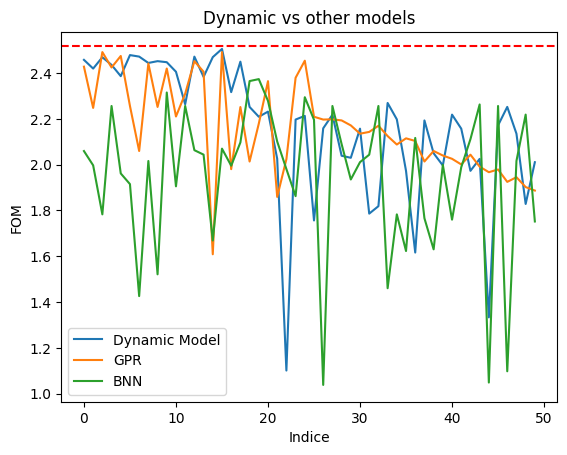

In [85]:
plt.plot(FOM_combined)
plt.plot(FOM_gpr)
plt.plot(FOM_values_BNN)
plt.axhline(y=torch.max(y), color='red', linestyle='--', label='Target Objective FOM')
plt.xlabel('Indice')
plt.ylabel('FOM')
plt.title('Dynamic vs other models')

plt.legend(['Dynamic Model', 'GPR', 'BNN'])
plt.show()

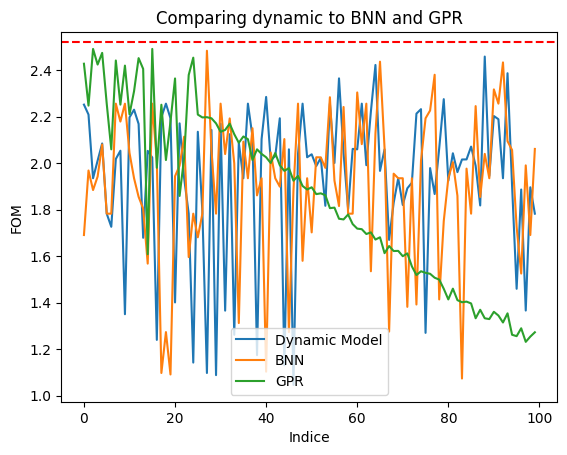

In [51]:
plt.plot(FOM_combined)
plt.plot(FOM_values_BNN)
plt.plot(FOM_gpr)
plt.axhline(y=torch.max(y).item(), color='red', linestyle='--', label='Target Objective FOM')
plt.xlabel('Indice')
plt.ylabel('FOM')
plt.title('Comparing dynamic to BNN and GPR')

plt.legend(['Dynamic Model', 'BNN', 'GPR'])
plt.show()

In [89]:
FOM_gpr_1 = []

for i in FOM_gpr:
    FOM_gpr_1.append(i.item())

In [90]:
np.sum(np.array(FOM_combined) - np.array(FOM_gpr_1))

0.2142288300106523

In [91]:
np.sum(np.array(FOM_combined) - np.array(FOM_values_BNN))

10.994078874588013

In [12]:
y_ordered = np.sort(y)

In [18]:
y_ordered.index(FOM_combined[1])

AttributeError: 'numpy.ndarray' object has no attribute 'where'

In [19]:
np.nonzero(y_ordered == FOM_combined[1])

(array([23742], dtype=int64),)

In [20]:
# Cumulative Distribution Function Generation
cdf = []
for _i_MC in range(len(FOM_combined)):
  cdf_line = []
  cdf_sum = 0
  for _j_MC in range(len(X)):
    cdf_sum = cdf_sum + np.count_nonzero(FOM_combined[_i_MC] == _j_MC+1)
    cdf_line.append(cdf_sum)
  cdf.append(cdf_line)

 ...]

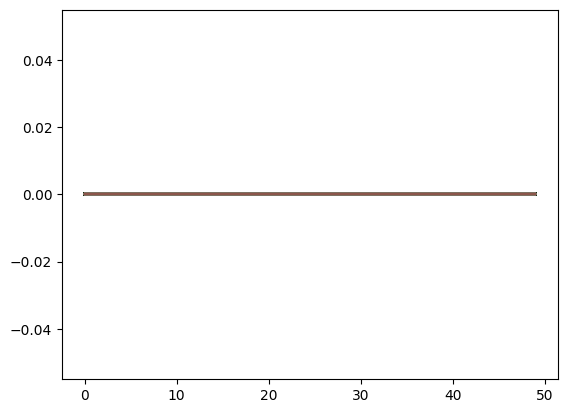

In [21]:
plt.plot(cdf)